In [1]:
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Generate Synthetic Data

In [3]:
dataset = pd.DataFrame(range(1000), columns=['stamp'])
dataset['date'] = pd.date_range(start='2021-01-04', periods=dataset.shape[0])

# Event happens by frequency
freq = 7
dataset['event'] = dataset['stamp'].apply(lambda x: 1 if x % freq == 0 else 0)

In [4]:
dataset['year'] = dataset['date'].dt.year
dataset['year'] = dataset['year'] - dataset['year'].min()
dataset['dayofyear'] = dataset['date'].dt.dayofyear

dataset['month'] = dataset['date'].dt.month
dataset['dayofmonth'] = dataset['date'].dt.day

dataset['week'] = dataset['date'].dt.weekofyear
dataset['dayofweek'] = dataset['date'].dt.dayofweek

/var/folders/4b/bb77p1fj09d0s_0z7g249tchjddcwy/T/ipykernel_92856/2062272195.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataset['week'] = dataset['date'].dt.weekofyear


In [5]:
dataset.columns

Index(['stamp', 'date', 'event', 'year', 'dayofyear', 'month', 'dayofmonth',
       'week', 'dayofweek'],
      dtype='object')

In [6]:
def split_dataset(feature, split_loc=300):
    return (dataset[feature][:split_loc].values, dataset['event'][:split_loc].values, 
            dataset[feature][split_loc:].values, dataset['event'][split_loc:].values)

# T2V Layer

In [7]:
class T2V(nn.Module):
    def __init__(self, linear_channel, period_channel):
        super().__init__()
        self.linear_channel = linear_channel
        self.period_channel = period_channel
        
        self.linear_fc = nn.Linear(1, linear_channel)
        self.period_fc = nn.Linear(1, period_channel)
        self.period_activation = torch.sin
    
    def forward(self, x):
        linear_vec = self.linear_fc(x)
        period_vec = self.period_activation(self.period_fc(x))
        return torch.cat([linear_vec, period_vec], 1)

# Model 

In [8]:
class Model:
    def __init__(self, network, max_epoch=100):
        self.network = network
        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
#         self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=1000, verbose=1)
        self.max_epoch = max_epoch
        self.dataloader = None
        self.train_dataset = None
        self.valid_dataset = None
        
        self.train_loss = []
        self.valid_loss = []
        
    def get_tensor(self, array):
        return torch.tensor(array).float()
        
    def generate_dataloader(self, x, y):
        valid_size = 200
        train_x, valid_x, train_y, valid_y = x[:-valid_size], x[-valid_size:], y[:-valid_size], y[-valid_size:]
        self.train_dataset = TensorDataset(train_x, train_y)
        self.valid_dataset = TensorDataset(valid_x, valid_y)
        self.dataloader = DataLoader(self.train_dataset, batch_size=1024, shuffle=True)
        
    def train(self, x, y):
        x = self.get_tensor(x)
        y = self.get_tensor(y)
        self.generate_dataloader(x, y)
        for epoch in range(self.max_epoch):
            self.batch_train()
            
            train_loss = self.get_loss(self.train_dataset)
            valid_loss = self.get_loss(self.valid_dataset)
            self.train_loss.append(train_loss.item())
            self.valid_loss.append(valid_loss.item())
            
#             self.scheduler.step(valid_loss)
            print(f"Epoch: {epoch}, Train Loss: {train_loss.item()}, Valid Loss: {valid_loss.item()}")
            
    def get_loss(self, dataset):
        x, y = dataset[:]
        pred = self.predict(x)
        loss = self.loss(pred, y)
        return loss
        
    def batch_train(self):
        for x, y in self.dataloader:
            self.network.train()
            self.optimizer.zero_grad()
            
            pred = self.predict(x)
            loss = self.loss(pred, y)
            
            loss.backward()
            self.optimizer.step()
            
        
    def predict(self, x):
        self.network.eval()
        return self.network(self.get_tensor(x))

# Time2Vec Model

In [9]:
train_x, train_y, test_x, test_y = split_dataset(feature=['stamp'], split_loc=800)

In [10]:
class StampNet(nn.Module):
    def __init__(self, linear_channel, period_channel):
        super().__init__()
        self.t2v = T2V(linear_channel, period_channel)
        self.fc = nn.Linear(linear_channel + period_channel, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.t2v(x)
        x = self.fc(x)
        x = self.activation(x)
        return x.reshape(-1)

In [11]:
network = StampNet(1, 16)
model = Model(network, max_epoch=10000)

In [12]:
model.train(train_x, train_y)
t2v_train_loss = pd.Series(model.train_loss)
t2v_valid_loss = pd.Series(model.valid_loss)

/var/folders/4b/bb77p1fj09d0s_0z7g249tchjddcwy/T/ipykernel_92856/3253151976.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array).float()


Epoch: 0, Train Loss: 2.576810598373413, Valid Loss: 6.046105861663818
Epoch: 1, Train Loss: 2.5421106815338135, Valid Loss: 5.954711437225342
Epoch: 2, Train Loss: 2.5064897537231445, Valid Loss: 5.866480827331543
Epoch: 3, Train Loss: 2.470064401626587, Valid Loss: 5.781005859375
Epoch: 4, Train Loss: 2.433366060256958, Valid Loss: 5.697362899780273
Epoch: 5, Train Loss: 2.396886110305786, Valid Loss: 5.614432334899902
Epoch: 6, Train Loss: 2.360736608505249, Valid Loss: 5.531495571136475
Epoch: 7, Train Loss: 2.3247575759887695, Valid Loss: 5.4479756355285645
Epoch: 8, Train Loss: 2.288809299468994, Valid Loss: 5.363989353179932
Epoch: 9, Train Loss: 2.252732276916504, Valid Loss: 5.279745101928711
Epoch: 10, Train Loss: 2.216512441635132, Valid Loss: 5.195602893829346
Epoch: 11, Train Loss: 2.180096387863159, Valid Loss: 5.112420082092285
Epoch: 12, Train Loss: 2.143482208251953, Valid Loss: 5.030714988708496
Epoch: 13, Train Loss: 2.1068389415740967, Valid Loss: 4.949587821960449


Epoch: 132, Train Loss: 0.45708730816841125, Valid Loss: 0.5739725232124329
Epoch: 133, Train Loss: 0.45700132846832275, Valid Loss: 0.575351357460022
Epoch: 134, Train Loss: 0.45691564679145813, Valid Loss: 0.5764663815498352
Epoch: 135, Train Loss: 0.4568280577659607, Valid Loss: 0.5773117542266846
Epoch: 136, Train Loss: 0.4567383825778961, Valid Loss: 0.5778870582580566
Epoch: 137, Train Loss: 0.4566468894481659, Valid Loss: 0.5782042741775513
Epoch: 138, Train Loss: 0.45655396580696106, Valid Loss: 0.57828688621521
Epoch: 139, Train Loss: 0.45645925402641296, Valid Loss: 0.5781646370887756
Epoch: 140, Train Loss: 0.4563620090484619, Valid Loss: 0.577870786190033
Epoch: 141, Train Loss: 0.4562624990940094, Valid Loss: 0.5774354338645935
Epoch: 142, Train Loss: 0.45616158843040466, Valid Loss: 0.5768813490867615
Epoch: 143, Train Loss: 0.4560604989528656, Valid Loss: 0.5762376189231873
Epoch: 144, Train Loss: 0.45596033334732056, Valid Loss: 0.575533390045166
Epoch: 145, Train Loss:

Epoch: 242, Train Loss: 0.4478686451911926, Valid Loss: 0.5777649283409119
Epoch: 243, Train Loss: 0.4477976858615875, Valid Loss: 0.577772319316864
Epoch: 244, Train Loss: 0.4477263391017914, Valid Loss: 0.5779295563697815
Epoch: 245, Train Loss: 0.4476548731327057, Valid Loss: 0.5779529809951782
Epoch: 246, Train Loss: 0.4475841224193573, Valid Loss: 0.5779739618301392
Epoch: 247, Train Loss: 0.44751328229904175, Valid Loss: 0.5781214237213135
Epoch: 248, Train Loss: 0.4474424123764038, Valid Loss: 0.5781466960906982
Epoch: 249, Train Loss: 0.4473719894886017, Valid Loss: 0.5781834125518799
Epoch: 250, Train Loss: 0.44730162620544434, Valid Loss: 0.5783219933509827
Epoch: 251, Train Loss: 0.44723114371299744, Valid Loss: 0.5783452987670898
Epoch: 252, Train Loss: 0.44716110825538635, Valid Loss: 0.5784001350402832
Epoch: 253, Train Loss: 0.44709116220474243, Valid Loss: 0.5785267353057861
Epoch: 254, Train Loss: 0.4470210671424866, Valid Loss: 0.5785475373268127
Epoch: 255, Train Los

Epoch: 369, Train Loss: 0.4396968483924866, Valid Loss: 0.585075855255127
Epoch: 370, Train Loss: 0.43963199853897095, Valid Loss: 0.584927499294281
Epoch: 371, Train Loss: 0.43957528471946716, Valid Loss: 0.5849955081939697
Epoch: 372, Train Loss: 0.4395223557949066, Valid Loss: 0.5851606726646423
Epoch: 373, Train Loss: 0.4394649863243103, Valid Loss: 0.5848789215087891
Epoch: 374, Train Loss: 0.4394015371799469, Valid Loss: 0.5852822661399841
Epoch: 375, Train Loss: 0.43934062123298645, Valid Loss: 0.5851856470108032
Epoch: 376, Train Loss: 0.4392853379249573, Valid Loss: 0.5851548314094543
Epoch: 377, Train Loss: 0.4392300546169281, Valid Loss: 0.5853909850120544
Epoch: 378, Train Loss: 0.4391701817512512, Valid Loss: 0.5851719379425049
Epoch: 379, Train Loss: 0.4391093850135803, Valid Loss: 0.5854343771934509
Epoch: 380, Train Loss: 0.43905243277549744, Valid Loss: 0.5854431390762329
Epoch: 381, Train Loss: 0.43899714946746826, Valid Loss: 0.5853196382522583
Epoch: 382, Train Loss

Epoch: 509, Train Loss: 0.4321765601634979, Valid Loss: 0.5891037583351135
Epoch: 510, Train Loss: 0.4321269690990448, Valid Loss: 0.589110791683197
Epoch: 511, Train Loss: 0.4320774972438812, Valid Loss: 0.5891435742378235
Epoch: 512, Train Loss: 0.4320279061794281, Valid Loss: 0.5891508460044861
Epoch: 513, Train Loss: 0.4319784641265869, Valid Loss: 0.5891844034194946
Epoch: 514, Train Loss: 0.43192917108535767, Valid Loss: 0.5891878008842468
Epoch: 515, Train Loss: 0.43187981843948364, Valid Loss: 0.5892238020896912
Epoch: 516, Train Loss: 0.43183043599128723, Valid Loss: 0.5892319083213806
Epoch: 517, Train Loss: 0.4317813217639923, Valid Loss: 0.5892581343650818
Epoch: 518, Train Loss: 0.4317321181297302, Valid Loss: 0.5892818570137024
Epoch: 519, Train Loss: 0.4316829442977905, Valid Loss: 0.589281439781189
Epoch: 520, Train Loss: 0.43163391947746277, Valid Loss: 0.5893383026123047
Epoch: 521, Train Loss: 0.4315849244594574, Valid Loss: 0.5892975926399231
Epoch: 522, Train Loss:

Epoch: 649, Train Loss: 0.42568185925483704, Valid Loss: 0.5921759605407715
Epoch: 650, Train Loss: 0.4256327450275421, Valid Loss: 0.5903674960136414
Epoch: 651, Train Loss: 0.42558038234710693, Valid Loss: 0.5918076038360596
Epoch: 652, Train Loss: 0.42553165555000305, Valid Loss: 0.5912835597991943
Epoch: 653, Train Loss: 0.4254891872406006, Valid Loss: 0.591007649898529
Epoch: 654, Train Loss: 0.42545008659362793, Valid Loss: 0.5919555425643921
Epoch: 655, Train Loss: 0.4254094064235687, Valid Loss: 0.5906069278717041
Epoch: 656, Train Loss: 0.4253638684749603, Valid Loss: 0.5919568538665771
Epoch: 657, Train Loss: 0.4253162741661072, Valid Loss: 0.5910804271697998
Epoch: 658, Train Loss: 0.4252709448337555, Valid Loss: 0.5913748741149902
Epoch: 659, Train Loss: 0.42522865533828735, Valid Loss: 0.5917701125144958
Epoch: 660, Train Loss: 0.42518723011016846, Valid Loss: 0.590901792049408
Epoch: 661, Train Loss: 0.4251437187194824, Valid Loss: 0.5919605493545532
Epoch: 662, Train Los

Epoch: 785, Train Loss: 0.4200229048728943, Valid Loss: 0.5930259227752686
Epoch: 786, Train Loss: 0.41998371481895447, Valid Loss: 0.5927255153656006
Epoch: 787, Train Loss: 0.41994455456733704, Valid Loss: 0.5930770635604858
Epoch: 788, Train Loss: 0.41990548372268677, Valid Loss: 0.5926973819732666
Epoch: 789, Train Loss: 0.4198664128780365, Valid Loss: 0.5931716561317444
Epoch: 790, Train Loss: 0.41982749104499817, Valid Loss: 0.5926153063774109
Epoch: 791, Train Loss: 0.4197887182235718, Valid Loss: 0.593320369720459
Epoch: 792, Train Loss: 0.41975030303001404, Valid Loss: 0.5924674868583679
Epoch: 793, Train Loss: 0.4197121858596802, Valid Loss: 0.5935338735580444
Epoch: 794, Train Loss: 0.4196746349334717, Valid Loss: 0.5922192335128784
Epoch: 795, Train Loss: 0.4196379482746124, Valid Loss: 0.5938404202461243
Epoch: 796, Train Loss: 0.41960257291793823, Valid Loss: 0.5918166041374207
Epoch: 797, Train Loss: 0.41956862807273865, Valid Loss: 0.5942478775978088
Epoch: 798, Train L

Epoch: 907, Train Loss: 0.4154638648033142, Valid Loss: 0.5956167578697205
Epoch: 908, Train Loss: 0.415426105260849, Valid Loss: 0.5930442810058594
Epoch: 909, Train Loss: 0.41538819670677185, Valid Loss: 0.5953351855278015
Epoch: 910, Train Loss: 0.41535013914108276, Valid Loss: 0.593483030796051
Epoch: 911, Train Loss: 0.4153127074241638, Valid Loss: 0.5949690341949463
Epoch: 912, Train Loss: 0.41527584195137024, Valid Loss: 0.5939410924911499
Epoch: 913, Train Loss: 0.41523951292037964, Valid Loss: 0.5945990681648254
Epoch: 914, Train Loss: 0.41520366072654724, Valid Loss: 0.5943530201911926
Epoch: 915, Train Loss: 0.4151683747768402, Valid Loss: 0.5942538380622864
Epoch: 916, Train Loss: 0.4151332974433899, Valid Loss: 0.5947180390357971
Epoch: 917, Train Loss: 0.4150986969470978, Valid Loss: 0.5939371585845947
Epoch: 918, Train Loss: 0.4150642454624176, Valid Loss: 0.5950486660003662
Epoch: 919, Train Loss: 0.4150297939777374, Valid Loss: 0.5936493873596191
Epoch: 920, Train Loss

Epoch: 1017, Train Loss: 0.411703884601593, Valid Loss: 0.5963500738143921
Epoch: 1018, Train Loss: 0.4116722345352173, Valid Loss: 0.5951146483421326
Epoch: 1019, Train Loss: 0.411641001701355, Valid Loss: 0.5967358350753784
Epoch: 1020, Train Loss: 0.41160985827445984, Valid Loss: 0.594775378704071
Epoch: 1021, Train Loss: 0.4115793704986572, Valid Loss: 0.5971330404281616
Epoch: 1022, Train Loss: 0.4115491807460785, Valid Loss: 0.5943940877914429
Epoch: 1023, Train Loss: 0.4115200936794281, Valid Loss: 0.5975939035415649
Epoch: 1024, Train Loss: 0.41149085760116577, Valid Loss: 0.5939153432846069
Epoch: 1025, Train Loss: 0.4114639163017273, Valid Loss: 0.5981209874153137
Epoch: 1026, Train Loss: 0.4114357531070709, Valid Loss: 0.5933823585510254
Epoch: 1027, Train Loss: 0.41140928864479065, Valid Loss: 0.5985966920852661
Epoch: 1028, Train Loss: 0.4113787114620209, Valid Loss: 0.5930441617965698
Epoch: 1029, Train Loss: 0.4113479256629944, Valid Loss: 0.598720371723175
Epoch: 1030, 

Epoch: 1153, Train Loss: 0.4075515866279602, Valid Loss: 0.598432719707489
Epoch: 1154, Train Loss: 0.40752309560775757, Valid Loss: 0.5978983044624329
Epoch: 1155, Train Loss: 0.40749457478523254, Valid Loss: 0.5984265804290771
Epoch: 1156, Train Loss: 0.40746599435806274, Valid Loss: 0.5980787873268127
Epoch: 1157, Train Loss: 0.40743744373321533, Valid Loss: 0.5982590317726135
Epoch: 1158, Train Loss: 0.40740910172462463, Valid Loss: 0.5983285903930664
Epoch: 1159, Train Loss: 0.407380610704422, Valid Loss: 0.5981372594833374
Epoch: 1160, Train Loss: 0.40735235810279846, Valid Loss: 0.5984752178192139
Epoch: 1161, Train Loss: 0.40732407569885254, Valid Loss: 0.598108172416687
Epoch: 1162, Train Loss: 0.407295823097229, Valid Loss: 0.5985326766967773
Epoch: 1163, Train Loss: 0.4072674810886383, Valid Loss: 0.5981706976890564
Epoch: 1164, Train Loss: 0.4072391092777252, Valid Loss: 0.5985103249549866
Epoch: 1165, Train Loss: 0.40721094608306885, Valid Loss: 0.5982941389083862
Epoch: 1

Epoch: 1298, Train Loss: 0.4037531614303589, Valid Loss: 0.604292631149292
Epoch: 1299, Train Loss: 0.40376147627830505, Valid Loss: 0.5958191752433777
Epoch: 1300, Train Loss: 0.4037491977214813, Valid Loss: 0.6061944961547852
Epoch: 1301, Train Loss: 0.4036940932273865, Valid Loss: 0.5967135429382324
Epoch: 1302, Train Loss: 0.4036388397216797, Valid Loss: 0.6028182506561279
Epoch: 1303, Train Loss: 0.4036092758178711, Valid Loss: 0.6018152832984924
Epoch: 1304, Train Loss: 0.40360403060913086, Valid Loss: 0.5978808403015137
Epoch: 1305, Train Loss: 0.4035986363887787, Valid Loss: 0.605007529258728
Epoch: 1306, Train Loss: 0.40356767177581787, Valid Loss: 0.5970550775527954
Epoch: 1307, Train Loss: 0.4035245180130005, Valid Loss: 0.6033799648284912
Epoch: 1308, Train Loss: 0.40348827838897705, Valid Loss: 0.6007809638977051
Epoch: 1309, Train Loss: 0.4034702479839325, Valid Loss: 0.5994565486907959
Epoch: 1310, Train Loss: 0.40345919132232666, Valid Loss: 0.6039960384368896
Epoch: 13

Epoch: 1438, Train Loss: 0.4006350636482239, Valid Loss: 0.6035474538803101
Epoch: 1439, Train Loss: 0.40061482787132263, Valid Loss: 0.6035383939743042
Epoch: 1440, Train Loss: 0.4005950093269348, Valid Loss: 0.6039777398109436
Epoch: 1441, Train Loss: 0.4005751609802246, Valid Loss: 0.603240966796875
Epoch: 1442, Train Loss: 0.40055525302886963, Valid Loss: 0.6042386889457703
Epoch: 1443, Train Loss: 0.4005354940891266, Valid Loss: 0.6031394600868225
Epoch: 1444, Train Loss: 0.40051549673080444, Valid Loss: 0.6043208837509155
Epoch: 1445, Train Loss: 0.40049564838409424, Valid Loss: 0.6032083630561829
Epoch: 1446, Train Loss: 0.4004756212234497, Valid Loss: 0.604279637336731
Epoch: 1447, Train Loss: 0.4004555940628052, Valid Loss: 0.603364884853363
Epoch: 1448, Train Loss: 0.400436133146286, Valid Loss: 0.6041769981384277
Epoch: 1449, Train Loss: 0.40041589736938477, Valid Loss: 0.6035676598548889
Epoch: 1450, Train Loss: 0.40039607882499695, Valid Loss: 0.6040490865707397
Epoch: 145

Epoch: 1577, Train Loss: 0.39815863966941833, Valid Loss: 0.6003803014755249
Epoch: 1578, Train Loss: 0.39811304211616516, Valid Loss: 0.6091539859771729
Epoch: 1579, Train Loss: 0.3980814218521118, Valid Loss: 0.6056306958198547
Epoch: 1580, Train Loss: 0.39807257056236267, Valid Loss: 0.6037516593933105
Epoch: 1581, Train Loss: 0.39807456731796265, Valid Loss: 0.610107958316803
Epoch: 1582, Train Loss: 0.3980676531791687, Valid Loss: 0.6011782288551331
Epoch: 1583, Train Loss: 0.39804643392562866, Valid Loss: 0.6104403138160706
Epoch: 1584, Train Loss: 0.39801377058029175, Valid Loss: 0.6032138466835022
Epoch: 1585, Train Loss: 0.3979855477809906, Valid Loss: 0.6071850061416626
Epoch: 1586, Train Loss: 0.3979699909687042, Valid Loss: 0.6073251962661743
Epoch: 1587, Train Loss: 0.3979629576206207, Valid Loss: 0.603588879108429
Epoch: 1588, Train Loss: 0.3979547917842865, Valid Loss: 0.6097321510314941
Epoch: 1589, Train Loss: 0.3979378044605255, Valid Loss: 0.602764904499054
Epoch: 15

Epoch: 1698, Train Loss: 0.3963163197040558, Valid Loss: 0.6091098189353943
Epoch: 1699, Train Loss: 0.3963020443916321, Valid Loss: 0.6068904995918274
Epoch: 1700, Train Loss: 0.3962880074977875, Valid Loss: 0.6086622476577759
Epoch: 1701, Train Loss: 0.39627400040626526, Valid Loss: 0.6074787378311157
Epoch: 1702, Train Loss: 0.3962603211402893, Valid Loss: 0.6081289649009705
Epoch: 1703, Train Loss: 0.3962468206882477, Valid Loss: 0.6080383062362671
Epoch: 1704, Train Loss: 0.3962336480617523, Valid Loss: 0.6076652407646179
Epoch: 1705, Train Loss: 0.3962205946445465, Valid Loss: 0.6084773540496826
Epoch: 1706, Train Loss: 0.3962072730064392, Valid Loss: 0.6073297262191772
Epoch: 1707, Train Loss: 0.396194189786911, Valid Loss: 0.6087949275970459
Epoch: 1708, Train Loss: 0.3961811363697052, Valid Loss: 0.6071046590805054
Epoch: 1709, Train Loss: 0.3961680233478546, Valid Loss: 0.6090238690376282
Epoch: 1710, Train Loss: 0.3961550295352936, Valid Loss: 0.6069579720497131
Epoch: 1711,

Epoch: 1841, Train Loss: 0.3945849537849426, Valid Loss: 0.6114818453788757
Epoch: 1842, Train Loss: 0.39457452297210693, Valid Loss: 0.6079394817352295
Epoch: 1843, Train Loss: 0.3945639431476593, Valid Loss: 0.6116544008255005
Epoch: 1844, Train Loss: 0.3945533335208893, Valid Loss: 0.6078148484230042
Epoch: 1845, Train Loss: 0.3945431411266327, Valid Loss: 0.6118261218070984
Epoch: 1846, Train Loss: 0.39453285932540894, Valid Loss: 0.6076536774635315
Epoch: 1847, Train Loss: 0.3945227563381195, Valid Loss: 0.6120629906654358
Epoch: 1848, Train Loss: 0.39451277256011963, Valid Loss: 0.6073981523513794
Epoch: 1849, Train Loss: 0.39450332522392273, Valid Loss: 0.612418532371521
Epoch: 1850, Train Loss: 0.39449387788772583, Valid Loss: 0.6070001721382141
Epoch: 1851, Train Loss: 0.3944852948188782, Valid Loss: 0.6129569411277771
Epoch: 1852, Train Loss: 0.39447706937789917, Valid Loss: 0.6063984632492065
Epoch: 1853, Train Loss: 0.3944702446460724, Valid Loss: 0.6137340664863586
Epoch: 

Epoch: 1953, Train Loss: 0.39347100257873535, Valid Loss: 0.6094512343406677
Epoch: 1954, Train Loss: 0.39346227049827576, Valid Loss: 0.612847626209259
Epoch: 1955, Train Loss: 0.39345329999923706, Valid Loss: 0.6091808080673218
Epoch: 1956, Train Loss: 0.393444299697876, Valid Loss: 0.612949550151825
Epoch: 1957, Train Loss: 0.39343467354774475, Valid Loss: 0.6093582510948181
Epoch: 1958, Train Loss: 0.39342501759529114, Valid Loss: 0.6126841306686401
Epoch: 1959, Train Loss: 0.39341530203819275, Valid Loss: 0.6098310947418213
Epoch: 1960, Train Loss: 0.3934055268764496, Valid Loss: 0.6122161149978638
Epoch: 1961, Train Loss: 0.3933960199356079, Valid Loss: 0.6104070544242859
Epoch: 1962, Train Loss: 0.39338672161102295, Valid Loss: 0.6116949319839478
Epoch: 1963, Train Loss: 0.3933775722980499, Valid Loss: 0.6109431982040405
Epoch: 1964, Train Loss: 0.3933682441711426, Valid Loss: 0.611203134059906
Epoch: 1965, Train Loss: 0.39335930347442627, Valid Loss: 0.6114081740379333
Epoch: 1

Epoch: 2068, Train Loss: 0.3925330638885498, Valid Loss: 0.607019305229187
Epoch: 2069, Train Loss: 0.3925504684448242, Valid Loss: 0.6195661425590515
Epoch: 2070, Train Loss: 0.3925522267818451, Valid Loss: 0.6042667627334595
Epoch: 2071, Train Loss: 0.392538845539093, Valid Loss: 0.619815468788147
Epoch: 2072, Train Loss: 0.3925086557865143, Valid Loss: 0.6065073013305664
Epoch: 2073, Train Loss: 0.3924793601036072, Valid Loss: 0.6159723401069641
Epoch: 2074, Train Loss: 0.3924601376056671, Valid Loss: 0.6117578744888306
Epoch: 2075, Train Loss: 0.3924553096294403, Valid Loss: 0.61077481508255
Epoch: 2076, Train Loss: 0.3924591839313507, Valid Loss: 0.6163997054100037
Epoch: 2077, Train Loss: 0.39246222376823425, Valid Loss: 0.6074385643005371
Epoch: 2078, Train Loss: 0.3924587368965149, Valid Loss: 0.6179782152175903
Epoch: 2079, Train Loss: 0.39244505763053894, Valid Loss: 0.6076465845108032
Epoch: 2080, Train Loss: 0.3924272656440735, Valid Loss: 0.6161781549453735
Epoch: 2081, Tr

Epoch: 2199, Train Loss: 0.39159536361694336, Valid Loss: 0.6155369281768799
Epoch: 2200, Train Loss: 0.3915894329547882, Valid Loss: 0.6125588417053223
Epoch: 2201, Train Loss: 0.3915834128856659, Valid Loss: 0.615790843963623
Epoch: 2202, Train Loss: 0.3915775418281555, Valid Loss: 0.6123148798942566
Epoch: 2203, Train Loss: 0.391571968793869, Valid Loss: 0.6161145567893982
Epoch: 2204, Train Loss: 0.3915664255619049, Valid Loss: 0.6119722723960876
Epoch: 2205, Train Loss: 0.39156123995780945, Valid Loss: 0.616585373878479
Epoch: 2206, Train Loss: 0.39155638217926025, Valid Loss: 0.6114575862884521
Epoch: 2207, Train Loss: 0.3915521204471588, Valid Loss: 0.6172857880592346
Epoch: 2208, Train Loss: 0.3915485441684723, Valid Loss: 0.6106715202331543
Epoch: 2209, Train Loss: 0.39154621958732605, Valid Loss: 0.6183095574378967
Epoch: 2210, Train Loss: 0.3915449380874634, Valid Loss: 0.6095101237297058
Epoch: 2211, Train Loss: 0.39154624938964844, Valid Loss: 0.6197470426559448
Epoch: 221

Epoch: 2315, Train Loss: 0.3909245431423187, Valid Loss: 0.6165883541107178
Epoch: 2316, Train Loss: 0.39091864228248596, Valid Loss: 0.6152981519699097
Epoch: 2317, Train Loss: 0.39091330766677856, Valid Loss: 0.6155097484588623
Epoch: 2318, Train Loss: 0.39090844988822937, Valid Loss: 0.6163066029548645
Epoch: 2319, Train Loss: 0.3909035921096802, Valid Loss: 0.6146603226661682
Epoch: 2320, Train Loss: 0.3908992111682892, Valid Loss: 0.6171191334724426
Epoch: 2321, Train Loss: 0.3908945322036743, Valid Loss: 0.6140545010566711
Epoch: 2322, Train Loss: 0.3908903896808624, Valid Loss: 0.6177366375923157
Epoch: 2323, Train Loss: 0.39088574051856995, Valid Loss: 0.6136261820793152
Epoch: 2324, Train Loss: 0.3908814489841461, Valid Loss: 0.6182018518447876
Epoch: 2325, Train Loss: 0.390876829624176, Valid Loss: 0.6132748126983643
Epoch: 2326, Train Loss: 0.3908725082874298, Valid Loss: 0.6185961365699768
Epoch: 2327, Train Loss: 0.3908681571483612, Valid Loss: 0.6129214763641357
Epoch: 23

Epoch: 2459, Train Loss: 0.3902723789215088, Valid Loss: 0.6116768717765808
Epoch: 2460, Train Loss: 0.3902689218521118, Valid Loss: 0.6239952445030212
Epoch: 2461, Train Loss: 0.39026111364364624, Valid Loss: 0.6121178269386292
Epoch: 2462, Train Loss: 0.3902513384819031, Valid Loss: 0.6229627728462219
Epoch: 2463, Train Loss: 0.39023974537849426, Valid Loss: 0.6138589382171631
Epoch: 2464, Train Loss: 0.39022913575172424, Valid Loss: 0.620846688747406
Epoch: 2465, Train Loss: 0.390220046043396, Valid Loss: 0.6161884665489197
Epoch: 2466, Train Loss: 0.3902137875556946, Valid Loss: 0.6184256672859192
Epoch: 2467, Train Loss: 0.3902096152305603, Valid Loss: 0.618451714515686
Epoch: 2468, Train Loss: 0.39020705223083496, Valid Loss: 0.616372287273407
Epoch: 2469, Train Loss: 0.39020559191703796, Valid Loss: 0.6202274560928345
Epoch: 2470, Train Loss: 0.3902040719985962, Valid Loss: 0.6150178909301758
Epoch: 2471, Train Loss: 0.3902021646499634, Valid Loss: 0.6213590502738953
Epoch: 2472

Epoch: 2570, Train Loss: 0.3898201584815979, Valid Loss: 0.6169770956039429
Epoch: 2571, Train Loss: 0.389818012714386, Valid Loss: 0.6225359439849854
Epoch: 2572, Train Loss: 0.3898162245750427, Valid Loss: 0.6163466572761536
Epoch: 2573, Train Loss: 0.3898153603076935, Valid Loss: 0.6233749985694885
Epoch: 2574, Train Loss: 0.38981568813323975, Valid Loss: 0.6154336929321289
Epoch: 2575, Train Loss: 0.3898165822029114, Valid Loss: 0.624558687210083
Epoch: 2576, Train Loss: 0.38981902599334717, Valid Loss: 0.6141183972358704
Epoch: 2577, Train Loss: 0.38982442021369934, Valid Loss: 0.626177966594696
Epoch: 2578, Train Loss: 0.3898307979106903, Valid Loss: 0.6123467087745667
Epoch: 2579, Train Loss: 0.38984087109565735, Valid Loss: 0.628253698348999
Epoch: 2580, Train Loss: 0.38985082507133484, Valid Loss: 0.6101902723312378
Epoch: 2581, Train Loss: 0.3898646831512451, Valid Loss: 0.630540132522583
Epoch: 2582, Train Loss: 0.3898724913597107, Valid Loss: 0.6081982254981995
Epoch: 2583,

Epoch: 2707, Train Loss: 0.38941630721092224, Valid Loss: 0.6286575198173523
Epoch: 2708, Train Loss: 0.38940465450286865, Valid Loss: 0.6162642240524292
Epoch: 2709, Train Loss: 0.38939258456230164, Valid Loss: 0.6262368559837341
Epoch: 2710, Train Loss: 0.3893815279006958, Valid Loss: 0.6192018985748291
Epoch: 2711, Train Loss: 0.3893735110759735, Valid Loss: 0.6230667233467102
Epoch: 2712, Train Loss: 0.38936883211135864, Valid Loss: 0.622225284576416
Epoch: 2713, Train Loss: 0.3893674314022064, Valid Loss: 0.6202791333198547
Epoch: 2714, Train Loss: 0.38936808705329895, Valid Loss: 0.6245782375335693
Epoch: 2715, Train Loss: 0.3893691897392273, Valid Loss: 0.6184917688369751
Epoch: 2716, Train Loss: 0.3893699049949646, Valid Loss: 0.6259522438049316
Epoch: 2717, Train Loss: 0.38936933875083923, Valid Loss: 0.617825984954834
Epoch: 2718, Train Loss: 0.38936662673950195, Valid Loss: 0.6263045072555542
Epoch: 2719, Train Loss: 0.3893624246120453, Valid Loss: 0.6180795431137085
Epoch: 

Epoch: 2849, Train Loss: 0.38904696702957153, Valid Loss: 0.619483470916748
Epoch: 2850, Train Loss: 0.3890353739261627, Valid Loss: 0.6273786425590515
Epoch: 2851, Train Loss: 0.3890259265899658, Valid Loss: 0.6236246228218079
Epoch: 2852, Train Loss: 0.38902726769447327, Valid Loss: 0.6224018335342407
Epoch: 2853, Train Loss: 0.38903021812438965, Valid Loss: 0.6277464032173157
Epoch: 2854, Train Loss: 0.3890288174152374, Valid Loss: 0.6206212043762207
Epoch: 2855, Train Loss: 0.38902395963668823, Valid Loss: 0.6273566484451294
Epoch: 2856, Train Loss: 0.3890184462070465, Valid Loss: 0.6225114464759827
Epoch: 2857, Train Loss: 0.3890145719051361, Valid Loss: 0.6245157122612
Epoch: 2858, Train Loss: 0.38901254534721375, Valid Loss: 0.6256992220878601
Epoch: 2859, Train Loss: 0.38901177048683167, Valid Loss: 0.6220722794532776
Epoch: 2860, Train Loss: 0.3890116512775421, Valid Loss: 0.6269516348838806
Epoch: 2861, Train Loss: 0.3890092074871063, Valid Loss: 0.6221703886985779
Epoch: 286

Epoch: 2957, Train Loss: 0.38915953040122986, Valid Loss: 0.6496840715408325
Epoch: 2958, Train Loss: 0.3891143798828125, Valid Loss: 0.6043321490287781
Epoch: 2959, Train Loss: 0.3890237808227539, Valid Loss: 0.6447837352752686
Epoch: 2960, Train Loss: 0.3888933062553406, Valid Loss: 0.6148577332496643
Epoch: 2961, Train Loss: 0.38881707191467285, Valid Loss: 0.6297719478607178
Epoch: 2962, Train Loss: 0.38882073760032654, Valid Loss: 0.6305431127548218
Epoch: 2963, Train Loss: 0.38887467980384827, Valid Loss: 0.6156272292137146
Epoch: 2964, Train Loss: 0.38892996311187744, Valid Loss: 0.6403186321258545
Epoch: 2965, Train Loss: 0.38893646001815796, Valid Loss: 0.6113116145133972
Epoch: 2966, Train Loss: 0.3889060914516449, Valid Loss: 0.6388536691665649
Epoch: 2967, Train Loss: 0.38885173201560974, Valid Loss: 0.6185572743415833
Epoch: 2968, Train Loss: 0.38881027698516846, Valid Loss: 0.6287674903869629
Epoch: 2969, Train Loss: 0.38880228996276855, Valid Loss: 0.6296328902244568
Epo

Epoch: 3065, Train Loss: 0.3887787163257599, Valid Loss: 0.6422688364982605
Epoch: 3066, Train Loss: 0.38882237672805786, Valid Loss: 0.6114975810050964
Epoch: 3067, Train Loss: 0.3888748288154602, Valid Loss: 0.6477511525154114
Epoch: 3068, Train Loss: 0.38890042901039124, Valid Loss: 0.6072948575019836
Epoch: 3069, Train Loss: 0.3889116048812866, Valid Loss: 0.6496884822845459
Epoch: 3070, Train Loss: 0.38885167241096497, Valid Loss: 0.6091583967208862
Epoch: 3071, Train Loss: 0.3887682557106018, Valid Loss: 0.6433426141738892
Epoch: 3072, Train Loss: 0.3886764645576477, Valid Loss: 0.6193590760231018
Epoch: 3073, Train Loss: 0.38862958550453186, Valid Loss: 0.630262017250061
Epoch: 3074, Train Loss: 0.3886367678642273, Valid Loss: 0.6323657035827637
Epoch: 3075, Train Loss: 0.38867732882499695, Valid Loss: 0.6186650991439819
Epoch: 3076, Train Loss: 0.38871967792510986, Valid Loss: 0.640724778175354
Epoch: 3077, Train Loss: 0.3887309730052948, Valid Loss: 0.614572286605835
Epoch: 30

Epoch: 3183, Train Loss: 0.38853079080581665, Valid Loss: 0.6211693286895752
Epoch: 3184, Train Loss: 0.38853877782821655, Valid Loss: 0.6387603878974915
Epoch: 3185, Train Loss: 0.3885270059108734, Valid Loss: 0.6223737597465515
Epoch: 3186, Train Loss: 0.3885030746459961, Valid Loss: 0.6353864073753357
Epoch: 3187, Train Loss: 0.388482928276062, Valid Loss: 0.6275229454040527
Epoch: 3188, Train Loss: 0.3884768486022949, Valid Loss: 0.6295071244239807
Epoch: 3189, Train Loss: 0.3884848654270172, Valid Loss: 0.6333475112915039
Epoch: 3190, Train Loss: 0.38849616050720215, Valid Loss: 0.6250001192092896
Epoch: 3191, Train Loss: 0.38850051164627075, Valid Loss: 0.6362941861152649
Epoch: 3192, Train Loss: 0.3884948492050171, Valid Loss: 0.623974084854126
Epoch: 3193, Train Loss: 0.38848504424095154, Valid Loss: 0.6349892020225525
Epoch: 3194, Train Loss: 0.388475626707077, Valid Loss: 0.6269032955169678
Epoch: 3195, Train Loss: 0.3884706497192383, Valid Loss: 0.6312445998191833
Epoch: 319

Epoch: 3327, Train Loss: 0.3883340060710907, Valid Loss: 0.6325556039810181
Epoch: 3328, Train Loss: 0.3883332908153534, Valid Loss: 0.6318586468696594
Epoch: 3329, Train Loss: 0.38833245635032654, Valid Loss: 0.6331419348716736
Epoch: 3330, Train Loss: 0.38833191990852356, Valid Loss: 0.631437361240387
Epoch: 3331, Train Loss: 0.38833093643188477, Valid Loss: 0.6335195302963257
Epoch: 3332, Train Loss: 0.38833022117614746, Valid Loss: 0.6312565803527832
Epoch: 3333, Train Loss: 0.3883292078971863, Valid Loss: 0.633681058883667
Epoch: 3334, Train Loss: 0.38832855224609375, Valid Loss: 0.6312653422355652
Epoch: 3335, Train Loss: 0.38832759857177734, Valid Loss: 0.6336603760719299
Epoch: 3336, Train Loss: 0.3883264660835266, Valid Loss: 0.6314175128936768
Epoch: 3337, Train Loss: 0.388325572013855, Valid Loss: 0.6335229873657227
Epoch: 3338, Train Loss: 0.38832464814186096, Valid Loss: 0.6316478848457336
Epoch: 3339, Train Loss: 0.3883238136768341, Valid Loss: 0.6333777904510498
Epoch: 3

Epoch: 3459, Train Loss: 0.38848474621772766, Valid Loss: 0.6561845541000366
Epoch: 3460, Train Loss: 0.38841307163238525, Valid Loss: 0.6164361238479614
Epoch: 3461, Train Loss: 0.38833123445510864, Valid Loss: 0.6479464769363403
Epoch: 3462, Train Loss: 0.3882603347301483, Valid Loss: 0.6274179220199585
Epoch: 3463, Train Loss: 0.38823002576828003, Valid Loss: 0.6349951028823853
Epoch: 3464, Train Loss: 0.3882439434528351, Valid Loss: 0.639706015586853
Epoch: 3465, Train Loss: 0.38828346133232117, Valid Loss: 0.6243674755096436
Epoch: 3466, Train Loss: 0.38832297921180725, Valid Loss: 0.6476075649261475
Epoch: 3467, Train Loss: 0.38833382725715637, Valid Loss: 0.6205365061759949
Epoch: 3468, Train Loss: 0.38831791281700134, Valid Loss: 0.647655725479126
Epoch: 3469, Train Loss: 0.3882814645767212, Valid Loss: 0.6247297525405884
Epoch: 3470, Train Loss: 0.3882472813129425, Valid Loss: 0.6403598189353943
Epoch: 3471, Train Loss: 0.3882288634777069, Valid Loss: 0.6335639357566833
Epoch:

Epoch: 3591, Train Loss: 0.38815540075302124, Valid Loss: 0.6388751268386841
Epoch: 3592, Train Loss: 0.3881535232067108, Valid Loss: 0.6343265771865845
Epoch: 3593, Train Loss: 0.38815227150917053, Valid Loss: 0.6378753185272217
Epoch: 3594, Train Loss: 0.3881506025791168, Valid Loss: 0.6354792714118958
Epoch: 3595, Train Loss: 0.38815003633499146, Valid Loss: 0.6368498802185059
Epoch: 3596, Train Loss: 0.3881489932537079, Valid Loss: 0.6364506483078003
Epoch: 3597, Train Loss: 0.3881484568119049, Valid Loss: 0.6359857320785522
Epoch: 3598, Train Loss: 0.3881482183933258, Valid Loss: 0.6371890306472778
Epoch: 3599, Train Loss: 0.3881479799747467, Valid Loss: 0.6353978514671326
Epoch: 3600, Train Loss: 0.38814792037010193, Valid Loss: 0.6377384662628174
Epoch: 3601, Train Loss: 0.38814765214920044, Valid Loss: 0.6350834369659424
Epoch: 3602, Train Loss: 0.3881475329399109, Valid Loss: 0.6380966901779175
Epoch: 3603, Train Loss: 0.3881474435329437, Valid Loss: 0.6348928213119507
Epoch: 

Epoch: 3731, Train Loss: 0.38811856508255005, Valid Loss: 0.6455309391021729
Epoch: 3732, Train Loss: 0.3881244659423828, Valid Loss: 0.6304396986961365
Epoch: 3733, Train Loss: 0.38813161849975586, Valid Loss: 0.6471554040908813
Epoch: 3734, Train Loss: 0.3881400525569916, Valid Loss: 0.6287810206413269
Epoch: 3735, Train Loss: 0.38815027475357056, Valid Loss: 0.6490570306777954
Epoch: 3736, Train Loss: 0.3881606459617615, Valid Loss: 0.6269328594207764
Epoch: 3737, Train Loss: 0.38817286491394043, Valid Loss: 0.6510303020477295
Epoch: 3738, Train Loss: 0.3881835341453552, Valid Loss: 0.6252164244651794
Epoch: 3739, Train Loss: 0.38819336891174316, Valid Loss: 0.6526022553443909
Epoch: 3740, Train Loss: 0.38819754123687744, Valid Loss: 0.6242170929908752
Epoch: 3741, Train Loss: 0.3881980776786804, Valid Loss: 0.653042197227478
Epoch: 3742, Train Loss: 0.38818827271461487, Valid Loss: 0.6246665120124817
Epoch: 3743, Train Loss: 0.3881738483905792, Valid Loss: 0.651573896408081
Epoch: 

Epoch: 3845, Train Loss: 0.3880874514579773, Valid Loss: 0.6316620707511902
Epoch: 3846, Train Loss: 0.38810017704963684, Valid Loss: 0.6492883563041687
Epoch: 3847, Train Loss: 0.38811519742012024, Valid Loss: 0.6291500926017761
Epoch: 3848, Train Loss: 0.3881346583366394, Valid Loss: 0.6522690057754517
Epoch: 3849, Train Loss: 0.38815656304359436, Valid Loss: 0.6261406540870667
Epoch: 3850, Train Loss: 0.3881814479827881, Valid Loss: 0.6555755734443665
Epoch: 3851, Train Loss: 0.38820281624794006, Valid Loss: 0.6232298016548157
Epoch: 3852, Train Loss: 0.38822129368782043, Valid Loss: 0.6581707000732422
Epoch: 3853, Train Loss: 0.3882242441177368, Valid Loss: 0.6217758655548096
Epoch: 3854, Train Loss: 0.3882155418395996, Valid Loss: 0.6582056283950806
Epoch: 3855, Train Loss: 0.38818612694740295, Valid Loss: 0.6235241889953613
Epoch: 3856, Train Loss: 0.38814830780029297, Valid Loss: 0.6542478799819946
Epoch: 3857, Train Loss: 0.3881058394908905, Valid Loss: 0.6290374994277954
Epoch

Epoch: 3989, Train Loss: 0.388023316860199, Valid Loss: 0.6470627784729004
Epoch: 3990, Train Loss: 0.38802570104599, Valid Loss: 0.6353983879089355
Epoch: 3991, Train Loss: 0.3880258798599243, Valid Loss: 0.6475241780281067
Epoch: 3992, Train Loss: 0.3880247473716736, Valid Loss: 0.6357356309890747
Epoch: 3993, Train Loss: 0.388022243976593, Valid Loss: 0.646630048751831
Epoch: 3994, Train Loss: 0.38801875710487366, Valid Loss: 0.6371869444847107
Epoch: 3995, Train Loss: 0.3880153000354767, Valid Loss: 0.6449516415596008
Epoch: 3996, Train Loss: 0.3880116641521454, Valid Loss: 0.6389848589897156
Epoch: 3997, Train Loss: 0.3880085349082947, Valid Loss: 0.6432496905326843
Epoch: 3998, Train Loss: 0.38800621032714844, Valid Loss: 0.6405078172683716
Epoch: 3999, Train Loss: 0.3880048096179962, Valid Loss: 0.6419141888618469
Epoch: 4000, Train Loss: 0.3880043923854828, Valid Loss: 0.6417036652565002
Epoch: 4001, Train Loss: 0.3880048990249634, Valid Loss: 0.6408681273460388
Epoch: 4002, Tr

Epoch: 4133, Train Loss: 0.38805675506591797, Valid Loss: 0.630791962146759
Epoch: 4134, Train Loss: 0.3880636990070343, Valid Loss: 0.6561319828033447
Epoch: 4135, Train Loss: 0.38806840777397156, Valid Loss: 0.6299338340759277
Epoch: 4136, Train Loss: 0.38807031512260437, Valid Loss: 0.6567075252532959
Epoch: 4137, Train Loss: 0.38806864619255066, Valid Loss: 0.629904568195343
Epoch: 4138, Train Loss: 0.38806280493736267, Valid Loss: 0.656179666519165
Epoch: 4139, Train Loss: 0.38805222511291504, Valid Loss: 0.6310510039329529
Epoch: 4140, Train Loss: 0.3880384564399719, Valid Loss: 0.6543336510658264
Epoch: 4141, Train Loss: 0.3880232870578766, Valid Loss: 0.633383572101593
Epoch: 4142, Train Loss: 0.38800832629203796, Valid Loss: 0.6513988971710205
Epoch: 4143, Train Loss: 0.3879951536655426, Valid Loss: 0.6365588307380676
Epoch: 4144, Train Loss: 0.3879849314689636, Valid Loss: 0.6479262709617615
Epoch: 4145, Train Loss: 0.3879777491092682, Valid Loss: 0.6400222778320312
Epoch: 41

Epoch: 4270, Train Loss: 0.3879520297050476, Valid Loss: 0.6450774669647217
Epoch: 4271, Train Loss: 0.3879516124725342, Valid Loss: 0.6442897915840149
Epoch: 4272, Train Loss: 0.3879518508911133, Valid Loss: 0.6435593366622925
Epoch: 4273, Train Loss: 0.3879525661468506, Valid Loss: 0.6456881761550903
Epoch: 4274, Train Loss: 0.3879531919956207, Valid Loss: 0.6425173282623291
Epoch: 4275, Train Loss: 0.3879539966583252, Valid Loss: 0.6465764045715332
Epoch: 4276, Train Loss: 0.38795435428619385, Valid Loss: 0.6420401930809021
Epoch: 4277, Train Loss: 0.38795411586761475, Valid Loss: 0.6468299627304077
Epoch: 4278, Train Loss: 0.3879537284374237, Valid Loss: 0.6419925689697266
Epoch: 4279, Train Loss: 0.38795313239097595, Valid Loss: 0.6466818451881409
Epoch: 4280, Train Loss: 0.38795217871665955, Valid Loss: 0.6423373222351074
Epoch: 4281, Train Loss: 0.387951523065567, Valid Loss: 0.6462867856025696
Epoch: 4282, Train Loss: 0.38795074820518494, Valid Loss: 0.6429119110107422
Epoch: 4

Epoch: 4404, Train Loss: 0.3879532516002655, Valid Loss: 0.6400272846221924
Epoch: 4405, Train Loss: 0.38794270157814026, Valid Loss: 0.6435539722442627
Epoch: 4406, Train Loss: 0.38797247409820557, Valid Loss: 0.6538762450218201
Epoch: 4407, Train Loss: 0.38802021741867065, Valid Loss: 0.6326078176498413
Epoch: 4408, Train Loss: 0.38805797696113586, Valid Loss: 0.6617684960365295
Epoch: 4409, Train Loss: 0.3880648910999298, Valid Loss: 0.6294382214546204
Epoch: 4410, Train Loss: 0.3880375921726227, Valid Loss: 0.660677969455719
Epoch: 4411, Train Loss: 0.3879920542240143, Valid Loss: 0.6342315077781677
Epoch: 4412, Train Loss: 0.3879519999027252, Valid Loss: 0.6520183086395264
Epoch: 4413, Train Loss: 0.3879334032535553, Valid Loss: 0.6440051198005676
Epoch: 4414, Train Loss: 0.3879394233226776, Valid Loss: 0.6417533755302429
Epoch: 4415, Train Loss: 0.3879599869251251, Valid Loss: 0.6534641981124878
Epoch: 4416, Train Loss: 0.3879810571670532, Valid Loss: 0.6352448463439941
Epoch: 44

Epoch: 4536, Train Loss: 0.38792040944099426, Valid Loss: 0.6433026194572449
Epoch: 4537, Train Loss: 0.38791948556900024, Valid Loss: 0.649708092212677
Epoch: 4538, Train Loss: 0.3879184424877167, Valid Loss: 0.6437963843345642
Epoch: 4539, Train Loss: 0.38791799545288086, Valid Loss: 0.6491386294364929
Epoch: 4540, Train Loss: 0.38791730999946594, Valid Loss: 0.6444770693778992
Epoch: 4541, Train Loss: 0.3879161477088928, Valid Loss: 0.6485207080841064
Epoch: 4542, Train Loss: 0.38791587948799133, Valid Loss: 0.645099937915802
Epoch: 4543, Train Loss: 0.3879149854183197, Valid Loss: 0.6479639410972595
Epoch: 4544, Train Loss: 0.3879144489765167, Valid Loss: 0.6456656455993652
Epoch: 4545, Train Loss: 0.3879142105579376, Valid Loss: 0.6474223136901855
Epoch: 4546, Train Loss: 0.3879140615463257, Valid Loss: 0.6462530493736267
Epoch: 4547, Train Loss: 0.38791361451148987, Valid Loss: 0.6468832492828369
Epoch: 4548, Train Loss: 0.387913316488266, Valid Loss: 0.6467939615249634
Epoch: 45

Epoch: 4655, Train Loss: 0.3879014551639557, Valid Loss: 0.6473402976989746
Epoch: 4656, Train Loss: 0.3879014849662781, Valid Loss: 0.6478210687637329
Epoch: 4657, Train Loss: 0.3879013955593109, Valid Loss: 0.6472423076629639
Epoch: 4658, Train Loss: 0.38790130615234375, Valid Loss: 0.6479982137680054
Epoch: 4659, Train Loss: 0.3879012167453766, Valid Loss: 0.6470739841461182
Epoch: 4660, Train Loss: 0.3879010081291199, Valid Loss: 0.6482046246528625
Epoch: 4661, Train Loss: 0.3879010081291199, Valid Loss: 0.6468972563743591
Epoch: 4662, Train Loss: 0.38790106773376465, Valid Loss: 0.6484390497207642
Epoch: 4663, Train Loss: 0.38790103793144226, Valid Loss: 0.6466702818870544
Epoch: 4664, Train Loss: 0.3879008889198303, Valid Loss: 0.6487368941307068
Epoch: 4665, Train Loss: 0.387901246547699, Valid Loss: 0.6463648080825806
Epoch: 4666, Train Loss: 0.3879014551639557, Valid Loss: 0.6491615176200867
Epoch: 4667, Train Loss: 0.38790175318717957, Valid Loss: 0.6458908915519714
Epoch: 46

Epoch: 4783, Train Loss: 0.3878880739212036, Valid Loss: 0.6486053466796875
Epoch: 4784, Train Loss: 0.38788798451423645, Valid Loss: 0.6482897400856018
Epoch: 4785, Train Loss: 0.3878878057003021, Valid Loss: 0.6487034559249878
Epoch: 4786, Train Loss: 0.38788771629333496, Valid Loss: 0.6482129096984863
Epoch: 4787, Train Loss: 0.3878876268863678, Valid Loss: 0.6488254070281982
Epoch: 4788, Train Loss: 0.38788771629333496, Valid Loss: 0.6480929851531982
Epoch: 4789, Train Loss: 0.3878878653049469, Valid Loss: 0.6490170359611511
Epoch: 4790, Train Loss: 0.3878873586654663, Valid Loss: 0.6479039788246155
Epoch: 4791, Train Loss: 0.3878876268863678, Valid Loss: 0.6493102312088013
Epoch: 4792, Train Loss: 0.38788750767707825, Valid Loss: 0.6475368738174438
Epoch: 4793, Train Loss: 0.3878880739212036, Valid Loss: 0.6498363018035889
Epoch: 4794, Train Loss: 0.3878885507583618, Valid Loss: 0.6468764543533325
Epoch: 4795, Train Loss: 0.38788944482803345, Valid Loss: 0.6507616639137268
Epoch: 

Epoch: 4895, Train Loss: 0.38787841796875, Valid Loss: 0.6491423845291138
Epoch: 4896, Train Loss: 0.38787850737571716, Valid Loss: 0.6491819620132446
Epoch: 4897, Train Loss: 0.38787832856178284, Valid Loss: 0.6488639712333679
Epoch: 4898, Train Loss: 0.3878782093524933, Valid Loss: 0.6494165062904358
Epoch: 4899, Train Loss: 0.3878780007362366, Valid Loss: 0.6487156748771667
Epoch: 4900, Train Loss: 0.3878779709339142, Valid Loss: 0.6494649648666382
Epoch: 4901, Train Loss: 0.3878779709339142, Valid Loss: 0.6487867832183838
Epoch: 4902, Train Loss: 0.3878779709339142, Valid Loss: 0.6493802070617676
Epoch: 4903, Train Loss: 0.38787734508514404, Valid Loss: 0.6489948034286499
Epoch: 4904, Train Loss: 0.387877494096756, Valid Loss: 0.6491898894309998
Epoch: 4905, Train Loss: 0.3878774344921112, Valid Loss: 0.6492254734039307
Epoch: 4906, Train Loss: 0.3878772556781769, Valid Loss: 0.6489719152450562
Epoch: 4907, Train Loss: 0.38787713646888733, Valid Loss: 0.6494026184082031
Epoch: 4908

Epoch: 5027, Train Loss: 0.3878667950630188, Valid Loss: 0.6496263742446899
Epoch: 5028, Train Loss: 0.38786688446998596, Valid Loss: 0.6487166881561279
Epoch: 5029, Train Loss: 0.38786792755126953, Valid Loss: 0.6514045000076294
Epoch: 5030, Train Loss: 0.38786908984184265, Valid Loss: 0.6475595831871033
Epoch: 5031, Train Loss: 0.387869656085968, Valid Loss: 0.6522870659828186
Epoch: 5032, Train Loss: 0.3878692090511322, Valid Loss: 0.6475310325622559
Epoch: 5033, Train Loss: 0.3878682851791382, Valid Loss: 0.6517993211746216
Epoch: 5034, Train Loss: 0.38786688446998596, Valid Loss: 0.6482698321342468
Epoch: 5035, Train Loss: 0.38786622881889343, Valid Loss: 0.6506198048591614
Epoch: 5036, Train Loss: 0.38786566257476807, Valid Loss: 0.6496509313583374
Epoch: 5037, Train Loss: 0.3878656029701233, Valid Loss: 0.6494207978248596
Epoch: 5038, Train Loss: 0.3878663182258606, Valid Loss: 0.6508991122245789
Epoch: 5039, Train Loss: 0.38786637783050537, Valid Loss: 0.6484085917472839
Epoch:

Epoch: 5162, Train Loss: 0.3878556489944458, Valid Loss: 0.6514137983322144
Epoch: 5163, Train Loss: 0.38785651326179504, Valid Loss: 0.6490018963813782
Epoch: 5164, Train Loss: 0.38785651326179504, Valid Loss: 0.6524388790130615
Epoch: 5165, Train Loss: 0.38785693049430847, Valid Loss: 0.6485714912414551
Epoch: 5166, Train Loss: 0.387856662273407, Valid Loss: 0.6523401141166687
Epoch: 5167, Train Loss: 0.38785573840141296, Valid Loss: 0.6490195393562317
Epoch: 5168, Train Loss: 0.3878551125526428, Valid Loss: 0.6515922546386719
Epoch: 5169, Train Loss: 0.38785475492477417, Valid Loss: 0.6500461101531982
Epoch: 5170, Train Loss: 0.3878546953201294, Valid Loss: 0.6506627798080444
Epoch: 5171, Train Loss: 0.38785436749458313, Valid Loss: 0.6509867310523987
Epoch: 5172, Train Loss: 0.3878548741340637, Valid Loss: 0.6498269438743591
Epoch: 5173, Train Loss: 0.38785460591316223, Valid Loss: 0.6516022682189941
Epoch: 5174, Train Loss: 0.3878547251224518, Valid Loss: 0.649462878704071
Epoch: 

Epoch: 5300, Train Loss: 0.38784486055374146, Valid Loss: 0.650065541267395
Epoch: 5301, Train Loss: 0.3878449499607086, Valid Loss: 0.6526281237602234
Epoch: 5302, Train Loss: 0.387844979763031, Valid Loss: 0.6498721837997437
Epoch: 5303, Train Loss: 0.38784486055374146, Valid Loss: 0.6526595950126648
Epoch: 5304, Train Loss: 0.38784465193748474, Valid Loss: 0.6499941349029541
Epoch: 5305, Train Loss: 0.387844443321228, Valid Loss: 0.6524004936218262
Epoch: 5306, Train Loss: 0.38784393668174744, Valid Loss: 0.6504054069519043
Epoch: 5307, Train Loss: 0.3878438472747803, Valid Loss: 0.6519836187362671
Epoch: 5308, Train Loss: 0.38784360885620117, Valid Loss: 0.6509068012237549
Epoch: 5309, Train Loss: 0.38784343004226685, Valid Loss: 0.6515014171600342
Epoch: 5310, Train Loss: 0.38784340023994446, Valid Loss: 0.6513447761535645
Epoch: 5311, Train Loss: 0.3878431022167206, Valid Loss: 0.6511250138282776
Epoch: 5312, Train Loss: 0.38784313201904297, Valid Loss: 0.6517159938812256
Epoch: 

Epoch: 5430, Train Loss: 0.3878342807292938, Valid Loss: 0.6524806022644043
Epoch: 5431, Train Loss: 0.3878346383571625, Valid Loss: 0.6512706279754639
Epoch: 5432, Train Loss: 0.387834370136261, Valid Loss: 0.6527019739151001
Epoch: 5433, Train Loss: 0.3878345489501953, Valid Loss: 0.6511041522026062
Epoch: 5434, Train Loss: 0.3878342807292938, Valid Loss: 0.6528827548027039
Epoch: 5435, Train Loss: 0.3878340423107147, Valid Loss: 0.6509522199630737
Epoch: 5436, Train Loss: 0.3878342807292938, Valid Loss: 0.6530755758285522
Epoch: 5437, Train Loss: 0.3878343105316162, Valid Loss: 0.6507789492607117
Epoch: 5438, Train Loss: 0.38783445954322815, Valid Loss: 0.653309166431427
Epoch: 5439, Train Loss: 0.38783448934555054, Valid Loss: 0.6505266427993774
Epoch: 5440, Train Loss: 0.3878348767757416, Valid Loss: 0.6536461710929871
Epoch: 5441, Train Loss: 0.38783499598503113, Valid Loss: 0.6501664519309998
Epoch: 5442, Train Loss: 0.3878357708454132, Valid Loss: 0.6540974974632263
Epoch: 5443

Epoch: 5557, Train Loss: 0.3878498077392578, Valid Loss: 0.6455124020576477
Epoch: 5558, Train Loss: 0.3878646194934845, Valid Loss: 0.661614179611206
Epoch: 5559, Train Loss: 0.38788890838623047, Valid Loss: 0.641340970993042
Epoch: 5560, Train Loss: 0.3879273235797882, Valid Loss: 0.6672726273536682
Epoch: 5561, Train Loss: 0.38799118995666504, Valid Loss: 0.6346350312232971
Epoch: 5562, Train Loss: 0.3880831003189087, Valid Loss: 0.6763030290603638
Epoch: 5563, Train Loss: 0.3882265090942383, Valid Loss: 0.6249040365219116
Epoch: 5564, Train Loss: 0.38839104771614075, Valid Loss: 0.6886790990829468
Epoch: 5565, Train Loss: 0.38858914375305176, Valid Loss: 0.6144412755966187
Epoch: 5566, Train Loss: 0.3886745274066925, Valid Loss: 0.6983742713928223
Epoch: 5567, Train Loss: 0.3886491060256958, Valid Loss: 0.6121840476989746
Epoch: 5568, Train Loss: 0.3883974552154541, Valid Loss: 0.6908034682273865
Epoch: 5569, Train Loss: 0.3881044387817383, Valid Loss: 0.6278150081634521
Epoch: 557

Epoch: 5670, Train Loss: 0.3878175616264343, Valid Loss: 0.6531975269317627
Epoch: 5671, Train Loss: 0.38781777024269104, Valid Loss: 0.6527947783470154
Epoch: 5672, Train Loss: 0.3878176510334015, Valid Loss: 0.6532448530197144
Epoch: 5673, Train Loss: 0.3878174126148224, Valid Loss: 0.6527657508850098
Epoch: 5674, Train Loss: 0.38781750202178955, Valid Loss: 0.6533045172691345
Epoch: 5675, Train Loss: 0.3878173232078552, Valid Loss: 0.652717113494873
Epoch: 5676, Train Loss: 0.3878175616264343, Valid Loss: 0.653400719165802
Epoch: 5677, Train Loss: 0.3878171741962433, Valid Loss: 0.6526279449462891
Epoch: 5678, Train Loss: 0.3878173232078552, Valid Loss: 0.6535305976867676
Epoch: 5679, Train Loss: 0.38781729340553284, Valid Loss: 0.6525092124938965
Epoch: 5680, Train Loss: 0.38781747221946716, Valid Loss: 0.6536905765533447
Epoch: 5681, Train Loss: 0.38781654834747314, Valid Loss: 0.6523524522781372
Epoch: 5682, Train Loss: 0.3878171145915985, Valid Loss: 0.6539009213447571
Epoch: 56

Epoch: 5779, Train Loss: 0.3878112733364105, Valid Loss: 0.6543161869049072
Epoch: 5780, Train Loss: 0.3878113329410553, Valid Loss: 0.6523761749267578
Epoch: 5781, Train Loss: 0.38781094551086426, Valid Loss: 0.6543246507644653
Epoch: 5782, Train Loss: 0.38781049847602844, Valid Loss: 0.6524930000305176
Epoch: 5783, Train Loss: 0.38781094551086426, Valid Loss: 0.6542151570320129
Epoch: 5784, Train Loss: 0.38781070709228516, Valid Loss: 0.6527097821235657
Epoch: 5785, Train Loss: 0.38781067728996277, Valid Loss: 0.6540042161941528
Epoch: 5786, Train Loss: 0.3878105878829956, Valid Loss: 0.6529213190078735
Epoch: 5787, Train Loss: 0.3878103792667389, Valid Loss: 0.6538171172142029
Epoch: 5788, Train Loss: 0.3878103494644165, Valid Loss: 0.6531233787536621
Epoch: 5789, Train Loss: 0.3878101706504822, Valid Loss: 0.6536787152290344
Epoch: 5790, Train Loss: 0.3878101110458374, Valid Loss: 0.6533128619194031
Epoch: 5791, Train Loss: 0.38780996203422546, Valid Loss: 0.6535127758979797
Epoch:

Epoch: 5891, Train Loss: 0.3878043591976166, Valid Loss: 0.6542248725891113
Epoch: 5892, Train Loss: 0.3878038823604584, Valid Loss: 0.6537691354751587
Epoch: 5893, Train Loss: 0.3878040909767151, Valid Loss: 0.6533821225166321
Epoch: 5894, Train Loss: 0.3878042697906494, Valid Loss: 0.654503345489502
Epoch: 5895, Train Loss: 0.3878040313720703, Valid Loss: 0.6528124213218689
Epoch: 5896, Train Loss: 0.3878042995929718, Valid Loss: 0.6549467444419861
Epoch: 5897, Train Loss: 0.3878043591976166, Valid Loss: 0.6526049971580505
Epoch: 5898, Train Loss: 0.3878040313720703, Valid Loss: 0.6550519466400146
Epoch: 5899, Train Loss: 0.3878041207790375, Valid Loss: 0.652641236782074
Epoch: 5900, Train Loss: 0.3878041207790375, Valid Loss: 0.6549288034439087
Epoch: 5901, Train Loss: 0.387803852558136, Valid Loss: 0.6528562307357788
Epoch: 5902, Train Loss: 0.3878042995929718, Valid Loss: 0.6547008752822876
Epoch: 5903, Train Loss: 0.38780316710472107, Valid Loss: 0.6531745195388794
Epoch: 5904, T

Epoch: 6019, Train Loss: 0.3877964913845062, Valid Loss: 0.6535339951515198
Epoch: 6020, Train Loss: 0.38779619336128235, Valid Loss: 0.6549353003501892
Epoch: 6021, Train Loss: 0.38779595494270325, Valid Loss: 0.6538413166999817
Epoch: 6022, Train Loss: 0.3877958655357361, Valid Loss: 0.6546979546546936
Epoch: 6023, Train Loss: 0.38779565691947937, Valid Loss: 0.6540380716323853
Epoch: 6024, Train Loss: 0.3877960741519928, Valid Loss: 0.6545467376708984
Epoch: 6025, Train Loss: 0.3877955377101898, Valid Loss: 0.6541732549667358
Epoch: 6026, Train Loss: 0.38779571652412415, Valid Loss: 0.6545101404190063
Epoch: 6027, Train Loss: 0.38779568672180176, Valid Loss: 0.6542330980300903
Epoch: 6028, Train Loss: 0.3877955973148346, Valid Loss: 0.6544848084449768
Epoch: 6029, Train Loss: 0.3877958357334137, Valid Loss: 0.6542801856994629
Epoch: 6030, Train Loss: 0.38779523968696594, Valid Loss: 0.6544279456138611
Epoch: 6031, Train Loss: 0.3877950608730316, Valid Loss: 0.6543765068054199
Epoch:

Epoch: 6135, Train Loss: 0.38779163360595703, Valid Loss: 0.6531389355659485
Epoch: 6136, Train Loss: 0.387791246175766, Valid Loss: 0.6559968590736389
Epoch: 6137, Train Loss: 0.3877912163734436, Valid Loss: 0.6536232233047485
Epoch: 6138, Train Loss: 0.38779014348983765, Valid Loss: 0.6550025939941406
Epoch: 6139, Train Loss: 0.3877902925014496, Valid Loss: 0.6545924544334412
Epoch: 6140, Train Loss: 0.38778993487358093, Valid Loss: 0.6541206240653992
Epoch: 6141, Train Loss: 0.38779017329216003, Valid Loss: 0.655538022518158
Epoch: 6142, Train Loss: 0.3877897262573242, Valid Loss: 0.6536508202552795
Epoch: 6143, Train Loss: 0.3877902328968048, Valid Loss: 0.6557323932647705
Epoch: 6144, Train Loss: 0.3877907693386078, Valid Loss: 0.6536923050880432
Epoch: 6145, Train Loss: 0.38779017329216003, Valid Loss: 0.6552949547767639
Epoch: 6146, Train Loss: 0.3877895176410675, Valid Loss: 0.654319167137146
Epoch: 6147, Train Loss: 0.38778990507125854, Valid Loss: 0.6547263860702515
Epoch: 61

Epoch: 6275, Train Loss: 0.3877858817577362, Valid Loss: 0.6576892137527466
Epoch: 6276, Train Loss: 0.3877835273742676, Valid Loss: 0.6536401510238647
Epoch: 6277, Train Loss: 0.3877822458744049, Valid Loss: 0.6549503803253174
Epoch: 6278, Train Loss: 0.38778290152549744, Valid Loss: 0.6564272046089172
Epoch: 6279, Train Loss: 0.38778451085090637, Valid Loss: 0.6527200937271118
Epoch: 6280, Train Loss: 0.38778552412986755, Valid Loss: 0.6579314470291138
Epoch: 6281, Train Loss: 0.38778582215309143, Valid Loss: 0.6520197987556458
Epoch: 6282, Train Loss: 0.38778531551361084, Valid Loss: 0.6578198075294495
Epoch: 6283, Train Loss: 0.38778409361839294, Valid Loss: 0.6528873443603516
Epoch: 6284, Train Loss: 0.3877826929092407, Valid Loss: 0.6565840840339661
Epoch: 6285, Train Loss: 0.38778191804885864, Valid Loss: 0.6544677019119263
Epoch: 6286, Train Loss: 0.3877810537815094, Valid Loss: 0.6549785137176514
Epoch: 6287, Train Loss: 0.3877818286418915, Valid Loss: 0.6559069752693176
Epoch

Epoch: 6408, Train Loss: 0.3877747356891632, Valid Loss: 0.6556974649429321
Epoch: 6409, Train Loss: 0.38777661323547363, Valid Loss: 0.6537036895751953
Epoch: 6410, Train Loss: 0.3877781331539154, Valid Loss: 0.6582974791526794
Epoch: 6411, Train Loss: 0.38777950406074524, Valid Loss: 0.652152419090271
Epoch: 6412, Train Loss: 0.38777968287467957, Valid Loss: 0.6587483286857605
Epoch: 6413, Train Loss: 0.3877783715724945, Valid Loss: 0.6526639461517334
Epoch: 6414, Train Loss: 0.38777679204940796, Valid Loss: 0.6574864387512207
Epoch: 6415, Train Loss: 0.38777557015419006, Valid Loss: 0.6544475555419922
Epoch: 6416, Train Loss: 0.38777482509613037, Valid Loss: 0.6556682586669922
Epoch: 6417, Train Loss: 0.387774795293808, Valid Loss: 0.6562606692314148
Epoch: 6418, Train Loss: 0.38777539134025574, Valid Loss: 0.654103696346283
Epoch: 6419, Train Loss: 0.3877762258052826, Valid Loss: 0.6574164628982544
Epoch: 6420, Train Loss: 0.38777631521224976, Valid Loss: 0.6534755825996399
Epoch: 

Epoch: 6525, Train Loss: 0.3878077268600464, Valid Loss: 0.6466506719589233
Epoch: 6526, Train Loss: 0.387808620929718, Valid Loss: 0.664984941482544
Epoch: 6527, Train Loss: 0.38779690861701965, Valid Loss: 0.6481647491455078
Epoch: 6528, Train Loss: 0.3877808749675751, Valid Loss: 0.660523533821106
Epoch: 6529, Train Loss: 0.3877699673175812, Valid Loss: 0.654152512550354
Epoch: 6530, Train Loss: 0.3877703547477722, Valid Loss: 0.6538922190666199
Epoch: 6531, Train Loss: 0.38777822256088257, Valid Loss: 0.6601366996765137
Epoch: 6532, Train Loss: 0.3877863585948944, Valid Loss: 0.6497254371643066
Epoch: 6533, Train Loss: 0.38778865337371826, Valid Loss: 0.6623979210853577
Epoch: 6534, Train Loss: 0.38778477907180786, Valid Loss: 0.6498860120773315
Epoch: 6535, Train Loss: 0.3877773582935333, Valid Loss: 0.6602007150650024
Epoch: 6536, Train Loss: 0.3877708911895752, Valid Loss: 0.653445303440094
Epoch: 6537, Train Loss: 0.3877686858177185, Valid Loss: 0.6558823585510254
Epoch: 6538, 

Epoch: 6633, Train Loss: 0.38884854316711426, Valid Loss: 0.7101200222969055
Epoch: 6634, Train Loss: 0.3889033794403076, Valid Loss: 0.6090255379676819
Epoch: 6635, Train Loss: 0.38857680559158325, Valid Loss: 0.7039515972137451
Epoch: 6636, Train Loss: 0.38821765780448914, Valid Loss: 0.6249021887779236
Epoch: 6637, Train Loss: 0.3878996670246124, Valid Loss: 0.6727461814880371
Epoch: 6638, Train Loss: 0.38780614733695984, Valid Loss: 0.6565710306167603
Epoch: 6639, Train Loss: 0.3879111111164093, Valid Loss: 0.6402890682220459
Epoch: 6640, Train Loss: 0.38809436559677124, Valid Loss: 0.6848210692405701
Epoch: 6641, Train Loss: 0.3882327377796173, Valid Loss: 0.6255287528038025
Epoch: 6642, Train Loss: 0.3881519138813019, Valid Loss: 0.688707709312439
Epoch: 6643, Train Loss: 0.3879740238189697, Valid Loss: 0.6339936852455139
Epoch: 6644, Train Loss: 0.3878101110458374, Valid Loss: 0.6658971905708313
Epoch: 6645, Train Loss: 0.3877788186073303, Valid Loss: 0.6591748595237732
Epoch: 6

Epoch: 6744, Train Loss: 0.3877566456794739, Valid Loss: 0.656985342502594
Epoch: 6745, Train Loss: 0.3877566456794739, Valid Loss: 0.6567256450653076
Epoch: 6746, Train Loss: 0.38775643706321716, Valid Loss: 0.6570443511009216
Epoch: 6747, Train Loss: 0.3877564072608948, Valid Loss: 0.6566841006278992
Epoch: 6748, Train Loss: 0.38775649666786194, Valid Loss: 0.6570830345153809
Epoch: 6749, Train Loss: 0.38775634765625, Valid Loss: 0.6566831469535828
Epoch: 6750, Train Loss: 0.3877566456794739, Valid Loss: 0.6571061611175537
Epoch: 6751, Train Loss: 0.3877561688423157, Valid Loss: 0.6566948890686035
Epoch: 6752, Train Loss: 0.3877560496330261, Valid Loss: 0.6571275591850281
Epoch: 6753, Train Loss: 0.3877560794353485, Valid Loss: 0.6566819548606873
Epoch: 6754, Train Loss: 0.3877560794353485, Valid Loss: 0.6571806073188782
Epoch: 6755, Train Loss: 0.38775578141212463, Valid Loss: 0.6566089391708374
Epoch: 6756, Train Loss: 0.38775596022605896, Valid Loss: 0.6573089361190796
Epoch: 6757

Epoch: 6874, Train Loss: 0.3877503573894501, Valid Loss: 0.6567955017089844
Epoch: 6875, Train Loss: 0.3877500295639038, Valid Loss: 0.6577835083007812
Epoch: 6876, Train Loss: 0.38774970173835754, Valid Loss: 0.6567882299423218
Epoch: 6877, Train Loss: 0.3877498507499695, Valid Loss: 0.6577851176261902
Epoch: 6878, Train Loss: 0.3877500295639038, Valid Loss: 0.6568102836608887
Epoch: 6879, Train Loss: 0.38774964213371277, Valid Loss: 0.6577432751655579
Epoch: 6880, Train Loss: 0.3877498209476471, Valid Loss: 0.6569045186042786
Epoch: 6881, Train Loss: 0.38774991035461426, Valid Loss: 0.6576789617538452
Epoch: 6882, Train Loss: 0.38774967193603516, Valid Loss: 0.6570231914520264
Epoch: 6883, Train Loss: 0.3877507746219635, Valid Loss: 0.6575872898101807
Epoch: 6884, Train Loss: 0.3877492845058441, Valid Loss: 0.65712571144104
Epoch: 6885, Train Loss: 0.38774919509887695, Valid Loss: 0.6574991345405579
Epoch: 6886, Train Loss: 0.3877492845058441, Valid Loss: 0.6572144031524658
Epoch: 68

Epoch: 6983, Train Loss: 0.38774749636650085, Valid Loss: 0.6554551124572754
Epoch: 6984, Train Loss: 0.3877456784248352, Valid Loss: 0.6577298045158386
Epoch: 6985, Train Loss: 0.38774651288986206, Valid Loss: 0.658437967300415
Epoch: 6986, Train Loss: 0.38774755597114563, Valid Loss: 0.6549186110496521
Epoch: 6987, Train Loss: 0.38774892687797546, Valid Loss: 0.6600496768951416
Epoch: 6988, Train Loss: 0.3877484202384949, Valid Loss: 0.6544363498687744
Epoch: 6989, Train Loss: 0.3877473771572113, Valid Loss: 0.6596827507019043
Epoch: 6990, Train Loss: 0.3877456784248352, Valid Loss: 0.6562007665634155
Epoch: 6991, Train Loss: 0.38774508237838745, Valid Loss: 0.6574815511703491
Epoch: 6992, Train Loss: 0.387745201587677, Valid Loss: 0.6584028601646423
Epoch: 6993, Train Loss: 0.38774585723876953, Valid Loss: 0.6555898785591125
Epoch: 6994, Train Loss: 0.3877463936805725, Valid Loss: 0.6593844890594482
Epoch: 6995, Train Loss: 0.38774657249450684, Valid Loss: 0.6555793881416321
Epoch: 

Epoch: 7118, Train Loss: 0.38787227869033813, Valid Loss: 0.6411306858062744
Epoch: 7119, Train Loss: 0.3878266513347626, Valid Loss: 0.6720115542411804
Epoch: 7120, Train Loss: 0.38776788115501404, Valid Loss: 0.6506616473197937
Epoch: 7121, Train Loss: 0.38773930072784424, Valid Loss: 0.6579518914222717
Epoch: 7122, Train Loss: 0.3877566158771515, Valid Loss: 0.6633245944976807
Epoch: 7123, Train Loss: 0.3877933919429779, Valid Loss: 0.6465358734130859
Epoch: 7124, Train Loss: 0.3878107964992523, Valid Loss: 0.6700834631919861
Epoch: 7125, Train Loss: 0.3877984285354614, Valid Loss: 0.6467643976211548
Epoch: 7126, Train Loss: 0.3877652883529663, Valid Loss: 0.6659995913505554
Epoch: 7127, Train Loss: 0.3877415060997009, Valid Loss: 0.6550067067146301
Epoch: 7128, Train Loss: 0.3877418637275696, Valid Loss: 0.6550785303115845
Epoch: 7129, Train Loss: 0.3877592086791992, Valid Loss: 0.6636021137237549
Epoch: 7130, Train Loss: 0.3877747654914856, Valid Loss: 0.6485170722007751
Epoch: 71

Epoch: 7248, Train Loss: 0.38780105113983154, Valid Loss: 0.6711543202400208
Epoch: 7249, Train Loss: 0.38785070180892944, Valid Loss: 0.643114447593689
Epoch: 7250, Train Loss: 0.3879244327545166, Valid Loss: 0.6797305345535278
Epoch: 7251, Train Loss: 0.38805902004241943, Valid Loss: 0.6331947445869446
Epoch: 7252, Train Loss: 0.38823193311691284, Valid Loss: 0.6934810876846313
Epoch: 7253, Train Loss: 0.3885240852832794, Valid Loss: 0.6194500923156738
Epoch: 7254, Train Loss: 0.38875889778137207, Valid Loss: 0.710788369178772
Epoch: 7255, Train Loss: 0.38906365633010864, Valid Loss: 0.6076562404632568
Epoch: 7256, Train Loss: 0.388957679271698, Valid Loss: 0.7180169820785522
Epoch: 7257, Train Loss: 0.3887420892715454, Valid Loss: 0.6124524474143982
Epoch: 7258, Train Loss: 0.38823649287223816, Valid Loss: 0.6958174705505371
Epoch: 7259, Train Loss: 0.3878882825374603, Valid Loss: 0.6405702233314514
Epoch: 7260, Train Loss: 0.3877774477005005, Valid Loss: 0.6564384698867798
Epoch: 7

Epoch: 7356, Train Loss: 0.38772663474082947, Valid Loss: 0.6585578322410583
Epoch: 7357, Train Loss: 0.3877262473106384, Valid Loss: 0.6593654155731201
Epoch: 7358, Train Loss: 0.38772621750831604, Valid Loss: 0.6585948467254639
Epoch: 7359, Train Loss: 0.38772597908973694, Valid Loss: 0.6592906713485718
Epoch: 7360, Train Loss: 0.3877261281013489, Valid Loss: 0.6587045192718506
Epoch: 7361, Train Loss: 0.3877262771129608, Valid Loss: 0.6592172384262085
Epoch: 7362, Train Loss: 0.3877260684967041, Valid Loss: 0.6588523387908936
Epoch: 7363, Train Loss: 0.38772618770599365, Valid Loss: 0.6590912342071533
Epoch: 7364, Train Loss: 0.387725830078125, Valid Loss: 0.6589775085449219
Epoch: 7365, Train Loss: 0.3877258598804474, Valid Loss: 0.6589922904968262
Epoch: 7366, Train Loss: 0.387725830078125, Valid Loss: 0.6590726971626282
Epoch: 7367, Train Loss: 0.38772574067115784, Valid Loss: 0.6589493751525879
Epoch: 7368, Train Loss: 0.3877258598804474, Valid Loss: 0.6591581106185913
Epoch: 73

Epoch: 7468, Train Loss: 0.3877239525318146, Valid Loss: 0.6569492220878601
Epoch: 7469, Train Loss: 0.3877231478691101, Valid Loss: 0.6611101031303406
Epoch: 7470, Train Loss: 0.3877221643924713, Valid Loss: 0.6579154133796692
Epoch: 7471, Train Loss: 0.3877216577529907, Valid Loss: 0.6599440574645996
Epoch: 7472, Train Loss: 0.3877212107181549, Valid Loss: 0.6591012477874756
Epoch: 7473, Train Loss: 0.3877211809158325, Valid Loss: 0.6589199304580688
Epoch: 7474, Train Loss: 0.3877212107181549, Valid Loss: 0.6601206064224243
Epoch: 7475, Train Loss: 0.3877214193344116, Valid Loss: 0.6581997871398926
Epoch: 7476, Train Loss: 0.38772183656692505, Valid Loss: 0.6606613397598267
Epoch: 7477, Train Loss: 0.38772183656692505, Valid Loss: 0.6578353643417358
Epoch: 7478, Train Loss: 0.3877218961715698, Valid Loss: 0.6608095765113831
Epoch: 7479, Train Loss: 0.3877217471599579, Valid Loss: 0.6578799486160278
Epoch: 7480, Train Loss: 0.38772162795066833, Valid Loss: 0.6607142090797424
Epoch: 74

Epoch: 7594, Train Loss: 0.3877153694629669, Valid Loss: 0.6595176458358765
Epoch: 7595, Train Loss: 0.38771581649780273, Valid Loss: 0.65956711769104
Epoch: 7596, Train Loss: 0.38771554827690125, Valid Loss: 0.6602778434753418
Epoch: 7597, Train Loss: 0.387715607881546, Valid Loss: 0.6590189933776855
Epoch: 7598, Train Loss: 0.3877156972885132, Valid Loss: 0.6608477830886841
Epoch: 7599, Train Loss: 0.3877159357070923, Valid Loss: 0.6585766673088074
Epoch: 7600, Train Loss: 0.3877158761024475, Valid Loss: 0.6611834168434143
Epoch: 7601, Train Loss: 0.3877162039279938, Valid Loss: 0.6582930684089661
Epoch: 7602, Train Loss: 0.38771599531173706, Valid Loss: 0.6613770127296448
Epoch: 7603, Train Loss: 0.3877158463001251, Valid Loss: 0.6582778692245483
Epoch: 7604, Train Loss: 0.38771602511405945, Valid Loss: 0.661399781703949
Epoch: 7605, Train Loss: 0.38771581649780273, Valid Loss: 0.6583774089813232
Epoch: 7606, Train Loss: 0.3877154290676117, Valid Loss: 0.6612719893455505
Epoch: 7607

Epoch: 7729, Train Loss: 0.38771024346351624, Valid Loss: 0.6591485738754272
Epoch: 7730, Train Loss: 0.38770952820777893, Valid Loss: 0.6616924405097961
Epoch: 7731, Train Loss: 0.387710303068161, Valid Loss: 0.65897536277771
Epoch: 7732, Train Loss: 0.38771018385887146, Valid Loss: 0.6619038581848145
Epoch: 7733, Train Loss: 0.3877103924751282, Valid Loss: 0.6587674617767334
Epoch: 7734, Train Loss: 0.38771042227745056, Valid Loss: 0.6622052788734436
Epoch: 7735, Train Loss: 0.38771092891693115, Valid Loss: 0.6584305763244629
Epoch: 7736, Train Loss: 0.38771116733551025, Valid Loss: 0.6626553535461426
Epoch: 7737, Train Loss: 0.38771194219589233, Valid Loss: 0.6579071879386902
Epoch: 7738, Train Loss: 0.387712687253952, Valid Loss: 0.6633349657058716
Epoch: 7739, Train Loss: 0.38771429657936096, Valid Loss: 0.6571157574653625
Epoch: 7740, Train Loss: 0.3877158463001251, Valid Loss: 0.6643543839454651
Epoch: 7741, Train Loss: 0.38771864771842957, Valid Loss: 0.6559320092201233
Epoch: 

Epoch: 7839, Train Loss: 0.38770538568496704, Valid Loss: 0.6599391102790833
Epoch: 7840, Train Loss: 0.38770562410354614, Valid Loss: 0.661730945110321
Epoch: 7841, Train Loss: 0.38770514726638794, Valid Loss: 0.6597777605056763
Epoch: 7842, Train Loss: 0.38770508766174316, Valid Loss: 0.661963701248169
Epoch: 7843, Train Loss: 0.3877052366733551, Valid Loss: 0.6595240235328674
Epoch: 7844, Train Loss: 0.3877054750919342, Valid Loss: 0.662284791469574
Epoch: 7845, Train Loss: 0.3877054750919342, Valid Loss: 0.6591481566429138
Epoch: 7846, Train Loss: 0.3877060115337372, Valid Loss: 0.6627975702285767
Epoch: 7847, Train Loss: 0.3877064287662506, Valid Loss: 0.6585355997085571
Epoch: 7848, Train Loss: 0.38770782947540283, Valid Loss: 0.6636142134666443
Epoch: 7849, Train Loss: 0.38770902156829834, Valid Loss: 0.6575721502304077
Epoch: 7850, Train Loss: 0.38771137595176697, Valid Loss: 0.6648873686790466
Epoch: 7851, Train Loss: 0.3877151608467102, Valid Loss: 0.6560088992118835
Epoch: 7

Epoch: 7979, Train Loss: 0.3877035975456238, Valid Loss: 0.6583420038223267
Epoch: 7980, Train Loss: 0.387705534696579, Valid Loss: 0.6650711894035339
Epoch: 7981, Train Loss: 0.38770854473114014, Valid Loss: 0.6568821668624878
Epoch: 7982, Train Loss: 0.38771316409111023, Valid Loss: 0.6669830083847046
Epoch: 7983, Train Loss: 0.38772132992744446, Valid Loss: 0.6545731425285339
Epoch: 7984, Train Loss: 0.3877335488796234, Valid Loss: 0.6700016856193542
Epoch: 7985, Train Loss: 0.38775280117988586, Valid Loss: 0.6509088277816772
Epoch: 7986, Train Loss: 0.38778144121170044, Valid Loss: 0.6749177575111389
Epoch: 7987, Train Loss: 0.38783085346221924, Valid Loss: 0.6451151371002197
Epoch: 7988, Train Loss: 0.3878980576992035, Valid Loss: 0.6827621459960938
Epoch: 7989, Train Loss: 0.38801276683807373, Valid Loss: 0.6364008188247681
Epoch: 7990, Train Loss: 0.38814377784729004, Valid Loss: 0.694434404373169
Epoch: 7991, Train Loss: 0.3883568346500397, Valid Loss: 0.6250070333480835
Epoch:

Epoch: 8108, Train Loss: 0.3876948654651642, Valid Loss: 0.6626044511795044
Epoch: 8109, Train Loss: 0.38769492506980896, Valid Loss: 0.6608825922012329
Epoch: 8110, Train Loss: 0.38769495487213135, Valid Loss: 0.6629798412322998
Epoch: 8111, Train Loss: 0.3876955211162567, Valid Loss: 0.6604107618331909
Epoch: 8112, Train Loss: 0.38769567012786865, Valid Loss: 0.6635980010032654
Epoch: 8113, Train Loss: 0.387696772813797, Valid Loss: 0.6596719622612
Epoch: 8114, Train Loss: 0.3876970410346985, Valid Loss: 0.6645618677139282
Epoch: 8115, Train Loss: 0.3876991868019104, Valid Loss: 0.6585017442703247
Epoch: 8116, Train Loss: 0.3877018392086029, Valid Loss: 0.6661336421966553
Epoch: 8117, Train Loss: 0.3877066671848297, Valid Loss: 0.6565141081809998
Epoch: 8118, Train Loss: 0.3877142071723938, Valid Loss: 0.668783962726593
Epoch: 8119, Train Loss: 0.38772690296173096, Valid Loss: 0.6532048583030701
Epoch: 8120, Train Loss: 0.3877476453781128, Valid Loss: 0.6732468605041504
Epoch: 8121, 

Epoch: 8223, Train Loss: 0.3876914978027344, Valid Loss: 0.6614773273468018
Epoch: 8224, Train Loss: 0.3876911997795105, Valid Loss: 0.6626551151275635
Epoch: 8225, Train Loss: 0.3876912593841553, Valid Loss: 0.6616554856300354
Epoch: 8226, Train Loss: 0.3876907229423523, Valid Loss: 0.6625003218650818
Epoch: 8227, Train Loss: 0.3876909017562866, Valid Loss: 0.6618910431861877
Epoch: 8228, Train Loss: 0.387690931558609, Valid Loss: 0.662315845489502
Epoch: 8229, Train Loss: 0.3876909613609314, Valid Loss: 0.6620813012123108
Epoch: 8230, Train Loss: 0.387690931558609, Valid Loss: 0.6621497869491577
Epoch: 8231, Train Loss: 0.38769102096557617, Valid Loss: 0.6622380018234253
Epoch: 8232, Train Loss: 0.38769087195396423, Valid Loss: 0.6620590686798096
Epoch: 8233, Train Loss: 0.38769087195396423, Valid Loss: 0.6623538732528687
Epoch: 8234, Train Loss: 0.3876909911632538, Valid Loss: 0.6619957089424133
Epoch: 8235, Train Loss: 0.38769057393074036, Valid Loss: 0.6624232530593872
Epoch: 8236

Epoch: 8365, Train Loss: 0.38768690824508667, Valid Loss: 0.663057804107666
Epoch: 8366, Train Loss: 0.38768672943115234, Valid Loss: 0.6618824005126953
Epoch: 8367, Train Loss: 0.38768666982650757, Valid Loss: 0.6633535623550415
Epoch: 8368, Train Loss: 0.3876866102218628, Valid Loss: 0.6617927551269531
Epoch: 8369, Train Loss: 0.38768690824508667, Valid Loss: 0.663374662399292
Epoch: 8370, Train Loss: 0.38768666982650757, Valid Loss: 0.6618331670761108
Epoch: 8371, Train Loss: 0.3876864016056061, Valid Loss: 0.6632553339004517
Epoch: 8372, Train Loss: 0.3876863121986389, Valid Loss: 0.6620323061943054
Epoch: 8373, Train Loss: 0.3876863718032837, Valid Loss: 0.6631227135658264
Epoch: 8374, Train Loss: 0.3876863420009613, Valid Loss: 0.6622278094291687
Epoch: 8375, Train Loss: 0.3876860439777374, Valid Loss: 0.6629644632339478
Epoch: 8376, Train Loss: 0.3876860737800598, Valid Loss: 0.6623764038085938
Epoch: 8377, Train Loss: 0.3876858055591583, Valid Loss: 0.6628145575523376
Epoch: 83

Epoch: 8481, Train Loss: 0.38768434524536133, Valid Loss: 0.6647162437438965
Epoch: 8482, Train Loss: 0.3876844346523285, Valid Loss: 0.6612700819969177
Epoch: 8483, Train Loss: 0.3876837491989136, Valid Loss: 0.6641873717308044
Epoch: 8484, Train Loss: 0.3876834511756897, Valid Loss: 0.6619369387626648
Epoch: 8485, Train Loss: 0.387683242559433, Valid Loss: 0.6635480523109436
Epoch: 8486, Train Loss: 0.38768327236175537, Valid Loss: 0.6626235246658325
Epoch: 8487, Train Loss: 0.3876829147338867, Valid Loss: 0.6628996133804321
Epoch: 8488, Train Loss: 0.3876827359199524, Valid Loss: 0.6632397174835205
Epoch: 8489, Train Loss: 0.38768264651298523, Valid Loss: 0.662394106388092
Epoch: 8490, Train Loss: 0.38768255710601807, Valid Loss: 0.6637075543403625
Epoch: 8491, Train Loss: 0.38768288493156433, Valid Loss: 0.6620686054229736
Epoch: 8492, Train Loss: 0.38768327236175537, Valid Loss: 0.6639969348907471
Epoch: 8493, Train Loss: 0.3876826763153076, Valid Loss: 0.6618803143501282
Epoch: 8

Epoch: 8627, Train Loss: 0.38784506916999817, Valid Loss: 0.644136905670166
Epoch: 8628, Train Loss: 0.3879101276397705, Valid Loss: 0.6878558993339539
Epoch: 8629, Train Loss: 0.38801634311676025, Valid Loss: 0.636186420917511
Epoch: 8630, Train Loss: 0.38812023401260376, Valid Loss: 0.697831392288208
Epoch: 8631, Train Loss: 0.3882831335067749, Valid Loss: 0.6271559596061707
Epoch: 8632, Train Loss: 0.3883739709854126, Valid Loss: 0.7077311873435974
Epoch: 8633, Train Loss: 0.38849887251853943, Valid Loss: 0.6209847331047058
Epoch: 8634, Train Loss: 0.38843226432800293, Valid Loss: 0.7105113863945007
Epoch: 8635, Train Loss: 0.3883456885814667, Valid Loss: 0.6242390275001526
Epoch: 8636, Train Loss: 0.38810497522354126, Valid Loss: 0.6987261772155762
Epoch: 8637, Train Loss: 0.3878965377807617, Valid Loss: 0.6400124430656433
Epoch: 8638, Train Loss: 0.38773855566978455, Valid Loss: 0.6756020188331604
Epoch: 8639, Train Loss: 0.38768452405929565, Valid Loss: 0.6627322435379028
Epoch: 

Epoch: 8739, Train Loss: 0.387742817401886, Valid Loss: 0.6514928936958313
Epoch: 8740, Train Loss: 0.3877831697463989, Valid Loss: 0.6800880432128906
Epoch: 8741, Train Loss: 0.3878540098667145, Valid Loss: 0.6440342664718628
Epoch: 8742, Train Loss: 0.3879531919956207, Valid Loss: 0.6903360486030579
Epoch: 8743, Train Loss: 0.38812801241874695, Valid Loss: 0.632705569267273
Epoch: 8744, Train Loss: 0.3883250653743744, Valid Loss: 0.7055967450141907
Epoch: 8745, Train Loss: 0.3886507749557495, Valid Loss: 0.6185725927352905
Epoch: 8746, Train Loss: 0.38883766531944275, Valid Loss: 0.722108781337738
Epoch: 8747, Train Loss: 0.3890751600265503, Valid Loss: 0.6093153357505798
Epoch: 8748, Train Loss: 0.3888487219810486, Valid Loss: 0.7242178320884705
Epoch: 8749, Train Loss: 0.3885558843612671, Valid Loss: 0.618864119052887
Epoch: 8750, Train Loss: 0.38806915283203125, Valid Loss: 0.6974071264266968
Epoch: 8751, Train Loss: 0.38777029514312744, Valid Loss: 0.6494958400726318
Epoch: 8752,

Epoch: 8870, Train Loss: 0.38767382502555847, Valid Loss: 0.6661607623100281
Epoch: 8871, Train Loss: 0.3876747190952301, Valid Loss: 0.6619191765785217
Epoch: 8872, Train Loss: 0.387675017118454, Valid Loss: 0.666860044002533
Epoch: 8873, Train Loss: 0.387675940990448, Valid Loss: 0.6610848307609558
Epoch: 8874, Train Loss: 0.38767728209495544, Valid Loss: 0.6679200530052185
Epoch: 8875, Train Loss: 0.3876800835132599, Valid Loss: 0.6598266363143921
Epoch: 8876, Train Loss: 0.387683629989624, Valid Loss: 0.6695541143417358
Epoch: 8877, Train Loss: 0.38768890500068665, Valid Loss: 0.6578870415687561
Epoch: 8878, Train Loss: 0.3876964747905731, Valid Loss: 0.6720216870307922
Epoch: 8879, Train Loss: 0.3877090513706207, Valid Loss: 0.654944896697998
Epoch: 8880, Train Loss: 0.3877266049385071, Valid Loss: 0.6758268475532532
Epoch: 8881, Train Loss: 0.38775435090065, Valid Loss: 0.6504887342453003
Epoch: 8882, Train Loss: 0.3877928555011749, Valid Loss: 0.6816806793212891
Epoch: 8883, Tra

Epoch: 8995, Train Loss: 0.38773486018180847, Valid Loss: 0.652113139629364
Epoch: 8996, Train Loss: 0.3877628445625305, Valid Loss: 0.6799247860908508
Epoch: 8997, Train Loss: 0.3878084123134613, Valid Loss: 0.6466073393821716
Epoch: 8998, Train Loss: 0.38786518573760986, Valid Loss: 0.6870878338813782
Epoch: 8999, Train Loss: 0.3879581391811371, Valid Loss: 0.6389495134353638
Epoch: 9000, Train Loss: 0.388057142496109, Valid Loss: 0.6968284845352173
Epoch: 9001, Train Loss: 0.3882150650024414, Valid Loss: 0.6296966075897217
Epoch: 9002, Train Loss: 0.38832712173461914, Valid Loss: 0.7076132893562317
Epoch: 9003, Train Loss: 0.3884904086589813, Valid Loss: 0.6219305396080017
Epoch: 9004, Train Loss: 0.38848137855529785, Valid Loss: 0.7135106921195984
Epoch: 9005, Train Loss: 0.3884630501270294, Valid Loss: 0.622058629989624
Epoch: 9006, Train Loss: 0.38823774456977844, Valid Loss: 0.705634593963623
Epoch: 9007, Train Loss: 0.3880213797092438, Valid Loss: 0.6350391507148743
Epoch: 9008

Epoch: 9110, Train Loss: 0.3881474733352661, Valid Loss: 0.6321718096733093
Epoch: 9111, Train Loss: 0.3883092999458313, Valid Loss: 0.7070391774177551
Epoch: 9112, Train Loss: 0.38856393098831177, Valid Loss: 0.6207248568534851
Epoch: 9113, Train Loss: 0.38866499066352844, Valid Loss: 0.7191044092178345
Epoch: 9114, Train Loss: 0.3887880742549896, Valid Loss: 0.6153209209442139
Epoch: 9115, Train Loss: 0.38857102394104004, Valid Loss: 0.7174308896064758
Epoch: 9116, Train Loss: 0.3883237838745117, Valid Loss: 0.6254944205284119
Epoch: 9117, Train Loss: 0.38796600699424744, Valid Loss: 0.6940335035324097
Epoch: 9118, Train Loss: 0.3877430856227875, Valid Loss: 0.6509889364242554
Epoch: 9119, Train Loss: 0.38768503069877625, Valid Loss: 0.6622067093849182
Epoch: 9120, Train Loss: 0.38777148723602295, Valid Loss: 0.6798838973045349
Epoch: 9121, Train Loss: 0.3879290521144867, Valid Loss: 0.6396028995513916
Epoch: 9122, Train Loss: 0.3880361020565033, Valid Loss: 0.6972222328186035
Epoch:

Epoch: 9254, Train Loss: 0.38776856660842896, Valid Loss: 0.68100905418396
Epoch: 9255, Train Loss: 0.38774165511131287, Valid Loss: 0.6513050198554993
Epoch: 9256, Train Loss: 0.3877033293247223, Valid Loss: 0.6742675304412842
Epoch: 9257, Train Loss: 0.3876744508743286, Valid Loss: 0.6597166657447815
Epoch: 9258, Train Loss: 0.3876643478870392, Valid Loss: 0.6644272804260254
Epoch: 9259, Train Loss: 0.38767141103744507, Valid Loss: 0.6687563061714172
Epoch: 9260, Train Loss: 0.3876893222332001, Valid Loss: 0.6568304300308228
Epoch: 9261, Train Loss: 0.3877050578594208, Valid Loss: 0.6746467351913452
Epoch: 9262, Train Loss: 0.3877127170562744, Valid Loss: 0.6539492011070251
Epoch: 9263, Train Loss: 0.3877081274986267, Valid Loss: 0.6751526594161987
Epoch: 9264, Train Loss: 0.3876965641975403, Valid Loss: 0.6557134389877319
Epoch: 9265, Train Loss: 0.38768187165260315, Valid Loss: 0.6712209582328796
Epoch: 9266, Train Loss: 0.38767045736312866, Valid Loss: 0.6605111956596375
Epoch: 92

Epoch: 9385, Train Loss: 0.38768863677978516, Valid Loss: 0.6567927002906799
Epoch: 9386, Train Loss: 0.3876761496067047, Valid Loss: 0.6712997555732727
Epoch: 9387, Train Loss: 0.38766589760780334, Valid Loss: 0.6617678999900818
Epoch: 9388, Train Loss: 0.38766229152679443, Valid Loss: 0.6644822955131531
Epoch: 9389, Train Loss: 0.3876652121543884, Valid Loss: 0.667369544506073
Epoch: 9390, Train Loss: 0.38767164945602417, Valid Loss: 0.6594153046607971
Epoch: 9391, Train Loss: 0.3876761496067047, Valid Loss: 0.6708493232727051
Epoch: 9392, Train Loss: 0.3876761496067047, Valid Loss: 0.6589053273200989
Epoch: 9393, Train Loss: 0.38767221570014954, Valid Loss: 0.6703407764434814
Epoch: 9394, Train Loss: 0.38766688108444214, Valid Loss: 0.661465048789978
Epoch: 9395, Train Loss: 0.38766270875930786, Valid Loss: 0.6663006544113159
Epoch: 9396, Train Loss: 0.38766205310821533, Valid Loss: 0.6649823784828186
Epoch: 9397, Train Loss: 0.38766366243362427, Valid Loss: 0.662384033203125
Epoch:

Epoch: 9500, Train Loss: 0.38784512877464294, Valid Loss: 0.644713282585144
Epoch: 9501, Train Loss: 0.38770583271980286, Valid Loss: 0.6744884252548218
Epoch: 9502, Train Loss: 0.3876632750034332, Valid Loss: 0.6664178967475891
Epoch: 9503, Train Loss: 0.3877117931842804, Valid Loss: 0.6528176069259644
Epoch: 9504, Train Loss: 0.38779371976852417, Valid Loss: 0.6833812594413757
Epoch: 9505, Train Loss: 0.3878563642501831, Valid Loss: 0.6438741087913513
Epoch: 9506, Train Loss: 0.3878422975540161, Valid Loss: 0.6867378950119019
Epoch: 9507, Train Loss: 0.3877837657928467, Valid Loss: 0.6487889289855957
Epoch: 9508, Train Loss: 0.3877076208591461, Valid Loss: 0.6756243705749512
Epoch: 9509, Train Loss: 0.3876655697822571, Valid Loss: 0.6618622541427612
Epoch: 9510, Train Loss: 0.3876700699329376, Valid Loss: 0.6599306464195251
Epoch: 9511, Train Loss: 0.38770633935928345, Valid Loss: 0.6749809980392456
Epoch: 9512, Train Loss: 0.387745201587677, Valid Loss: 0.6507462859153748
Epoch: 951

Epoch: 9640, Train Loss: 0.38788262009620667, Valid Loss: 0.6884002685546875
Epoch: 9641, Train Loss: 0.38799113035202026, Valid Loss: 0.6375069618225098
Epoch: 9642, Train Loss: 0.38793399930000305, Valid Loss: 0.6919070482254028
Epoch: 9643, Train Loss: 0.38780248165130615, Valid Loss: 0.6484690308570862
Epoch: 9644, Train Loss: 0.3876815140247345, Valid Loss: 0.6736928820610046
Epoch: 9645, Train Loss: 0.3876689076423645, Valid Loss: 0.6684199571609497
Epoch: 9646, Train Loss: 0.3877403438091278, Valid Loss: 0.6510007381439209
Epoch: 9647, Train Loss: 0.3878089487552643, Valid Loss: 0.6830276250839233
Epoch: 9648, Train Loss: 0.3878254294395447, Valid Loss: 0.6443758606910706
Epoch: 9649, Train Loss: 0.38776737451553345, Valid Loss: 0.6828195452690125
Epoch: 9650, Train Loss: 0.3876977562904358, Valid Loss: 0.6560615301132202
Epoch: 9651, Train Loss: 0.3876611888408661, Valid Loss: 0.6670627593994141
Epoch: 9652, Train Loss: 0.3876783549785614, Valid Loss: 0.6719875931739807
Epoch: 

Epoch: 9773, Train Loss: 0.3876957893371582, Valid Loss: 0.656080961227417
Epoch: 9774, Train Loss: 0.38771697878837585, Valid Loss: 0.6787412762641907
Epoch: 9775, Train Loss: 0.38775312900543213, Valid Loss: 0.6508268713951111
Epoch: 9776, Train Loss: 0.38780340552330017, Valid Loss: 0.6857872009277344
Epoch: 9777, Train Loss: 0.3878903388977051, Valid Loss: 0.6428209543228149
Epoch: 9778, Train Loss: 0.3879988491535187, Valid Loss: 0.6965858340263367
Epoch: 9779, Train Loss: 0.3881852626800537, Valid Loss: 0.6317148804664612
Epoch: 9780, Train Loss: 0.3883607089519501, Valid Loss: 0.7109761834144592
Epoch: 9781, Train Loss: 0.3886432647705078, Valid Loss: 0.6197569966316223
Epoch: 9782, Train Loss: 0.38874027132987976, Valid Loss: 0.7234358787536621
Epoch: 9783, Train Loss: 0.38886111974716187, Valid Loss: 0.6148470044136047
Epoch: 9784, Train Loss: 0.3885951042175293, Valid Loss: 0.7201341986656189
Epoch: 9785, Train Loss: 0.3883046805858612, Valid Loss: 0.6269948482513428
Epoch: 9

Epoch: 9914, Train Loss: 0.38789716362953186, Valid Loss: 0.6412103176116943
Epoch: 9915, Train Loss: 0.387698233127594, Valid Loss: 0.6761687994003296
Epoch: 9916, Train Loss: 0.3876670300960541, Valid Loss: 0.6696075201034546
Epoch: 9917, Train Loss: 0.3877693712711334, Valid Loss: 0.6489409804344177
Epoch: 9918, Train Loss: 0.3879130184650421, Valid Loss: 0.6926941871643066
Epoch: 9919, Train Loss: 0.3880343735218048, Valid Loss: 0.6360327005386353
Epoch: 9920, Train Loss: 0.3880225419998169, Valid Loss: 0.6983358263969421
Epoch: 9921, Train Loss: 0.3879452645778656, Valid Loss: 0.640187680721283
Epoch: 9922, Train Loss: 0.38780081272125244, Valid Loss: 0.6851241588592529
Epoch: 9923, Train Loss: 0.387693852186203, Valid Loss: 0.6564696431159973
Epoch: 9924, Train Loss: 0.3876556158065796, Valid Loss: 0.6646305322647095
Epoch: 9925, Train Loss: 0.38768845796585083, Valid Loss: 0.6742619276046753
Epoch: 9926, Train Loss: 0.38775768876075745, Valid Loss: 0.6499732136726379
Epoch: 9927

In [13]:
(model.predict(test_x) >= 0.5).numpy().astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0])

In [14]:
test_y

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0])

In [15]:
((model.predict(test_x) >= 0.5).numpy().astype(int) == test_y).mean()

0.745

# Date2Vec Model

In [16]:
train_x, train_y, test_x, test_y = split_dataset(
    feature=['year', 'dayofyear', 'month', 'dayofmonth','week', 'dayofweek'], split_loc=800)

In [17]:
class DateNet(nn.Module):
    def __init__(self, linear_channel, period_channel):
        super().__init__()
        
        self.linear_fc = nn.Linear(6, linear_channel)
        self.period_fc = nn.Linear(6, period_channel)
        
        self.fc = nn.Linear(linear_channel + period_channel, 1)
        self.activation = nn.Sigmoid()
        
    def d2v_forward(self, x):
        linear_output = self.linear_fc(x)
        period_output = torch.sin(self.period_fc(x))
        return torch.cat([linear_output, period_output], 1)
    
    def forward(self, x):
        x = self.d2v_forward(x)
        x = self.fc(x)
        x = self.activation(x)
        return x.reshape(-1)

In [18]:
network = DateNet(1, 16)
model = Model(network, max_epoch=10000)

In [19]:
model.train(train_x, train_y)
d2v_train_loss = pd.Series(model.train_loss)
d2v_valid_loss = pd.Series(model.valid_loss)

Epoch: 0, Train Loss: 0.525292694568634, Valid Loss: 0.6324706077575684
Epoch: 1, Train Loss: 0.5210200548171997, Valid Loss: 0.6259492635726929
Epoch: 2, Train Loss: 0.516995370388031, Valid Loss: 0.6191476583480835
Epoch: 3, Train Loss: 0.5131736993789673, Valid Loss: 0.6121880412101746
Epoch: 4, Train Loss: 0.5094984173774719, Valid Loss: 0.605127215385437
Epoch: 5, Train Loss: 0.5059183239936829, Valid Loss: 0.5979436635971069
Epoch: 6, Train Loss: 0.502441942691803, Valid Loss: 0.5906006693840027
Epoch: 7, Train Loss: 0.49913346767425537, Valid Loss: 0.5831502676010132
Epoch: 8, Train Loss: 0.4960729479789734, Valid Loss: 0.5757371783256531


/var/folders/4b/bb77p1fj09d0s_0z7g249tchjddcwy/T/ipykernel_92856/3253151976.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array).float()


Epoch: 9, Train Loss: 0.4933132529258728, Valid Loss: 0.5684820413589478
Epoch: 10, Train Loss: 0.49085885286331177, Valid Loss: 0.5614067912101746
Epoch: 11, Train Loss: 0.48870187997817993, Valid Loss: 0.5545615553855896
Epoch: 12, Train Loss: 0.48685476183891296, Valid Loss: 0.5481453537940979
Epoch: 13, Train Loss: 0.4853242039680481, Valid Loss: 0.5424088835716248
Epoch: 14, Train Loss: 0.48407816886901855, Valid Loss: 0.5375028252601624
Epoch: 15, Train Loss: 0.4830513596534729, Valid Loss: 0.5334164500236511
Epoch: 16, Train Loss: 0.4821787476539612, Valid Loss: 0.5300261974334717
Epoch: 17, Train Loss: 0.4814201891422272, Valid Loss: 0.5271838903427124
Epoch: 18, Train Loss: 0.4807514548301697, Valid Loss: 0.5247626900672913
Epoch: 19, Train Loss: 0.4801395535469055, Valid Loss: 0.5226520895957947
Epoch: 20, Train Loss: 0.4795401990413666, Valid Loss: 0.5207495093345642
Epoch: 21, Train Loss: 0.4789198338985443, Valid Loss: 0.518975555896759
Epoch: 22, Train Loss: 0.47826659679

Epoch: 120, Train Loss: 0.433982789516449, Valid Loss: 0.46017515659332275
Epoch: 121, Train Loss: 0.43369027972221375, Valid Loss: 0.45983460545539856
Epoch: 122, Train Loss: 0.4333987534046173, Valid Loss: 0.45949721336364746
Epoch: 123, Train Loss: 0.43310821056365967, Valid Loss: 0.45916807651519775
Epoch: 124, Train Loss: 0.43281856179237366, Valid Loss: 0.45885002613067627
Epoch: 125, Train Loss: 0.43252986669540405, Valid Loss: 0.4585416316986084
Epoch: 126, Train Loss: 0.4322420656681061, Valid Loss: 0.45823776721954346
Epoch: 127, Train Loss: 0.43195515871047974, Valid Loss: 0.45793142914772034
Epoch: 128, Train Loss: 0.4316692650318146, Valid Loss: 0.45761844515800476
Epoch: 129, Train Loss: 0.4313841164112091, Valid Loss: 0.4573011100292206
Epoch: 130, Train Loss: 0.43109995126724243, Valid Loss: 0.4569869637489319
Epoch: 131, Train Loss: 0.430816650390625, Valid Loss: 0.4566839337348938
Epoch: 132, Train Loss: 0.43053415417671204, Valid Loss: 0.45639389753341675
Epoch: 133,

Epoch: 234, Train Loss: 0.40256527066230774, Valid Loss: 0.43181687593460083
Epoch: 235, Train Loss: 0.40227100253105164, Valid Loss: 0.4315924048423767
Epoch: 236, Train Loss: 0.4019755423069, Valid Loss: 0.4313666820526123
Epoch: 237, Train Loss: 0.40167906880378723, Valid Loss: 0.43114033341407776
Epoch: 238, Train Loss: 0.4013814628124237, Valid Loss: 0.43091315031051636
Epoch: 239, Train Loss: 0.4010826349258423, Valid Loss: 0.4306846857070923
Epoch: 240, Train Loss: 0.40078267455101013, Valid Loss: 0.430454820394516
Epoch: 241, Train Loss: 0.40048152208328247, Valid Loss: 0.430223286151886
Epoch: 242, Train Loss: 0.40017902851104736, Valid Loss: 0.42998942732810974
Epoch: 243, Train Loss: 0.39987534284591675, Valid Loss: 0.42975372076034546
Epoch: 244, Train Loss: 0.3995702266693115, Valid Loss: 0.4295162260532379
Epoch: 245, Train Loss: 0.39926382899284363, Valid Loss: 0.4292769134044647
Epoch: 246, Train Loss: 0.39895591139793396, Valid Loss: 0.429035484790802
Epoch: 247, Train

Epoch: 351, Train Loss: 0.3539693355560303, Valid Loss: 0.382112592458725
Epoch: 352, Train Loss: 0.3534488379955292, Valid Loss: 0.38148263096809387
Epoch: 353, Train Loss: 0.3529259264469147, Valid Loss: 0.3808394968509674
Epoch: 354, Train Loss: 0.3524033725261688, Valid Loss: 0.38033050298690796
Epoch: 355, Train Loss: 0.35188090801239014, Valid Loss: 0.3798603415489197
Epoch: 356, Train Loss: 0.3513587415218353, Valid Loss: 0.3789623975753784
Epoch: 357, Train Loss: 0.35083675384521484, Valid Loss: 0.37879958748817444
Epoch: 358, Train Loss: 0.35031434893608093, Valid Loss: 0.377829372882843
Epoch: 359, Train Loss: 0.34979191422462463, Valid Loss: 0.3776141405105591
Epoch: 360, Train Loss: 0.34927043318748474, Valid Loss: 0.3767082691192627
Epoch: 361, Train Loss: 0.3487492501735687, Valid Loss: 0.37643635272979736
Epoch: 362, Train Loss: 0.34822776913642883, Valid Loss: 0.3755917251110077
Epoch: 363, Train Loss: 0.3477064073085785, Valid Loss: 0.3753246068954468
Epoch: 364, Train

Epoch: 470, Train Loss: 0.2981405258178711, Valid Loss: 0.32533401250839233
Epoch: 471, Train Loss: 0.29773443937301636, Valid Loss: 0.3244476020336151
Epoch: 472, Train Loss: 0.2973286211490631, Valid Loss: 0.324625164270401
Epoch: 473, Train Loss: 0.2969212532043457, Valid Loss: 0.3234608471393585
Epoch: 474, Train Loss: 0.29651403427124023, Valid Loss: 0.32418519258499146
Epoch: 475, Train Loss: 0.2961084246635437, Valid Loss: 0.3222992718219757
Epoch: 476, Train Loss: 0.2957046627998352, Valid Loss: 0.32374417781829834
Epoch: 477, Train Loss: 0.2953013479709625, Valid Loss: 0.32128676772117615
Epoch: 478, Train Loss: 0.2948974072933197, Valid Loss: 0.3230917453765869
Epoch: 479, Train Loss: 0.294492244720459, Valid Loss: 0.32049521803855896
Epoch: 480, Train Loss: 0.29408660531044006, Valid Loss: 0.3222333490848541
Epoch: 481, Train Loss: 0.29368096590042114, Valid Loss: 0.31987395882606506
Epoch: 482, Train Loss: 0.29327479004859924, Valid Loss: 0.3212418258190155
Epoch: 483, Trai

Epoch: 583, Train Loss: 0.25419414043426514, Valid Loss: 0.2818682789802551
Epoch: 584, Train Loss: 0.25382348895072937, Valid Loss: 0.28187429904937744
Epoch: 585, Train Loss: 0.25345370173454285, Valid Loss: 0.281061589717865
Epoch: 586, Train Loss: 0.2530846893787384, Valid Loss: 0.281207799911499
Epoch: 587, Train Loss: 0.25271642208099365, Valid Loss: 0.2801854908466339
Epoch: 588, Train Loss: 0.25234878063201904, Valid Loss: 0.28062722086906433
Epoch: 589, Train Loss: 0.25198206305503845, Valid Loss: 0.2792230546474457
Epoch: 590, Train Loss: 0.25161656737327576, Valid Loss: 0.28013867139816284
Epoch: 591, Train Loss: 0.25125277042388916, Valid Loss: 0.27816399931907654
Epoch: 592, Train Loss: 0.2508919835090637, Valid Loss: 0.2797822058200836
Epoch: 593, Train Loss: 0.2505356967449188, Valid Loss: 0.27695855498313904
Epoch: 594, Train Loss: 0.250185489654541, Valid Loss: 0.27963656187057495
Epoch: 595, Train Loss: 0.24984194338321686, Valid Loss: 0.27563294768333435
Epoch: 596, 

Epoch: 695, Train Loss: 0.21524104475975037, Valid Loss: 0.24125829339027405
Epoch: 696, Train Loss: 0.21491765975952148, Valid Loss: 0.24090339243412018
Epoch: 697, Train Loss: 0.21459946036338806, Valid Loss: 0.24151381850242615
Epoch: 698, Train Loss: 0.21427860856056213, Valid Loss: 0.2396720051765442
Epoch: 699, Train Loss: 0.21395111083984375, Valid Loss: 0.2408517301082611
Epoch: 700, Train Loss: 0.21362213790416718, Valid Loss: 0.23945461213588715
Epoch: 701, Train Loss: 0.21329841017723083, Valid Loss: 0.2393774390220642
Epoch: 702, Train Loss: 0.21298018097877502, Valid Loss: 0.23956400156021118
Epoch: 703, Train Loss: 0.21266216039657593, Valid Loss: 0.23816414177417755
Epoch: 704, Train Loss: 0.21234022080898285, Valid Loss: 0.23903712630271912
Epoch: 705, Train Loss: 0.2120160162448883, Valid Loss: 0.23771320283412933
Epoch: 706, Train Loss: 0.21169306337833405, Valid Loss: 0.23784679174423218
Epoch: 707, Train Loss: 0.2113731950521469, Valid Loss: 0.2376137524843216
Epoch

Epoch: 814, Train Loss: 0.17936910688877106, Valid Loss: 0.20240148901939392
Epoch: 815, Train Loss: 0.1790897250175476, Valid Loss: 0.20225928723812103
Epoch: 816, Train Loss: 0.1788107007741928, Valid Loss: 0.20177283883094788
Epoch: 817, Train Loss: 0.17853210866451263, Valid Loss: 0.20158803462982178
Epoch: 818, Train Loss: 0.1782538741827011, Valid Loss: 0.20120666921138763
Epoch: 819, Train Loss: 0.17797613143920898, Valid Loss: 0.20087386667728424
Epoch: 820, Train Loss: 0.17769867181777954, Valid Loss: 0.20065398514270782
Epoch: 821, Train Loss: 0.17742161452770233, Valid Loss: 0.20018665492534637
Epoch: 822, Train Loss: 0.17714495956897736, Valid Loss: 0.20005762577056885
Epoch: 823, Train Loss: 0.17686857283115387, Valid Loss: 0.1995537132024765
Epoch: 824, Train Loss: 0.17659254372119904, Valid Loss: 0.19941166043281555
Epoch: 825, Train Loss: 0.17631687223911285, Valid Loss: 0.19894662499427795
Epoch: 826, Train Loss: 0.17604143917560577, Valid Loss: 0.19876615703105927
Epo

Epoch: 934, Train Loss: 0.1484779417514801, Valid Loss: 0.1671580672264099
Epoch: 935, Train Loss: 0.14824174344539642, Valid Loss: 0.16654299199581146
Epoch: 936, Train Loss: 0.14800599217414856, Valid Loss: 0.166681706905365
Epoch: 937, Train Loss: 0.14777091145515442, Valid Loss: 0.1659223586320877
Epoch: 938, Train Loss: 0.14753662049770355, Valid Loss: 0.16624711453914642
Epoch: 939, Train Loss: 0.14730344712734222, Valid Loss: 0.16525569558143616
Epoch: 940, Train Loss: 0.1470719426870346, Valid Loss: 0.16588565707206726
Epoch: 941, Train Loss: 0.14684292674064636, Valid Loss: 0.16450661420822144
Epoch: 942, Train Loss: 0.1466178447008133, Valid Loss: 0.1656639128923416
Epoch: 943, Train Loss: 0.14639875292778015, Valid Loss: 0.16362538933753967
Epoch: 944, Train Loss: 0.14618827402591705, Valid Loss: 0.16565778851509094
Epoch: 945, Train Loss: 0.14598894119262695, Valid Loss: 0.16261829435825348
Epoch: 946, Train Loss: 0.14579814672470093, Valid Loss: 0.16582699120044708
Epoch: 

Epoch: 1047, Train Loss: 0.12393060326576233, Valid Loss: 0.13808907568454742
Epoch: 1048, Train Loss: 0.12375859916210175, Valid Loss: 0.1417662799358368
Epoch: 1049, Train Loss: 0.12355257570743561, Valid Loss: 0.13770851492881775
Epoch: 1050, Train Loss: 0.12329769134521484, Valid Loss: 0.1407938152551651
Epoch: 1051, Train Loss: 0.12302473932504654, Valid Loss: 0.13818511366844177
Epoch: 1052, Train Loss: 0.1227756142616272, Valid Loss: 0.1387818157672882
Epoch: 1053, Train Loss: 0.12257469445466995, Valid Loss: 0.13918378949165344
Epoch: 1054, Train Loss: 0.12240368127822876, Valid Loss: 0.13724519312381744
Epoch: 1055, Train Loss: 0.1222226694226265, Valid Loss: 0.139493927359581
Epoch: 1056, Train Loss: 0.12199898064136505, Valid Loss: 0.13675932586193085
Epoch: 1057, Train Loss: 0.12172853946685791, Valid Loss: 0.1380714774131775
Epoch: 1058, Train Loss: 0.12147538363933563, Valid Loss: 0.13690485060214996
Epoch: 1059, Train Loss: 0.12131624668836594, Valid Loss: 0.136394634842

Epoch: 1158, Train Loss: 0.10239570587873459, Valid Loss: 0.11851625144481659
Epoch: 1159, Train Loss: 0.1022181436419487, Valid Loss: 0.11818487197160721
Epoch: 1160, Train Loss: 0.10204091668128967, Valid Loss: 0.1182110384106636
Epoch: 1161, Train Loss: 0.10186398029327393, Valid Loss: 0.11782246828079224
Epoch: 1162, Train Loss: 0.10168740898370743, Valid Loss: 0.11793656647205353
Epoch: 1163, Train Loss: 0.10151135176420212, Valid Loss: 0.11744105070829391
Epoch: 1164, Train Loss: 0.10133566707372665, Valid Loss: 0.11768033355474472
Epoch: 1165, Train Loss: 0.10116080194711685, Valid Loss: 0.1170177087187767
Epoch: 1166, Train Loss: 0.10098671168088913, Valid Loss: 0.11747291684150696
Epoch: 1167, Train Loss: 0.10081382840871811, Valid Loss: 0.11655082553625107
Epoch: 1168, Train Loss: 0.10064279288053513, Valid Loss: 0.11735217273235321
Epoch: 1169, Train Loss: 0.10047442466020584, Valid Loss: 0.11600546538829803
Epoch: 1170, Train Loss: 0.10031002014875412, Valid Loss: 0.1173515

Epoch: 1277, Train Loss: 0.08335813879966736, Valid Loss: 0.10064277797937393
Epoch: 1278, Train Loss: 0.08321671187877655, Valid Loss: 0.10048732161521912
Epoch: 1279, Train Loss: 0.08307555317878723, Valid Loss: 0.10037290304899216
Epoch: 1280, Train Loss: 0.08293473720550537, Valid Loss: 0.1002151295542717
Epoch: 1281, Train Loss: 0.082794189453125, Valid Loss: 0.10010304301977158
Epoch: 1282, Train Loss: 0.0826539620757103, Valid Loss: 0.09994535148143768
Epoch: 1283, Train Loss: 0.08251412212848663, Valid Loss: 0.09983297437429428
Epoch: 1284, Train Loss: 0.08237450569868088, Valid Loss: 0.0996762365102768
Epoch: 1285, Train Loss: 0.082235187292099, Valid Loss: 0.09956398606300354
Epoch: 1286, Train Loss: 0.08209619671106339, Valid Loss: 0.09940733760595322
Epoch: 1287, Train Loss: 0.08195757865905762, Valid Loss: 0.09929592162370682
Epoch: 1288, Train Loss: 0.08181916922330856, Valid Loss: 0.09913910180330276
Epoch: 1289, Train Loss: 0.08168110996484756, Valid Loss: 0.09902928024

Epoch: 1406, Train Loss: 0.06747625768184662, Valid Loss: 0.08432852476835251
Epoch: 1407, Train Loss: 0.06737339496612549, Valid Loss: 0.08492261916399002
Epoch: 1408, Train Loss: 0.06727183610200882, Valid Loss: 0.08400701731443405
Epoch: 1409, Train Loss: 0.0671715959906578, Valid Loss: 0.08483235538005829
Epoch: 1410, Train Loss: 0.06707216054201126, Valid Loss: 0.08368059992790222
Epoch: 1411, Train Loss: 0.066973015666008, Valid Loss: 0.08474380522966385
Epoch: 1412, Train Loss: 0.06687260419130325, Valid Loss: 0.08338040113449097
Epoch: 1413, Train Loss: 0.06676929444074631, Valid Loss: 0.08458620309829712
Epoch: 1414, Train Loss: 0.06666133552789688, Valid Loss: 0.0831587091088295
Epoch: 1415, Train Loss: 0.06654854118824005, Valid Loss: 0.08426396548748016
Epoch: 1416, Train Loss: 0.06643229722976685, Valid Loss: 0.08306673914194107
Epoch: 1417, Train Loss: 0.06631597876548767, Valid Loss: 0.08376255631446838
Epoch: 1418, Train Loss: 0.06620287895202637, Valid Loss: 0.08310474

Epoch: 1516, Train Loss: 0.056935254484415054, Valid Loss: 0.07289977371692657
Epoch: 1517, Train Loss: 0.05684962123632431, Valid Loss: 0.07279186695814133
Epoch: 1518, Train Loss: 0.056764159351587296, Valid Loss: 0.07269805669784546
Epoch: 1519, Train Loss: 0.05667886137962341, Valid Loss: 0.07259415090084076
Epoch: 1520, Train Loss: 0.05659368634223938, Valid Loss: 0.0724978819489479
Epoch: 1521, Train Loss: 0.05650874972343445, Valid Loss: 0.07239639014005661
Epoch: 1522, Train Loss: 0.05642394348978996, Valid Loss: 0.07229763269424438
Epoch: 1523, Train Loss: 0.05633927136659622, Valid Loss: 0.07219965755939484
Epoch: 1524, Train Loss: 0.056254792958498, Valid Loss: 0.0720987394452095
Epoch: 1525, Train Loss: 0.056170471012592316, Valid Loss: 0.0720018669962883
Epoch: 1526, Train Loss: 0.05608628690242767, Valid Loss: 0.07190027832984924
Epoch: 1527, Train Loss: 0.056002285331487656, Valid Loss: 0.07180574536323547
Epoch: 1528, Train Loss: 0.05591842159628868, Valid Loss: 0.07170

Epoch: 1627, Train Loss: 0.048382632434368134, Valid Loss: 0.06223095953464508
Epoch: 1628, Train Loss: 0.048315104097127914, Valid Loss: 0.06301060318946838
Epoch: 1629, Train Loss: 0.04824491962790489, Valid Loss: 0.06205500289797783
Epoch: 1630, Train Loss: 0.048171889036893845, Valid Loss: 0.06280458718538284
Epoch: 1631, Train Loss: 0.048096105456352234, Valid Loss: 0.06194232031702995
Epoch: 1632, Train Loss: 0.04801901802420616, Valid Loss: 0.062492407858371735
Epoch: 1633, Train Loss: 0.047942548990249634, Valid Loss: 0.06190437451004982
Epoch: 1634, Train Loss: 0.04786854609847069, Valid Loss: 0.062120288610458374
Epoch: 1635, Train Loss: 0.04779776930809021, Valid Loss: 0.06191371753811836
Epoch: 1636, Train Loss: 0.047730110585689545, Valid Loss: 0.06176883727312088
Epoch: 1637, Train Loss: 0.04766447842121124, Valid Loss: 0.0619075633585453
Epoch: 1638, Train Loss: 0.04759927839040756, Valid Loss: 0.061485372483730316
Epoch: 1639, Train Loss: 0.04753338545560837, Valid Loss

Epoch: 1745, Train Loss: 0.04093701392412186, Valid Loss: 0.05333738401532173
Epoch: 1746, Train Loss: 0.04088045656681061, Valid Loss: 0.05326218530535698
Epoch: 1747, Train Loss: 0.040824055671691895, Valid Loss: 0.05319387838244438
Epoch: 1748, Train Loss: 0.04076770320534706, Valid Loss: 0.053119316697120667
Epoch: 1749, Train Loss: 0.040711499750614166, Valid Loss: 0.0530502051115036
Epoch: 1750, Train Loss: 0.040655337274074554, Valid Loss: 0.05297604948282242
Epoch: 1751, Train Loss: 0.0405992716550827, Valid Loss: 0.05290757492184639
Epoch: 1752, Train Loss: 0.0405433289706707, Valid Loss: 0.052833255380392075
Epoch: 1753, Train Loss: 0.040487486869096756, Valid Loss: 0.052764903753995895
Epoch: 1754, Train Loss: 0.040431734174489975, Valid Loss: 0.05269164219498634
Epoch: 1755, Train Loss: 0.04037606343626976, Valid Loss: 0.052621908485889435
Epoch: 1756, Train Loss: 0.040320515632629395, Valid Loss: 0.05255080386996269
Epoch: 1757, Train Loss: 0.04026500880718231, Valid Loss:

Epoch: 1861, Train Loss: 0.034982454031705856, Valid Loss: 0.045612383633852005
Epoch: 1862, Train Loss: 0.034936025738716125, Valid Loss: 0.04555269703269005
Epoch: 1863, Train Loss: 0.034889671951532364, Valid Loss: 0.04548823833465576
Epoch: 1864, Train Loss: 0.03484339639544487, Valid Loss: 0.04542938619852066
Epoch: 1865, Train Loss: 0.03479720279574394, Valid Loss: 0.04536453261971474
Epoch: 1866, Train Loss: 0.03475111350417137, Valid Loss: 0.04530598968267441
Epoch: 1867, Train Loss: 0.034705039113759995, Valid Loss: 0.04524175077676773
Epoch: 1868, Train Loss: 0.034659091383218765, Valid Loss: 0.04518236219882965
Epoch: 1869, Train Loss: 0.03461320325732231, Valid Loss: 0.04511842131614685
Epoch: 1870, Train Loss: 0.034567419439554214, Valid Loss: 0.04506050422787666
Epoch: 1871, Train Loss: 0.03452169522643089, Valid Loss: 0.044994745403528214
Epoch: 1872, Train Loss: 0.034476008266210556, Valid Loss: 0.04493829607963562
Epoch: 1873, Train Loss: 0.03443047031760216, Valid Los

Epoch: 1974, Train Loss: 0.030017709359526634, Valid Loss: 0.04039986431598663
Epoch: 1975, Train Loss: 0.0299679022282362, Valid Loss: 0.0401310920715332
Epoch: 1976, Train Loss: 0.029931936413049698, Valid Loss: 0.039999574422836304
Epoch: 1977, Train Loss: 0.02989749237895012, Valid Loss: 0.04036135971546173
Epoch: 1978, Train Loss: 0.02985226921737194, Valid Loss: 0.03988843783736229
Epoch: 1979, Train Loss: 0.029804153367877007, Valid Loss: 0.03994016349315643
Epoch: 1980, Train Loss: 0.029763113707304, Valid Loss: 0.03986155614256859
Epoch: 1981, Train Loss: 0.029726294800639153, Valid Loss: 0.03941543400287628
Epoch: 1982, Train Loss: 0.029687048867344856, Valid Loss: 0.0395231619477272
Epoch: 1983, Train Loss: 0.029644066467881203, Valid Loss: 0.03925877436995506
Epoch: 1984, Train Loss: 0.02960147149860859, Valid Loss: 0.03920559957623482
Epoch: 1985, Train Loss: 0.029562868177890778, Valid Loss: 0.039218392223119736
Epoch: 1986, Train Loss: 0.029525140300393105, Valid Loss: 0

Epoch: 2078, Train Loss: 0.026257477700710297, Valid Loss: 0.03480156511068344
Epoch: 2079, Train Loss: 0.026225177571177483, Valid Loss: 0.034757521003484726
Epoch: 2080, Train Loss: 0.026192905381321907, Valid Loss: 0.03471410274505615
Epoch: 2081, Train Loss: 0.026160700246691704, Valid Loss: 0.03467118367552757
Epoch: 2082, Train Loss: 0.026128552854061127, Valid Loss: 0.03462669253349304
Epoch: 2083, Train Loss: 0.026096446439623833, Valid Loss: 0.03458350524306297
Epoch: 2084, Train Loss: 0.026064433157444, Valid Loss: 0.0345400832593441
Epoch: 2085, Train Loss: 0.026032455265522003, Valid Loss: 0.03449445217847824
Epoch: 2086, Train Loss: 0.02600054070353508, Valid Loss: 0.03445139527320862
Epoch: 2087, Train Loss: 0.025968676432967186, Valid Loss: 0.03440764918923378
Epoch: 2088, Train Loss: 0.025936853140592575, Valid Loss: 0.03436307609081268
Epoch: 2089, Train Loss: 0.025905108079314232, Valid Loss: 0.03432025760412216
Epoch: 2090, Train Loss: 0.02587343379855156, Valid Loss

Epoch: 2185, Train Loss: 0.023096762597560883, Valid Loss: 0.03045574575662613
Epoch: 2186, Train Loss: 0.02306981012225151, Valid Loss: 0.030418695881962776
Epoch: 2187, Train Loss: 0.02304285578429699, Valid Loss: 0.0303815770894289
Epoch: 2188, Train Loss: 0.023015953600406647, Valid Loss: 0.030344707891345024
Epoch: 2189, Train Loss: 0.02298911288380623, Valid Loss: 0.030307712033391
Epoch: 2190, Train Loss: 0.022962316870689392, Valid Loss: 0.030270591378211975
Epoch: 2191, Train Loss: 0.022935546934604645, Valid Loss: 0.030233953148126602
Epoch: 2192, Train Loss: 0.02290884032845497, Valid Loss: 0.030197449028491974
Epoch: 2193, Train Loss: 0.02288215048611164, Valid Loss: 0.030160319060087204
Epoch: 2194, Train Loss: 0.02285551093518734, Valid Loss: 0.03012390062212944
Epoch: 2195, Train Loss: 0.02282891981303692, Valid Loss: 0.030087267979979515
Epoch: 2196, Train Loss: 0.022802382707595825, Valid Loss: 0.030050599947571754
Epoch: 2197, Train Loss: 0.02277587167918682, Valid Lo

Epoch: 2291, Train Loss: 0.020458070561289787, Valid Loss: 0.026839228346943855
Epoch: 2292, Train Loss: 0.02043512649834156, Valid Loss: 0.026808016002178192
Epoch: 2293, Train Loss: 0.02041221596300602, Valid Loss: 0.026776442304253578
Epoch: 2294, Train Loss: 0.020389365032315254, Valid Loss: 0.026745488867163658
Epoch: 2295, Train Loss: 0.020366519689559937, Valid Loss: 0.026714369654655457
Epoch: 2296, Train Loss: 0.020343715324997902, Valid Loss: 0.026683203876018524
Epoch: 2297, Train Loss: 0.020320972427725792, Valid Loss: 0.02665221504867077
Epoch: 2298, Train Loss: 0.02029818668961525, Valid Loss: 0.026621170341968536
Epoch: 2299, Train Loss: 0.02027549408376217, Valid Loss: 0.026590125635266304
Epoch: 2300, Train Loss: 0.020252814516425133, Valid Loss: 0.02655942179262638
Epoch: 2301, Train Loss: 0.020230185240507126, Valid Loss: 0.02652863971889019
Epoch: 2302, Train Loss: 0.020207583904266357, Valid Loss: 0.026497727259993553
Epoch: 2303, Train Loss: 0.020184997469186783, 

Epoch: 2398, Train Loss: 0.01818046160042286, Valid Loss: 0.023752016946673393
Epoch: 2399, Train Loss: 0.01816074550151825, Valid Loss: 0.02372577413916588
Epoch: 2400, Train Loss: 0.018141061067581177, Valid Loss: 0.023699147626757622
Epoch: 2401, Train Loss: 0.018121372908353806, Valid Loss: 0.023672468960285187
Epoch: 2402, Train Loss: 0.01810172013938427, Valid Loss: 0.023646293208003044
Epoch: 2403, Train Loss: 0.018082089722156525, Valid Loss: 0.023619819432497025
Epoch: 2404, Train Loss: 0.018062543123960495, Valid Loss: 0.023593436926603317
Epoch: 2405, Train Loss: 0.01804295927286148, Valid Loss: 0.023567117750644684
Epoch: 2406, Train Loss: 0.018023431301116943, Valid Loss: 0.023540876805782318
Epoch: 2407, Train Loss: 0.01800389215350151, Valid Loss: 0.023514501750469208
Epoch: 2408, Train Loss: 0.017984438687562943, Valid Loss: 0.023488519713282585
Epoch: 2409, Train Loss: 0.017964975908398628, Valid Loss: 0.023462263867259026
Epoch: 2410, Train Loss: 0.017945541068911552,

Epoch: 2504, Train Loss: 0.016229301691055298, Valid Loss: 0.021143991500139236
Epoch: 2505, Train Loss: 0.016212165355682373, Valid Loss: 0.0211213119328022
Epoch: 2506, Train Loss: 0.016195017844438553, Valid Loss: 0.021098406985402107
Epoch: 2507, Train Loss: 0.016177913174033165, Valid Loss: 0.021075887605547905
Epoch: 2508, Train Loss: 0.016160830855369568, Valid Loss: 0.021053221076726913
Epoch: 2509, Train Loss: 0.01614375412464142, Valid Loss: 0.021030256524682045
Epoch: 2510, Train Loss: 0.01612669788300991, Valid Loss: 0.021007664501667023
Epoch: 2511, Train Loss: 0.016109682619571686, Valid Loss: 0.020985202863812447
Epoch: 2512, Train Loss: 0.016092682257294655, Valid Loss: 0.020962581038475037
Epoch: 2513, Train Loss: 0.01607571728527546, Valid Loss: 0.02094004675745964
Epoch: 2514, Train Loss: 0.016058754175901413, Valid Loss: 0.02091757021844387
Epoch: 2515, Train Loss: 0.016041819006204605, Valid Loss: 0.020895009860396385
Epoch: 2516, Train Loss: 0.016024915501475334, 

Epoch: 2628, Train Loss: 0.014258508570492268, Valid Loss: 0.01852891780436039
Epoch: 2629, Train Loss: 0.014243812300264835, Valid Loss: 0.01850905641913414
Epoch: 2630, Train Loss: 0.014229129068553448, Valid Loss: 0.018489573150873184
Epoch: 2631, Train Loss: 0.01421446818858385, Valid Loss: 0.01847010850906372
Epoch: 2632, Train Loss: 0.014199797064065933, Valid Loss: 0.018450628966093063
Epoch: 2633, Train Loss: 0.014185190200805664, Valid Loss: 0.01843118853867054
Epoch: 2634, Train Loss: 0.01417058426886797, Valid Loss: 0.018411794677376747
Epoch: 2635, Train Loss: 0.014155993238091469, Valid Loss: 0.018392257392406464
Epoch: 2636, Train Loss: 0.01414141058921814, Valid Loss: 0.01837288588285446
Epoch: 2637, Train Loss: 0.014126874506473541, Valid Loss: 0.0183535385876894
Epoch: 2638, Train Loss: 0.014112324453890324, Valid Loss: 0.0183342844247818
Epoch: 2639, Train Loss: 0.014097816310822964, Valid Loss: 0.01831493154168129
Epoch: 2640, Train Loss: 0.0140833156183362, Valid Lo

Epoch: 2739, Train Loss: 0.012730288319289684, Valid Loss: 0.016483895480632782
Epoch: 2740, Train Loss: 0.012717396952211857, Valid Loss: 0.016466569155454636
Epoch: 2741, Train Loss: 0.012704551219940186, Valid Loss: 0.016449308022856712
Epoch: 2742, Train Loss: 0.012691710144281387, Valid Loss: 0.016431819647550583
Epoch: 2743, Train Loss: 0.012678866274654865, Valid Loss: 0.01641455478966236
Epoch: 2744, Train Loss: 0.012666045688092709, Valid Loss: 0.01639719307422638
Epoch: 2745, Train Loss: 0.012653255835175514, Valid Loss: 0.01637989468872547
Epoch: 2746, Train Loss: 0.012640492990612984, Valid Loss: 0.01636270061135292
Epoch: 2747, Train Loss: 0.012627724558115005, Valid Loss: 0.016345364972949028
Epoch: 2748, Train Loss: 0.012614968232810497, Valid Loss: 0.01632804051041603
Epoch: 2749, Train Loss: 0.012602224014699459, Valid Loss: 0.016310924664139748
Epoch: 2750, Train Loss: 0.01258950587362051, Valid Loss: 0.016293631866574287
Epoch: 2751, Train Loss: 0.012576797977089882,

Epoch: 2847, Train Loss: 0.011424077674746513, Valid Loss: 0.014691326767206192
Epoch: 2848, Train Loss: 0.011412747204303741, Valid Loss: 0.014675655402243137
Epoch: 2849, Train Loss: 0.011401450261473656, Valid Loss: 0.014659915119409561
Epoch: 2850, Train Loss: 0.01139013096690178, Valid Loss: 0.014644009061157703
Epoch: 2851, Train Loss: 0.011378847993910313, Valid Loss: 0.014628258533775806
Epoch: 2852, Train Loss: 0.011367564089596272, Valid Loss: 0.014612526632845402
Epoch: 2853, Train Loss: 0.011356298811733723, Valid Loss: 0.014596739783883095
Epoch: 2854, Train Loss: 0.011345054022967815, Valid Loss: 0.014581113122403622
Epoch: 2855, Train Loss: 0.011333825066685677, Valid Loss: 0.014565433375537395
Epoch: 2856, Train Loss: 0.011322586797177792, Valid Loss: 0.014549529179930687
Epoch: 2857, Train Loss: 0.011311382986605167, Valid Loss: 0.014533928595483303
Epoch: 2858, Train Loss: 0.011300185695290565, Valid Loss: 0.014518359676003456
Epoch: 2859, Train Loss: 0.01128899026662

Epoch: 2954, Train Loss: 0.010285046882927418, Valid Loss: 0.013094443827867508
Epoch: 2955, Train Loss: 0.010275076143443584, Valid Loss: 0.013080529868602753
Epoch: 2956, Train Loss: 0.010265094228088856, Valid Loss: 0.013066631741821766
Epoch: 2957, Train Loss: 0.010255161672830582, Valid Loss: 0.013052711263298988
Epoch: 2958, Train Loss: 0.010245201177895069, Valid Loss: 0.013038706965744495
Epoch: 2959, Train Loss: 0.010235280729830265, Valid Loss: 0.013024847954511642
Epoch: 2960, Train Loss: 0.010225366801023483, Valid Loss: 0.013011046685278416
Epoch: 2961, Train Loss: 0.010215452872216702, Valid Loss: 0.012997204437851906
Epoch: 2962, Train Loss: 0.010205562226474285, Valid Loss: 0.012983296066522598
Epoch: 2963, Train Loss: 0.010195674374699593, Valid Loss: 0.01296952459961176
Epoch: 2964, Train Loss: 0.010185809805989265, Valid Loss: 0.012955771759152412
Epoch: 2965, Train Loss: 0.010175952687859535, Valid Loss: 0.012941974215209484
Epoch: 2966, Train Loss: 0.01016609184443

Epoch: 3076, Train Loss: 0.009151024743914604, Valid Loss: 0.011524052359163761
Epoch: 3077, Train Loss: 0.00914238952100277, Valid Loss: 0.011512229219079018
Epoch: 3078, Train Loss: 0.009133764542639256, Valid Loss: 0.011500400491058826
Epoch: 3079, Train Loss: 0.009125136770308018, Valid Loss: 0.011488620191812515
Epoch: 3080, Train Loss: 0.009116542525589466, Valid Loss: 0.011476855725049973
Epoch: 3081, Train Loss: 0.009107944555580616, Valid Loss: 0.011465086601674557
Epoch: 3082, Train Loss: 0.00909934937953949, Valid Loss: 0.011453354731202126
Epoch: 3083, Train Loss: 0.009090771898627281, Valid Loss: 0.011441542766988277
Epoch: 3084, Train Loss: 0.009082209318876266, Valid Loss: 0.011429873295128345
Epoch: 3085, Train Loss: 0.009073649533092976, Valid Loss: 0.011418215930461884
Epoch: 3086, Train Loss: 0.009065108373761177, Valid Loss: 0.011406502686440945
Epoch: 3087, Train Loss: 0.009056576527655125, Valid Loss: 0.011394822970032692
Epoch: 3088, Train Loss: 0.009048045612871

Epoch: 3185, Train Loss: 0.008266950026154518, Valid Loss: 0.010324222035706043
Epoch: 3186, Train Loss: 0.008259359747171402, Valid Loss: 0.010314050130546093
Epoch: 3187, Train Loss: 0.008251756429672241, Valid Loss: 0.010303898714482784
Epoch: 3188, Train Loss: 0.008244176395237446, Valid Loss: 0.010293636471033096
Epoch: 3189, Train Loss: 0.00823662057518959, Valid Loss: 0.010283447802066803
Epoch: 3190, Train Loss: 0.008229045197367668, Valid Loss: 0.010273242369294167
Epoch: 3191, Train Loss: 0.008221505209803581, Valid Loss: 0.010263238102197647
Epoch: 3192, Train Loss: 0.008213941007852554, Valid Loss: 0.010253028944134712
Epoch: 3193, Train Loss: 0.008206414990127087, Valid Loss: 0.010242857970297337
Epoch: 3194, Train Loss: 0.008198888041079044, Valid Loss: 0.010232822969555855
Epoch: 3195, Train Loss: 0.008191374130547047, Valid Loss: 0.010222670622169971
Epoch: 3196, Train Loss: 0.008183862082660198, Valid Loss: 0.010212551802396774
Epoch: 3197, Train Loss: 0.00817636679857

Epoch: 3290, Train Loss: 0.007515879347920418, Valid Loss: 0.009322193451225758
Epoch: 3291, Train Loss: 0.007509158458560705, Valid Loss: 0.009313350543379784
Epoch: 3292, Train Loss: 0.0075024510733783245, Valid Loss: 0.009304514154791832
Epoch: 3293, Train Loss: 0.007495749741792679, Valid Loss: 0.009295693598687649
Epoch: 3294, Train Loss: 0.007489047013223171, Valid Loss: 0.009286737069487572
Epoch: 3295, Train Loss: 0.007482355460524559, Valid Loss: 0.009277922101318836
Epoch: 3296, Train Loss: 0.0074756694957613945, Valid Loss: 0.009269091300666332
Epoch: 3297, Train Loss: 0.007469007279723883, Valid Loss: 0.00926024280488491
Epoch: 3298, Train Loss: 0.007462345529347658, Valid Loss: 0.00925145298242569
Epoch: 3299, Train Loss: 0.0074556805193424225, Valid Loss: 0.0092427097260952
Epoch: 3300, Train Loss: 0.007449040189385414, Valid Loss: 0.009233878925442696
Epoch: 3301, Train Loss: 0.0074423919431865215, Valid Loss: 0.009225083515048027
Epoch: 3302, Train Loss: 0.0074357590638

Epoch: 3399, Train Loss: 0.006827455945312977, Valid Loss: 0.008413733914494514
Epoch: 3400, Train Loss: 0.006821535527706146, Valid Loss: 0.008405888453125954
Epoch: 3401, Train Loss: 0.006815616507083178, Valid Loss: 0.008398070000112057
Epoch: 3402, Train Loss: 0.006809712387621403, Valid Loss: 0.00839026365429163
Epoch: 3403, Train Loss: 0.006803807336837053, Valid Loss: 0.008382442407310009
Epoch: 3404, Train Loss: 0.006797909736633301, Valid Loss: 0.00837458111345768
Epoch: 3405, Train Loss: 0.006792023312300444, Valid Loss: 0.00836675614118576
Epoch: 3406, Train Loss: 0.006786139216274023, Valid Loss: 0.008358977735042572
Epoch: 3407, Train Loss: 0.006780252326279879, Valid Loss: 0.008351173251867294
Epoch: 3408, Train Loss: 0.0067743826657533646, Valid Loss: 0.008343437686562538
Epoch: 3409, Train Loss: 0.006768523249775171, Valid Loss: 0.008335624821484089
Epoch: 3410, Train Loss: 0.006762661039829254, Valid Loss: 0.008327812887728214
Epoch: 3411, Train Loss: 0.006756808143109

Epoch: 3503, Train Loss: 0.0062458571046590805, Valid Loss: 0.007622822653502226
Epoch: 3504, Train Loss: 0.006240582559257746, Valid Loss: 0.007615191861987114
Epoch: 3505, Train Loss: 0.00623530987650156, Valid Loss: 0.007607548031955957
Epoch: 3506, Train Loss: 0.006230047903954983, Valid Loss: 0.007599974051117897
Epoch: 3507, Train Loss: 0.006224790588021278, Valid Loss: 0.00759241683408618
Epoch: 3508, Train Loss: 0.006219550967216492, Valid Loss: 0.007584822364151478
Epoch: 3509, Train Loss: 0.006214300636202097, Valid Loss: 0.007577221374958754
Epoch: 3510, Train Loss: 0.006209057290107012, Valid Loss: 0.007569541223347187
Epoch: 3511, Train Loss: 0.006203826051205397, Valid Loss: 0.007561966776847839
Epoch: 3512, Train Loss: 0.006198591087013483, Valid Loss: 0.0075543890707194805
Epoch: 3513, Train Loss: 0.006193375680595636, Valid Loss: 0.007546727079898119
Epoch: 3514, Train Loss: 0.006188156548887491, Valid Loss: 0.007539058104157448
Epoch: 3515, Train Loss: 0.0061829537153

Epoch: 3609, Train Loss: 0.005713644903153181, Valid Loss: 0.00675572594627738
Epoch: 3610, Train Loss: 0.0057088593021035194, Valid Loss: 0.006748270243406296
Epoch: 3611, Train Loss: 0.005704081617295742, Valid Loss: 0.006740894168615341
Epoch: 3612, Train Loss: 0.005699296947568655, Valid Loss: 0.006733600050210953
Epoch: 3613, Train Loss: 0.0056945257820189, Valid Loss: 0.006726349703967571
Epoch: 3614, Train Loss: 0.005689751356840134, Valid Loss: 0.006719192955642939
Epoch: 3615, Train Loss: 0.0056849876418709755, Valid Loss: 0.006712089758366346
Epoch: 3616, Train Loss: 0.005680236034095287, Valid Loss: 0.006705081090331078
Epoch: 3617, Train Loss: 0.0056754713878035545, Valid Loss: 0.006698060780763626
Epoch: 3618, Train Loss: 0.0056707290932536125, Valid Loss: 0.006691163871437311
Epoch: 3619, Train Loss: 0.005665982607752085, Valid Loss: 0.006684316322207451
Epoch: 3620, Train Loss: 0.005661246366798878, Valid Loss: 0.006677523255348206
Epoch: 3621, Train Loss: 0.005656513385

Epoch: 3723, Train Loss: 0.005200907588005066, Valid Loss: 0.006096278317272663
Epoch: 3724, Train Loss: 0.005196692887693644, Valid Loss: 0.0060911886394023895
Epoch: 3725, Train Loss: 0.005192481447011232, Valid Loss: 0.006086157634854317
Epoch: 3726, Train Loss: 0.005188269540667534, Valid Loss: 0.006081158295273781
Epoch: 3727, Train Loss: 0.005184064153581858, Valid Loss: 0.006076084449887276
Epoch: 3728, Train Loss: 0.005179864354431629, Valid Loss: 0.006071011535823345
Epoch: 3729, Train Loss: 0.005175672005861998, Valid Loss: 0.0060660261660814285
Epoch: 3730, Train Loss: 0.005171477794647217, Valid Loss: 0.00606104452162981
Epoch: 3731, Train Loss: 0.005167294759303331, Valid Loss: 0.006056026089936495
Epoch: 3732, Train Loss: 0.005163115449249744, Valid Loss: 0.006051035597920418
Epoch: 3733, Train Loss: 0.005158939864486456, Valid Loss: 0.006046064663678408
Epoch: 3734, Train Loss: 0.00515477079898119, Valid Loss: 0.006041054148226976
Epoch: 3735, Train Loss: 0.0051505956798

Epoch: 3837, Train Loss: 0.004747407510876656, Valid Loss: 0.005577718839049339
Epoch: 3838, Train Loss: 0.004743661265820265, Valid Loss: 0.005573743022978306
Epoch: 3839, Train Loss: 0.004739911295473576, Valid Loss: 0.00556985242292285
Epoch: 3840, Train Loss: 0.004736169707030058, Valid Loss: 0.005565866362303495
Epoch: 3841, Train Loss: 0.00473244022578001, Valid Loss: 0.005561875645071268
Epoch: 3842, Train Loss: 0.004728710278868675, Valid Loss: 0.005557998549193144
Epoch: 3843, Train Loss: 0.004724972415715456, Valid Loss: 0.0055541167967021465
Epoch: 3844, Train Loss: 0.004721248056739569, Valid Loss: 0.005550156347453594
Epoch: 3845, Train Loss: 0.00471753254532814, Valid Loss: 0.005546231288462877
Epoch: 3846, Train Loss: 0.004713818430900574, Valid Loss: 0.00554243428632617
Epoch: 3847, Train Loss: 0.004710097331553698, Valid Loss: 0.005538543686270714
Epoch: 3848, Train Loss: 0.004706390202045441, Valid Loss: 0.005534602794796228
Epoch: 3849, Train Loss: 0.0047026886604726

Epoch: 3952, Train Loss: 0.00434071384370327, Valid Loss: 0.0051893931813538074
Epoch: 3953, Train Loss: 0.0043373797088861465, Valid Loss: 0.005186539143323898
Epoch: 3954, Train Loss: 0.004334054421633482, Valid Loss: 0.0051836613565683365
Epoch: 3955, Train Loss: 0.004330740310251713, Valid Loss: 0.005180854815989733
Epoch: 3956, Train Loss: 0.004327427130192518, Valid Loss: 0.0051780217327177525
Epoch: 3957, Train Loss: 0.004324106965214014, Valid Loss: 0.0051751649007201195
Epoch: 3958, Train Loss: 0.004320796113461256, Valid Loss: 0.0051723141223192215
Epoch: 3959, Train Loss: 0.004317488055676222, Valid Loss: 0.005169549956917763
Epoch: 3960, Train Loss: 0.0043141827918589115, Valid Loss: 0.005166730843484402
Epoch: 3961, Train Loss: 0.00431088637560606, Valid Loss: 0.005163908004760742
Epoch: 3962, Train Loss: 0.004307585768401623, Valid Loss: 0.0051610954105854034
Epoch: 3963, Train Loss: 0.004304300062358379, Valid Loss: 0.005158328451216221
Epoch: 3964, Train Loss: 0.0043010

Epoch: 4062, Train Loss: 0.00399471540004015, Valid Loss: 0.004895405378192663
Epoch: 4063, Train Loss: 0.003991739824414253, Valid Loss: 0.004892725497484207
Epoch: 4064, Train Loss: 0.003988771233707666, Valid Loss: 0.004890103358775377
Epoch: 4065, Train Loss: 0.003985818475484848, Valid Loss: 0.004887463059276342
Epoch: 4066, Train Loss: 0.003982855938374996, Valid Loss: 0.004884826950728893
Epoch: 4067, Train Loss: 0.003979904111474752, Valid Loss: 0.004882201086729765
Epoch: 4068, Train Loss: 0.0039769504219293594, Valid Loss: 0.004879514686763287
Epoch: 4069, Train Loss: 0.00397399952635169, Valid Loss: 0.0048769088461995125
Epoch: 4070, Train Loss: 0.003971050027757883, Valid Loss: 0.004874222446233034
Epoch: 4071, Train Loss: 0.003968110308051109, Valid Loss: 0.004871586337685585
Epoch: 4072, Train Loss: 0.00396516639739275, Valid Loss: 0.0048689525574445724
Epoch: 4073, Train Loss: 0.0039622364565730095, Valid Loss: 0.004866324830800295
Epoch: 4074, Train Loss: 0.003959299530

Epoch: 4173, Train Loss: 0.0036828394513577223, Valid Loss: 0.004593945108354092
Epoch: 4174, Train Loss: 0.003680178429931402, Valid Loss: 0.00459113996475935
Epoch: 4175, Train Loss: 0.0036775246262550354, Valid Loss: 0.004588422831147909
Epoch: 4176, Train Loss: 0.003674873849377036, Valid Loss: 0.0045856605283916
Epoch: 4177, Train Loss: 0.0036722198128700256, Valid Loss: 0.0045828367583453655
Epoch: 4178, Train Loss: 0.0036695757880806923, Valid Loss: 0.004580060951411724
Epoch: 4179, Train Loss: 0.0036669301334768534, Valid Loss: 0.004577286075800657
Epoch: 4180, Train Loss: 0.0036642856430262327, Valid Loss: 0.004574536811560392
Epoch: 4181, Train Loss: 0.003661646507680416, Valid Loss: 0.004571765195578337
Epoch: 4182, Train Loss: 0.0036590052768588066, Valid Loss: 0.004568959586322308
Epoch: 4183, Train Loss: 0.0036563670728355646, Valid Loss: 0.0045661828480660915
Epoch: 4184, Train Loss: 0.003653742838650942, Valid Loss: 0.004563430789858103
Epoch: 4185, Train Loss: 0.003651

Epoch: 4283, Train Loss: 0.003404958639293909, Valid Loss: 0.004290832206606865
Epoch: 4284, Train Loss: 0.0034025616478174925, Valid Loss: 0.004288144875317812
Epoch: 4285, Train Loss: 0.003400167217478156, Valid Loss: 0.004285435192286968
Epoch: 4286, Train Loss: 0.0033977702260017395, Valid Loss: 0.004282709211111069
Epoch: 4287, Train Loss: 0.003395378589630127, Valid Loss: 0.004280019085854292
Epoch: 4288, Train Loss: 0.0033929944038391113, Valid Loss: 0.004277345724403858
Epoch: 4289, Train Loss: 0.0033905974123626947, Valid Loss: 0.004274636972695589
Epoch: 4290, Train Loss: 0.0033882141578942537, Valid Loss: 0.004271915182471275
Epoch: 4291, Train Loss: 0.0033858311362564564, Valid Loss: 0.004269230179488659
Epoch: 4292, Train Loss: 0.0033834497444331646, Valid Loss: 0.004266503732651472
Epoch: 4293, Train Loss: 0.0033810667227953672, Valid Loss: 0.004263826180249453
Epoch: 4294, Train Loss: 0.0033786955755203962, Valid Loss: 0.004261159338057041
Epoch: 4295, Train Loss: 0.0033

Epoch: 4395, Train Loss: 0.003149209776893258, Valid Loss: 0.00399748096242547
Epoch: 4396, Train Loss: 0.0031470356043428183, Valid Loss: 0.003994939383119345
Epoch: 4397, Train Loss: 0.0031448686495423317, Valid Loss: 0.003992412704974413
Epoch: 4398, Train Loss: 0.003142702393233776, Valid Loss: 0.0039899046532809734
Epoch: 4399, Train Loss: 0.0031405342742800713, Valid Loss: 0.00398739380761981
Epoch: 4400, Train Loss: 0.0031383729074150324, Valid Loss: 0.003984872251749039
Epoch: 4401, Train Loss: 0.003136207815259695, Valid Loss: 0.003982354886829853
Epoch: 4402, Train Loss: 0.0031340450514107943, Valid Loss: 0.003979810979217291
Epoch: 4403, Train Loss: 0.0031318925321102142, Valid Loss: 0.003977305255830288
Epoch: 4404, Train Loss: 0.0031297383829951286, Valid Loss: 0.003974806517362595
Epoch: 4405, Train Loss: 0.0031275786459445953, Valid Loss: 0.003972299862653017
Epoch: 4406, Train Loss: 0.0031254307832568884, Valid Loss: 0.003969796467572451
Epoch: 4407, Train Loss: 0.00312

Epoch: 4499, Train Loss: 0.002933036768808961, Valid Loss: 0.0037444077897816896
Epoch: 4500, Train Loss: 0.0029310439713299274, Valid Loss: 0.0037420871667563915
Epoch: 4501, Train Loss: 0.0029290614183992147, Valid Loss: 0.0037397351115942
Epoch: 4502, Train Loss: 0.0029270732775330544, Valid Loss: 0.0037373679224401712
Epoch: 4503, Train Loss: 0.002925093052908778, Valid Loss: 0.0037350805941969156
Epoch: 4504, Train Loss: 0.0029231130611151457, Valid Loss: 0.0037327685859054327
Epoch: 4505, Train Loss: 0.0029211295768618584, Valid Loss: 0.0037303983699530363
Epoch: 4506, Train Loss: 0.0029191537760198116, Valid Loss: 0.003728036768734455
Epoch: 4507, Train Loss: 0.0029171817004680634, Valid Loss: 0.0037257468793541193
Epoch: 4508, Train Loss: 0.0029152012430131435, Valid Loss: 0.003723433008417487
Epoch: 4509, Train Loss: 0.002913230797275901, Valid Loss: 0.00372108886949718
Epoch: 4510, Train Loss: 0.002911260584369302, Valid Loss: 0.0037187549751251936
Epoch: 4511, Train Loss: 0.

Epoch: 4603, Train Loss: 0.0027348678559064865, Valid Loss: 0.00350984837859869
Epoch: 4604, Train Loss: 0.002733042696490884, Valid Loss: 0.0035076739732176065
Epoch: 4605, Train Loss: 0.0027312180027365685, Valid Loss: 0.0035055303014814854
Epoch: 4606, Train Loss: 0.0027293963357806206, Valid Loss: 0.003503369400277734
Epoch: 4607, Train Loss: 0.00272757513448596, Valid Loss: 0.0035011766012758017
Epoch: 4608, Train Loss: 0.002725753001868725, Valid Loss: 0.00349900359287858
Epoch: 4609, Train Loss: 0.002723936690017581, Valid Loss: 0.003496876684948802
Epoch: 4610, Train Loss: 0.0027221227064728737, Valid Loss: 0.003494691802188754
Epoch: 4611, Train Loss: 0.0027203115168958902, Valid Loss: 0.0034925523214042187
Epoch: 4612, Train Loss: 0.0027184952050447464, Valid Loss: 0.003490380011498928
Epoch: 4613, Train Loss: 0.0027166828513145447, Valid Loss: 0.0034882298205047846
Epoch: 4614, Train Loss: 0.0027148714289069176, Valid Loss: 0.003486068220809102
Epoch: 4615, Train Loss: 0.002

Epoch: 4724, Train Loss: 0.002524296985939145, Valid Loss: 0.003258282784372568
Epoch: 4725, Train Loss: 0.0025226387660950422, Valid Loss: 0.0032563074491918087
Epoch: 4726, Train Loss: 0.0025209870655089617, Valid Loss: 0.00325430603697896
Epoch: 4727, Train Loss: 0.0025193290784955025, Valid Loss: 0.0032522983383387327
Epoch: 4728, Train Loss: 0.0025176762137562037, Valid Loss: 0.003250329988077283
Epoch: 4729, Train Loss: 0.002516024513170123, Valid Loss: 0.0032483721151947975
Epoch: 4730, Train Loss: 0.0025143728125840425, Valid Loss: 0.0032463676761835814
Epoch: 4731, Train Loss: 0.002512723207473755, Valid Loss: 0.003244375577196479
Epoch: 4732, Train Loss: 0.002511074999347329, Valid Loss: 0.003242391860112548
Epoch: 4733, Train Loss: 0.0025094288866966963, Valid Loss: 0.0032404311932623386
Epoch: 4734, Train Loss: 0.0025077806785702705, Valid Loss: 0.003238455858081579
Epoch: 4735, Train Loss: 0.002506132237613201, Valid Loss: 0.0032364632934331894
Epoch: 4736, Train Loss: 0.0

Epoch: 4835, Train Loss: 0.0023478874936699867, Valid Loss: 0.0030457996763288975
Epoch: 4836, Train Loss: 0.0023463675752282143, Valid Loss: 0.003043980337679386
Epoch: 4837, Train Loss: 0.002344846958294511, Valid Loss: 0.0030421572737395763
Epoch: 4838, Train Loss: 0.002343330532312393, Valid Loss: 0.003040304174646735
Epoch: 4839, Train Loss: 0.0023418115451931953, Valid Loss: 0.0030384426936507225
Epoch: 4840, Train Loss: 0.002340293023735285, Valid Loss: 0.0030366352293640375
Epoch: 4841, Train Loss: 0.002338775899261236, Valid Loss: 0.0030348198488354683
Epoch: 4842, Train Loss: 0.0023372566793113947, Valid Loss: 0.003032970940694213
Epoch: 4843, Train Loss: 0.0023357467725872993, Valid Loss: 0.003031110391020775
Epoch: 4844, Train Loss: 0.002334233373403549, Valid Loss: 0.0030293005984276533
Epoch: 4845, Train Loss: 0.002332717413082719, Valid Loss: 0.003027477068826556
Epoch: 4846, Train Loss: 0.0023312109988182783, Valid Loss: 0.0030256554018706083
Epoch: 4847, Train Loss: 0.

Epoch: 4950, Train Loss: 0.002180139534175396, Valid Loss: 0.0028425336349755526
Epoch: 4951, Train Loss: 0.0021787420846521854, Valid Loss: 0.002840836066752672
Epoch: 4952, Train Loss: 0.0021773476619273424, Valid Loss: 0.0028391398955136538
Epoch: 4953, Train Loss: 0.0021759578958153725, Valid Loss: 0.002837450010702014
Epoch: 4954, Train Loss: 0.002174557652324438, Valid Loss: 0.0028357557021081448
Epoch: 4955, Train Loss: 0.002173168119043112, Valid Loss: 0.0028340541757643223
Epoch: 4956, Train Loss: 0.0021717757917940617, Valid Loss: 0.002832360565662384
Epoch: 4957, Train Loss: 0.0021703848615288734, Valid Loss: 0.0028306616004556417
Epoch: 4958, Train Loss: 0.002168998820707202, Valid Loss: 0.0028290092013776302
Epoch: 4959, Train Loss: 0.0021676071919500828, Valid Loss: 0.0028272729832679033
Epoch: 4960, Train Loss: 0.0021662211511284113, Valid Loss: 0.0028256243094801903
Epoch: 4961, Train Loss: 0.002164834411814809, Valid Loss: 0.002823921851813793
Epoch: 4962, Train Loss: 

Epoch: 5066, Train Loss: 0.0020247758366167545, Valid Loss: 0.002653376664966345
Epoch: 5067, Train Loss: 0.002023492706939578, Valid Loss: 0.0026518034283071756
Epoch: 5068, Train Loss: 0.0020222095772624016, Valid Loss: 0.0026502355467528105
Epoch: 5069, Train Loss: 0.0020209301728755236, Valid Loss: 0.002648673951625824
Epoch: 5070, Train Loss: 0.002019644482061267, Valid Loss: 0.00264712143689394
Epoch: 5071, Train Loss: 0.0020183674059808254, Valid Loss: 0.0026455542538315058
Epoch: 5072, Train Loss: 0.002017089631408453, Valid Loss: 0.0026439903303980827
Epoch: 5073, Train Loss: 0.002015811624005437, Valid Loss: 0.002642426174134016
Epoch: 5074, Train Loss: 0.0020145352464169264, Valid Loss: 0.0026408901903778315
Epoch: 5075, Train Loss: 0.0020132598001509905, Valid Loss: 0.0026393223088234663
Epoch: 5076, Train Loss: 0.002011985518038273, Valid Loss: 0.0026377737522125244
Epoch: 5077, Train Loss: 0.0020107089076191187, Valid Loss: 0.0026361923664808273
Epoch: 5078, Train Loss: 0

Epoch: 5173, Train Loss: 0.001892550615593791, Valid Loss: 0.002491907449439168
Epoch: 5174, Train Loss: 0.001891362015157938, Valid Loss: 0.0024903088342398405
Epoch: 5175, Train Loss: 0.0018901739967986941, Valid Loss: 0.00248895026743412
Epoch: 5176, Train Loss: 0.0018889856291934848, Valid Loss: 0.0024874384980648756
Epoch: 5177, Train Loss: 0.0018878019182011485, Valid Loss: 0.0024860212579369545
Epoch: 5178, Train Loss: 0.0018866141326725483, Valid Loss: 0.0024845493026077747
Epoch: 5179, Train Loss: 0.0018854313530027866, Valid Loss: 0.002483073389157653
Epoch: 5180, Train Loss: 0.0018842470599338412, Valid Loss: 0.002481696894392371
Epoch: 5181, Train Loss: 0.0018830650951713324, Valid Loss: 0.002480168826878071
Epoch: 5182, Train Loss: 0.0018818823155015707, Valid Loss: 0.0024787974543869495
Epoch: 5183, Train Loss: 0.0018806997686624527, Valid Loss: 0.0024772565811872482
Epoch: 5184, Train Loss: 0.001879518968053162, Valid Loss: 0.002475924789905548
Epoch: 5185, Train Loss: 0

Epoch: 5289, Train Loss: 0.0017600638093426824, Valid Loss: 0.0023294161073863506
Epoch: 5290, Train Loss: 0.00175896764267236, Valid Loss: 0.002328056376427412
Epoch: 5291, Train Loss: 0.001757872523739934, Valid Loss: 0.0023267348296940327
Epoch: 5292, Train Loss: 0.0017567768227308989, Valid Loss: 0.0023253473918884993
Epoch: 5293, Train Loss: 0.0017556840321049094, Valid Loss: 0.00232404051348567
Epoch: 5294, Train Loss: 0.001754589262418449, Valid Loss: 0.0023226726334542036
Epoch: 5295, Train Loss: 0.0017534983344376087, Valid Loss: 0.0023213608656078577
Epoch: 5296, Train Loss: 0.0017524060094729066, Valid Loss: 0.0023199922870844603
Epoch: 5297, Train Loss: 0.0017513129860162735, Valid Loss: 0.00231868214905262
Epoch: 5298, Train Loss: 0.0017502232221886516, Valid Loss: 0.0023173040244728327
Epoch: 5299, Train Loss: 0.0017491368344053626, Valid Loss: 0.0023160057608038187
Epoch: 5300, Train Loss: 0.0017480478854849935, Valid Loss: 0.0023146383464336395
Epoch: 5301, Train Loss: 

Epoch: 5390, Train Loss: 0.0016530770808458328, Valid Loss: 0.002197819296270609
Epoch: 5391, Train Loss: 0.0016520555363968015, Valid Loss: 0.002196629997342825
Epoch: 5392, Train Loss: 0.0016510328277945518, Valid Loss: 0.0021952816750854254
Epoch: 5393, Train Loss: 0.001650013029575348, Valid Loss: 0.002194157801568508
Epoch: 5394, Train Loss: 0.0016489903209730983, Valid Loss: 0.0021927470806986094
Epoch: 5395, Train Loss: 0.0016479722689837217, Valid Loss: 0.0021916264668107033
Epoch: 5396, Train Loss: 0.0016469549154862761, Valid Loss: 0.0021902581211179495
Epoch: 5397, Train Loss: 0.001645935932174325, Valid Loss: 0.002189099555835128
Epoch: 5398, Train Loss: 0.0016449191607534885, Valid Loss: 0.0021877684630453587
Epoch: 5399, Train Loss: 0.0016438995953649282, Valid Loss: 0.0021865598391741514
Epoch: 5400, Train Loss: 0.0016428858507424593, Valid Loss: 0.0021852932404726744
Epoch: 5401, Train Loss: 0.0016418687300756574, Valid Loss: 0.0021840392146259546
Epoch: 5402, Train Los

Epoch: 5498, Train Loss: 0.001546548563055694, Valid Loss: 0.002066405024379492
Epoch: 5499, Train Loss: 0.0015455982647836208, Valid Loss: 0.0020652508828788996
Epoch: 5500, Train Loss: 0.0015446459874510765, Valid Loss: 0.0020640569273382425
Epoch: 5501, Train Loss: 0.0015436961548402905, Valid Loss: 0.00206289766356349
Epoch: 5502, Train Loss: 0.0015427485341206193, Valid Loss: 0.0020617193076759577
Epoch: 5503, Train Loss: 0.0015418017283082008, Valid Loss: 0.0020605484023690224
Epoch: 5504, Train Loss: 0.0015408553881570697, Valid Loss: 0.0020593691151589155
Epoch: 5505, Train Loss: 0.0015399071853607893, Valid Loss: 0.0020582154393196106
Epoch: 5506, Train Loss: 0.0015389610780403018, Valid Loss: 0.002057044766843319
Epoch: 5507, Train Loss: 0.0015380166005343199, Valid Loss: 0.002055867575109005
Epoch: 5508, Train Loss: 0.0015370720066130161, Valid Loss: 0.0020546873565763235
Epoch: 5509, Train Loss: 0.0015361285768449306, Valid Loss: 0.0020535392686724663
Epoch: 5510, Train Los

Epoch: 5601, Train Loss: 0.0014519167598336935, Valid Loss: 0.0019495375454425812
Epoch: 5602, Train Loss: 0.0014510340988636017, Valid Loss: 0.001947872806340456
Epoch: 5603, Train Loss: 0.0014501463156193495, Valid Loss: 0.001947376411408186
Epoch: 5604, Train Loss: 0.001449264818802476, Valid Loss: 0.0019456282025203109
Epoch: 5605, Train Loss: 0.001448380178771913, Valid Loss: 0.0019452348351478577
Epoch: 5606, Train Loss: 0.0014474974013864994, Valid Loss: 0.0019434012938290834
Epoch: 5607, Train Loss: 0.001446615788154304, Valid Loss: 0.0019430720712989569
Epoch: 5608, Train Loss: 0.001445735339075327, Valid Loss: 0.0019411714747548103
Epoch: 5609, Train Loss: 0.001444852794520557, Valid Loss: 0.0019409203669056296
Epoch: 5610, Train Loss: 0.0014439699007198215, Valid Loss: 0.0019389685476198792
Epoch: 5611, Train Loss: 0.001443087705411017, Valid Loss: 0.0019387310603633523
Epoch: 5612, Train Loss: 0.0014422049280256033, Valid Loss: 0.001936793327331543
Epoch: 5613, Train Loss: 

Epoch: 5710, Train Loss: 0.0013585507404059172, Valid Loss: 0.0018332216423004866
Epoch: 5711, Train Loss: 0.0013577260542660952, Valid Loss: 0.0018321764655411243
Epoch: 5712, Train Loss: 0.001356900087557733, Valid Loss: 0.0018311664462089539
Epoch: 5713, Train Loss: 0.0013560749357566237, Valid Loss: 0.0018301213858649135
Epoch: 5714, Train Loss: 0.00135525269433856, Valid Loss: 0.001829097280278802
Epoch: 5715, Train Loss: 0.0013544269604608417, Valid Loss: 0.0018280791118741035
Epoch: 5716, Train Loss: 0.0013536041369661689, Valid Loss: 0.001827058382332325
Epoch: 5717, Train Loss: 0.0013527817791327834, Valid Loss: 0.0018260166980326176
Epoch: 5718, Train Loss: 0.0013519589556381106, Valid Loss: 0.001825006795115769
Epoch: 5719, Train Loss: 0.0013511385768651962, Valid Loss: 0.001823973492719233
Epoch: 5720, Train Loss: 0.0013503169175237417, Valid Loss: 0.0018229599809274077
Epoch: 5721, Train Loss: 0.0013494982849806547, Valid Loss: 0.0018219348276033998
Epoch: 5722, Train Loss

Epoch: 5813, Train Loss: 0.00127626012545079, Valid Loss: 0.0017304158536717296
Epoch: 5814, Train Loss: 0.00127548782620579, Valid Loss: 0.0017296698642894626
Epoch: 5815, Train Loss: 0.0012747147120535374, Valid Loss: 0.001728532020933926
Epoch: 5816, Train Loss: 0.0012739421799778938, Valid Loss: 0.0017277050064876676
Epoch: 5817, Train Loss: 0.001273173256777227, Valid Loss: 0.0017266449285671115
Epoch: 5818, Train Loss: 0.0012724007247015834, Valid Loss: 0.0017257300205528736
Epoch: 5819, Train Loss: 0.0012716308701783419, Valid Loss: 0.001724767847917974
Epoch: 5820, Train Loss: 0.0012708629947155714, Valid Loss: 0.001723774941638112
Epoch: 5821, Train Loss: 0.0012700920924544334, Valid Loss: 0.0017228667857125401
Epoch: 5822, Train Loss: 0.0012693253811448812, Valid Loss: 0.0017218203283846378
Epoch: 5823, Train Loss: 0.00126855808775872, Valid Loss: 0.0017209770157933235
Epoch: 5824, Train Loss: 0.001267791842110455, Valid Loss: 0.0017198935383930802
Epoch: 5825, Train Loss: 0.

Epoch: 5915, Train Loss: 0.0012000009883195162, Valid Loss: 0.001635025255382061
Epoch: 5916, Train Loss: 0.0011992809595540166, Valid Loss: 0.0016341080190613866
Epoch: 5917, Train Loss: 0.0011985580204054713, Valid Loss: 0.0016332116210833192
Epoch: 5918, Train Loss: 0.0011978355469182134, Valid Loss: 0.001632298924960196
Epoch: 5919, Train Loss: 0.0011971157509833574, Valid Loss: 0.0016313897212967277
Epoch: 5920, Train Loss: 0.0011963930446654558, Valid Loss: 0.0016304884338751435
Epoch: 5921, Train Loss: 0.001195672433823347, Valid Loss: 0.0016295877285301685
Epoch: 5922, Train Loss: 0.0011949521722272038, Valid Loss: 0.0016286823665723205
Epoch: 5923, Train Loss: 0.0011942313285544515, Valid Loss: 0.0016277774702757597
Epoch: 5924, Train Loss: 0.0011935130460187793, Valid Loss: 0.001626872457563877
Epoch: 5925, Train Loss: 0.0011927930172532797, Valid Loss: 0.0016259709373116493
Epoch: 5926, Train Loss: 0.0011920727556571364, Valid Loss: 0.0016250553308054805
Epoch: 5927, Train L

Epoch: 6024, Train Loss: 0.0011238526785746217, Valid Loss: 0.0015393119538202882
Epoch: 6025, Train Loss: 0.0011231773532927036, Valid Loss: 0.0015383507125079632
Epoch: 6026, Train Loss: 0.00112250167876482, Valid Loss: 0.0015375822549685836
Epoch: 6027, Train Loss: 0.0011218308936804533, Valid Loss: 0.0015366687439382076
Epoch: 6028, Train Loss: 0.0011211576638743281, Valid Loss: 0.001535870018415153
Epoch: 6029, Train Loss: 0.0011204839684069157, Valid Loss: 0.0015349991153925657
Epoch: 6030, Train Loss: 0.001119811087846756, Valid Loss: 0.00153414870146662
Epoch: 6031, Train Loss: 0.0011191407684236765, Valid Loss: 0.0015333277406170964
Epoch: 6032, Train Loss: 0.0011184662580490112, Valid Loss: 0.0015324401902034879
Epoch: 6033, Train Loss: 0.0011177966371178627, Valid Loss: 0.0015316397184506059
Epoch: 6034, Train Loss: 0.0011171259684488177, Valid Loss: 0.0015307475114241242
Epoch: 6035, Train Loss: 0.0011164535535499454, Valid Loss: 0.0015299555379897356
Epoch: 6036, Train Los

Epoch: 6140, Train Loss: 0.0010484046069905162, Valid Loss: 0.0014439154183492064
Epoch: 6141, Train Loss: 0.0010477766627445817, Valid Loss: 0.0014431379968300462
Epoch: 6142, Train Loss: 0.001047152909450233, Valid Loss: 0.0014423415996134281
Epoch: 6143, Train Loss: 0.0010465268278494477, Valid Loss: 0.001441562781110406
Epoch: 6144, Train Loss: 0.001045899116434157, Valid Loss: 0.0014407397247850895
Epoch: 6145, Train Loss: 0.0010452779242768884, Valid Loss: 0.0014399717329069972
Epoch: 6146, Train Loss: 0.0010446530068293214, Valid Loss: 0.001439167419448495
Epoch: 6147, Train Loss: 0.001044030417688191, Valid Loss: 0.001438393839634955
Epoch: 6148, Train Loss: 0.0010434039868414402, Valid Loss: 0.001437572529539466
Epoch: 6149, Train Loss: 0.001042778487317264, Valid Loss: 0.0014368194388225675
Epoch: 6150, Train Loss: 0.0010421568294987082, Valid Loss: 0.0014359987108036876
Epoch: 6151, Train Loss: 0.0010415323777124286, Valid Loss: 0.0014352418947964907
Epoch: 6152, Train Loss:

Epoch: 6244, Train Loss: 0.0009853041265159845, Valid Loss: 0.0013638332020491362
Epoch: 6245, Train Loss: 0.0009847156470641494, Valid Loss: 0.0013631093315780163
Epoch: 6246, Train Loss: 0.0009841292630881071, Valid Loss: 0.0013623523991554976
Epoch: 6247, Train Loss: 0.000983542762696743, Valid Loss: 0.0013616220094263554
Epoch: 6248, Train Loss: 0.0009829552145674825, Valid Loss: 0.0013608629815280437
Epoch: 6249, Train Loss: 0.000982371624559164, Valid Loss: 0.0013601281680166721
Epoch: 6250, Train Loss: 0.00098178640473634, Valid Loss: 0.001359364832751453
Epoch: 6251, Train Loss: 0.0009812024654820561, Valid Loss: 0.00135863630566746
Epoch: 6252, Train Loss: 0.0009806161979213357, Valid Loss: 0.0013578874059021473
Epoch: 6253, Train Loss: 0.0009800324914976954, Valid Loss: 0.0013571415329352021
Epoch: 6254, Train Loss: 0.000979450298473239, Valid Loss: 0.0013563957763835788
Epoch: 6255, Train Loss: 0.0009788660099729896, Valid Loss: 0.0013556599151343107
Epoch: 6256, Train Loss:

Epoch: 6350, Train Loss: 0.0009250809671357274, Valid Loss: 0.0012871393701061606
Epoch: 6351, Train Loss: 0.0009245307301171124, Valid Loss: 0.0012863375013694167
Epoch: 6352, Train Loss: 0.0009239816572517157, Valid Loss: 0.0012857209658250213
Epoch: 6353, Train Loss: 0.0009234331082552671, Valid Loss: 0.0012849324848502874
Epoch: 6354, Train Loss: 0.0009228873532265425, Valid Loss: 0.0012843416770920157
Epoch: 6355, Train Loss: 0.0009223389788530767, Valid Loss: 0.0012835238594561815
Epoch: 6356, Train Loss: 0.0009217921760864556, Valid Loss: 0.0012829327024519444
Epoch: 6357, Train Loss: 0.0009212442091666162, Valid Loss: 0.001282138517126441
Epoch: 6358, Train Loss: 0.0009206962422467768, Valid Loss: 0.0012815494555979967
Epoch: 6359, Train Loss: 0.0009201528737321496, Valid Loss: 0.0012807238381356
Epoch: 6360, Train Loss: 0.0009196033352054656, Valid Loss: 0.001280148164369166
Epoch: 6361, Train Loss: 0.0009190578130073845, Valid Loss: 0.0012793266214430332
Epoch: 6362, Train Lo

Epoch: 6459, Train Loss: 0.0008671604446135461, Valid Loss: 0.0012129545211791992
Epoch: 6460, Train Loss: 0.0008666478679515421, Valid Loss: 0.0012122553307563066
Epoch: 6461, Train Loss: 0.0008661318570375443, Valid Loss: 0.001211632159538567
Epoch: 6462, Train Loss: 0.0008656193967908621, Valid Loss: 0.001210943330079317
Epoch: 6463, Train Loss: 0.0008651077514514327, Valid Loss: 0.0012103241169825196
Epoch: 6464, Train Loss: 0.0008645974448882043, Valid Loss: 0.0012096159625798464
Epoch: 6465, Train Loss: 0.0008640865562483668, Valid Loss: 0.0012090107193216681
Epoch: 6466, Train Loss: 0.0008635730482637882, Valid Loss: 0.0012083156034350395
Epoch: 6467, Train Loss: 0.0008630600641481578, Valid Loss: 0.00120769371278584
Epoch: 6468, Train Loss: 0.0008625504560768604, Valid Loss: 0.0012069937074556947
Epoch: 6469, Train Loss: 0.0008620392181910574, Valid Loss: 0.001206390792503953
Epoch: 6470, Train Loss: 0.0008615308906883001, Valid Loss: 0.0012056847335770726
Epoch: 6471, Train Lo

Epoch: 6577, Train Loss: 0.0008087038295343518, Valid Loss: 0.0011377441696822643
Epoch: 6578, Train Loss: 0.0008082276326604187, Valid Loss: 0.0011371050495654345
Epoch: 6579, Train Loss: 0.0008077490492723882, Valid Loss: 0.0011365181999281049
Epoch: 6580, Train Loss: 0.0008072745986282825, Valid Loss: 0.001135877799242735
Epoch: 6581, Train Loss: 0.0008067981689237058, Valid Loss: 0.0011352812871336937
Epoch: 6582, Train Loss: 0.000806322495918721, Valid Loss: 0.0011346469400450587
Epoch: 6583, Train Loss: 0.0008058439125306904, Valid Loss: 0.0011340586934238672
Epoch: 6584, Train Loss: 0.0008053709752857685, Valid Loss: 0.0011334199225530028
Epoch: 6585, Train Loss: 0.0008048937888815999, Valid Loss: 0.001132822479121387
Epoch: 6586, Train Loss: 0.0008044182322919369, Valid Loss: 0.0011321924393996596
Epoch: 6587, Train Loss: 0.000803945236839354, Valid Loss: 0.0011316124582663178
Epoch: 6588, Train Loss: 0.00080346770118922, Valid Loss: 0.001130971941165626
Epoch: 6589, Train Loss

Epoch: 6690, Train Loss: 0.0007565657724626362, Valid Loss: 0.001070306054316461
Epoch: 6691, Train Loss: 0.0007561210659332573, Valid Loss: 0.0010697264224290848
Epoch: 6692, Train Loss: 0.0007556751952506602, Valid Loss: 0.0010691648349165916
Epoch: 6693, Train Loss: 0.0007552316528744996, Valid Loss: 0.001068570651113987
Epoch: 6694, Train Loss: 0.000754785374738276, Valid Loss: 0.0010680335108190775
Epoch: 6695, Train Loss: 0.0007543423562310636, Valid Loss: 0.0010674085933715105
Epoch: 6696, Train Loss: 0.000753898115362972, Valid Loss: 0.0010668742470443249
Epoch: 6697, Train Loss: 0.000753457541577518, Valid Loss: 0.0010662623681128025
Epoch: 6698, Train Loss: 0.0007530119619332254, Valid Loss: 0.0010657340753823519
Epoch: 6699, Train Loss: 0.0007525678374804556, Valid Loss: 0.0010651114862412214
Epoch: 6700, Train Loss: 0.0007521258085034788, Valid Loss: 0.0010645862203091383
Epoch: 6701, Train Loss: 0.0007516827899962664, Valid Loss: 0.0010639694519340992
Epoch: 6702, Train Lo

Epoch: 6805, Train Loss: 0.0007070782012306154, Valid Loss: 0.0010060174390673637
Epoch: 6806, Train Loss: 0.0007066655089147389, Valid Loss: 0.0010054853046312928
Epoch: 6807, Train Loss: 0.0007062502554617822, Valid Loss: 0.0010049393167719245
Epoch: 6808, Train Loss: 0.0007058343617245555, Valid Loss: 0.0010044099763035774
Epoch: 6809, Train Loss: 0.0007054212619550526, Valid Loss: 0.0010038602631539106
Epoch: 6810, Train Loss: 0.0007050058338791132, Valid Loss: 0.0010033277794718742
Epoch: 6811, Train Loss: 0.0007045919774100184, Valid Loss: 0.001002779696136713
Epoch: 6812, Train Loss: 0.0007041770149953663, Valid Loss: 0.0010022484930232167
Epoch: 6813, Train Loss: 0.0007037657196633518, Valid Loss: 0.001001704134978354
Epoch: 6814, Train Loss: 0.000703351222909987, Valid Loss: 0.0010011739796027541
Epoch: 6815, Train Loss: 0.0007029396365396678, Valid Loss: 0.0010006250813603401
Epoch: 6816, Train Loss: 0.0007025260711088777, Valid Loss: 0.001000097719952464
Epoch: 6817, Train L

Epoch: 6916, Train Loss: 0.0006624878733418882, Valid Loss: 0.0009477825951762497
Epoch: 6917, Train Loss: 0.0006621014326810837, Valid Loss: 0.0009472955134697258
Epoch: 6918, Train Loss: 0.0006617133039981127, Valid Loss: 0.0009467785712331533
Epoch: 6919, Train Loss: 0.0006613239529542625, Valid Loss: 0.0009462786256335676
Epoch: 6920, Train Loss: 0.0006609383272007108, Valid Loss: 0.0009457588312216103
Epoch: 6921, Train Loss: 0.0006605503149330616, Valid Loss: 0.000945266627240926
Epoch: 6922, Train Loss: 0.0006601633504033089, Valid Loss: 0.0009447498596273363
Epoch: 6923, Train Loss: 0.0006597783067263663, Valid Loss: 0.0009442543960176408
Epoch: 6924, Train Loss: 0.0006593917496502399, Valid Loss: 0.0009437355911359191
Epoch: 6925, Train Loss: 0.0006590025150217116, Valid Loss: 0.000943237857427448
Epoch: 6926, Train Loss: 0.0006586169474758208, Valid Loss: 0.0009427280747331679
Epoch: 6927, Train Loss: 0.0006582311470992863, Valid Loss: 0.0009422301664017141
Epoch: 6928, Train

Epoch: 7033, Train Loss: 0.0006186274695210159, Valid Loss: 0.0008902277331799269
Epoch: 7034, Train Loss: 0.000618264137301594, Valid Loss: 0.0008897550287656486
Epoch: 7035, Train Loss: 0.0006179040647111833, Valid Loss: 0.0008892737096175551
Epoch: 7036, Train Loss: 0.0006175432354211807, Valid Loss: 0.0008888028678484261
Epoch: 7037, Train Loss: 0.000617179844994098, Valid Loss: 0.0008883318514563143
Epoch: 7038, Train Loss: 0.0006168188410811126, Valid Loss: 0.0008878503576852381
Epoch: 7039, Train Loss: 0.000616459408774972, Valid Loss: 0.000887372181750834
Epoch: 7040, Train Loss: 0.0006160983466543257, Valid Loss: 0.0008869039011187851
Epoch: 7041, Train Loss: 0.0006157374591566622, Valid Loss: 0.0008864299743436277
Epoch: 7042, Train Loss: 0.0006153779104351997, Valid Loss: 0.0008859537774696946
Epoch: 7043, Train Loss: 0.0006150219705887139, Valid Loss: 0.000885471876244992
Epoch: 7044, Train Loss: 0.000614658638369292, Valid Loss: 0.0008850040030665696
Epoch: 7045, Train Los

Epoch: 7134, Train Loss: 0.0005831760354340076, Valid Loss: 0.0008434690535068512
Epoch: 7135, Train Loss: 0.0005828343564644456, Valid Loss: 0.0008430223679170012
Epoch: 7136, Train Loss: 0.0005824952968396246, Valid Loss: 0.0008425746927969158
Epoch: 7137, Train Loss: 0.0005821557133458555, Valid Loss: 0.0008421128732152283
Epoch: 7138, Train Loss: 0.0005818164208903909, Valid Loss: 0.0008416830096393824
Epoch: 7139, Train Loss: 0.0005814764299429953, Valid Loss: 0.0008412176393903792
Epoch: 7140, Train Loss: 0.0005811373121105134, Valid Loss: 0.00084078119834885
Epoch: 7141, Train Loss: 0.0005807990091852844, Valid Loss: 0.0008403144311159849
Epoch: 7142, Train Loss: 0.0005804603570140898, Valid Loss: 0.0008398841600865126
Epoch: 7143, Train Loss: 0.0005801214720122516, Valid Loss: 0.0008394268224947155
Epoch: 7144, Train Loss: 0.0005797825288027525, Valid Loss: 0.0008389821159653366
Epoch: 7145, Train Loss: 0.0005794437602162361, Valid Loss: 0.0008385303663089871
Epoch: 7146, Train

Epoch: 7240, Train Loss: 0.0005482165142893791, Valid Loss: 0.0007971394807100296
Epoch: 7241, Train Loss: 0.0005478980019688606, Valid Loss: 0.0007967062410898507
Epoch: 7242, Train Loss: 0.0005475798388943076, Valid Loss: 0.0007962799863889813
Epoch: 7243, Train Loss: 0.0005472584743984044, Valid Loss: 0.0007958676433190703
Epoch: 7244, Train Loss: 0.0005469423485919833, Valid Loss: 0.0007954413304105401
Epoch: 7245, Train Loss: 0.0005466213333420455, Valid Loss: 0.0007950136787258089
Epoch: 7246, Train Loss: 0.000546303519513458, Valid Loss: 0.0007945860852487385
Epoch: 7247, Train Loss: 0.0005459844251163304, Valid Loss: 0.0007941692601889372
Epoch: 7248, Train Loss: 0.0005456676008179784, Valid Loss: 0.0007937484770081937
Epoch: 7249, Train Loss: 0.000545349670574069, Valid Loss: 0.0007933232118375599
Epoch: 7250, Train Loss: 0.0005450313328765333, Valid Loss: 0.0007928985869511962
Epoch: 7251, Train Loss: 0.0005447141593322158, Valid Loss: 0.0007924770470708609
Epoch: 7252, Train

Epoch: 7346, Train Loss: 0.000515410618390888, Valid Loss: 0.0007534439209848642
Epoch: 7347, Train Loss: 0.0005151123041287065, Valid Loss: 0.0007530386792495847
Epoch: 7348, Train Loss: 0.0005148123018443584, Valid Loss: 0.000752642285078764
Epoch: 7349, Train Loss: 0.0005145127652212977, Valid Loss: 0.0007522450177930295
Epoch: 7350, Train Loss: 0.0005142138106748462, Valid Loss: 0.0007518409402109683
Epoch: 7351, Train Loss: 0.0005139153217896819, Valid Loss: 0.0007514436729252338
Epoch: 7352, Train Loss: 0.000513616600073874, Valid Loss: 0.0007510440773330629
Epoch: 7353, Train Loss: 0.0005133170052431524, Valid Loss: 0.0007506468100473285
Epoch: 7354, Train Loss: 0.0005130181671120226, Valid Loss: 0.0007502485532313585
Epoch: 7355, Train Loss: 0.0005127213662490249, Valid Loss: 0.0007498487830162048
Epoch: 7356, Train Loss: 0.0005124249146319926, Valid Loss: 0.0007494543679058552
Epoch: 7357, Train Loss: 0.0005121254944242537, Valid Loss: 0.0007490584393963218
Epoch: 7358, Train 

Epoch: 7461, Train Loss: 0.00048209563829004765, Valid Loss: 0.0007088466081768274
Epoch: 7462, Train Loss: 0.000481816241517663, Valid Loss: 0.0007084629032760859
Epoch: 7463, Train Loss: 0.0004815376887563616, Valid Loss: 0.0007080851355567575
Epoch: 7464, Train Loss: 0.00048125709872692823, Valid Loss: 0.0007077155751176178
Epoch: 7465, Train Loss: 0.00048097758553922176, Valid Loss: 0.0007073447923175991
Epoch: 7466, Train Loss: 0.0004806993529200554, Valid Loss: 0.0007069626590237021
Epoch: 7467, Train Loss: 0.0004804215859621763, Valid Loss: 0.0007065862882882357
Epoch: 7468, Train Loss: 0.0004801429167855531, Valid Loss: 0.000706214748788625
Epoch: 7469, Train Loss: 0.0004798640438821167, Valid Loss: 0.0007058413466438651
Epoch: 7470, Train Loss: 0.0004795832501258701, Valid Loss: 0.0007054695743136108
Epoch: 7471, Train Loss: 0.0004793071129824966, Valid Loss: 0.0007050941931083798
Epoch: 7472, Train Loss: 0.0004790279781445861, Valid Loss: 0.0007047204417176545
Epoch: 7473, Tr

Epoch: 7577, Train Loss: 0.0004507306148298085, Valid Loss: 0.0006666083354502916
Epoch: 7578, Train Loss: 0.0004504689131863415, Valid Loss: 0.0006662547821179032
Epoch: 7579, Train Loss: 0.00045020674588158727, Valid Loss: 0.000665908504743129
Epoch: 7580, Train Loss: 0.0004499477508943528, Valid Loss: 0.0006655578035861254
Epoch: 7581, Train Loss: 0.00044968549627810717, Valid Loss: 0.0006652025622315705
Epoch: 7582, Train Loss: 0.0004494253662414849, Valid Loss: 0.0006648520356975496
Epoch: 7583, Train Loss: 0.00044916485785506666, Valid Loss: 0.0006645034300163388
Epoch: 7584, Train Loss: 0.0004489042330533266, Valid Loss: 0.000664152146782726
Epoch: 7585, Train Loss: 0.0004486442485358566, Valid Loss: 0.0006637956248596311
Epoch: 7586, Train Loss: 0.00044838408939540386, Valid Loss: 0.0006634488818235695
Epoch: 7587, Train Loss: 0.000448125007096678, Valid Loss: 0.0006630980060435832
Epoch: 7588, Train Loss: 0.0004478654882404953, Valid Loss: 0.0006627498660236597
Epoch: 7589, Tr

Epoch: 7686, Train Loss: 0.0004231646016705781, Valid Loss: 0.0006292987382039428
Epoch: 7687, Train Loss: 0.000422918499680236, Valid Loss: 0.000628972367849201
Epoch: 7688, Train Loss: 0.00042267460958100855, Valid Loss: 0.0006286347052082419
Epoch: 7689, Train Loss: 0.0004224300500936806, Valid Loss: 0.0006283078109845519
Epoch: 7690, Train Loss: 0.00042218537419103086, Valid Loss: 0.000627970090135932
Epoch: 7691, Train Loss: 0.0004219419206492603, Valid Loss: 0.0006276430212892592
Epoch: 7692, Train Loss: 0.00042169701191596687, Valid Loss: 0.0006273060571402311
Epoch: 7693, Train Loss: 0.0004214540240354836, Valid Loss: 0.000626987311989069
Epoch: 7694, Train Loss: 0.0004212094936519861, Valid Loss: 0.0006266494747251272
Epoch: 7695, Train Loss: 0.0004209665348753333, Valid Loss: 0.0006263205432333052
Epoch: 7696, Train Loss: 0.00042072319774888456, Valid Loss: 0.0006259846850298345
Epoch: 7697, Train Loss: 0.00042048125760629773, Valid Loss: 0.0006256622727960348
Epoch: 7698, Tr

Epoch: 7808, Train Loss: 0.00039435201324522495, Valid Loss: 0.0005900856340304017
Epoch: 7809, Train Loss: 0.00039412465412169695, Valid Loss: 0.0005897817900404334
Epoch: 7810, Train Loss: 0.0003938988666050136, Valid Loss: 0.0005894646164961159
Epoch: 7811, Train Loss: 0.0003936696157325059, Valid Loss: 0.0005891585606150329
Epoch: 7812, Train Loss: 0.000393442518543452, Valid Loss: 0.000588840339332819
Epoch: 7813, Train Loss: 0.00039321649819612503, Valid Loss: 0.0005885361460968852
Epoch: 7814, Train Loss: 0.00039298925548791885, Valid Loss: 0.0005882253753952682
Epoch: 7815, Train Loss: 0.000392762478441, Valid Loss: 0.0005879171076230705
Epoch: 7816, Train Loss: 0.00039253506110981107, Valid Loss: 0.0005876051727682352
Epoch: 7817, Train Loss: 0.00039230845868587494, Valid Loss: 0.0005872978363186121
Epoch: 7818, Train Loss: 0.0003920816525351256, Valid Loss: 0.0005869824672117829
Epoch: 7819, Train Loss: 0.0003918558359146118, Valid Loss: 0.0005866832798346877
Epoch: 7820, Tra

Epoch: 7914, Train Loss: 0.00037095346488058567, Valid Loss: 0.0005580561119131744
Epoch: 7915, Train Loss: 0.0003707395226228982, Valid Loss: 0.0005577635602094233
Epoch: 7916, Train Loss: 0.00037052747211419046, Valid Loss: 0.0005574715905822814
Epoch: 7917, Train Loss: 0.00037031190004199743, Valid Loss: 0.0005571682704612613
Epoch: 7918, Train Loss: 0.0003700983652379364, Valid Loss: 0.0005568854394368827
Epoch: 7919, Train Loss: 0.00036988535430282354, Valid Loss: 0.0005565865430980921
Epoch: 7920, Train Loss: 0.00036967129562981427, Valid Loss: 0.0005562991718761623
Epoch: 7921, Train Loss: 0.00036945869214832783, Valid Loss: 0.0005559995188377798
Epoch: 7922, Train Loss: 0.00036924704909324646, Valid Loss: 0.0005557110998779535
Epoch: 7923, Train Loss: 0.00036903348518535495, Valid Loss: 0.0005554130766540766
Epoch: 7924, Train Loss: 0.00036882166750729084, Valid Loss: 0.0005551276262849569
Epoch: 7925, Train Loss: 0.0003686087438836694, Valid Loss: 0.0005548330955207348
Epoch: 

Epoch: 8015, Train Loss: 0.000349981477484107, Valid Loss: 0.0005292041460052133
Epoch: 8016, Train Loss: 0.00034978173789568245, Valid Loss: 0.0005289210821501911
Epoch: 8017, Train Loss: 0.0003495796408969909, Valid Loss: 0.0005286518717184663
Epoch: 8018, Train Loss: 0.0003493781841825694, Valid Loss: 0.0005283628706820309
Epoch: 8019, Train Loss: 0.0003491768438834697, Valid Loss: 0.0005280929035507143
Epoch: 8020, Train Loss: 0.0003489766095299274, Valid Loss: 0.0005278108874335885
Epoch: 8021, Train Loss: 0.0003487731155473739, Valid Loss: 0.0005275427829474211
Epoch: 8022, Train Loss: 0.0003485743363853544, Valid Loss: 0.0005272534908726811
Epoch: 8023, Train Loss: 0.00034837384009733796, Valid Loss: 0.000526989926584065
Epoch: 8024, Train Loss: 0.00034817290725186467, Valid Loss: 0.0005267006927169859
Epoch: 8025, Train Loss: 0.0003479736333247274, Valid Loss: 0.0005264371866360307
Epoch: 8026, Train Loss: 0.0003477732534520328, Valid Loss: 0.0005261493497528136
Epoch: 8027, Tr

Epoch: 8123, Train Loss: 0.0003288951702415943, Valid Loss: 0.0005000298842787743
Epoch: 8124, Train Loss: 0.0003287065483164042, Valid Loss: 0.0004997643991373479
Epoch: 8125, Train Loss: 0.00032851865398697555, Valid Loss: 0.0004995023482479155
Epoch: 8126, Train Loss: 0.0003283295955043286, Valid Loss: 0.0004992368631064892
Epoch: 8127, Train Loss: 0.00032814170117489994, Valid Loss: 0.0004989855224266648
Epoch: 8128, Train Loss: 0.0003279517695773393, Valid Loss: 0.0004987145657651126
Epoch: 8129, Train Loss: 0.00032776311854831874, Valid Loss: 0.000498456705827266
Epoch: 8130, Train Loss: 0.0003275759518146515, Valid Loss: 0.0004981966922059655
Epoch: 8131, Train Loss: 0.00032738567097112536, Valid Loss: 0.0004979387740604579
Epoch: 8132, Train Loss: 0.00032719806768000126, Valid Loss: 0.0004976677009835839
Epoch: 8133, Train Loss: 0.00032701011514291167, Valid Loss: 0.0004974075127393007
Epoch: 8134, Train Loss: 0.00032682111486792564, Valid Loss: 0.0004971454036422074
Epoch: 813

Epoch: 8244, Train Loss: 0.00030680978670716286, Valid Loss: 0.00046928576193749905
Epoch: 8245, Train Loss: 0.00030663309735246, Valid Loss: 0.00046904495684430003
Epoch: 8246, Train Loss: 0.00030645931838080287, Valid Loss: 0.00046879437286406755
Epoch: 8247, Train Loss: 0.000306283647660166, Valid Loss: 0.000468559330329299
Epoch: 8248, Train Loss: 0.0003061058814637363, Valid Loss: 0.00046829989878460765
Epoch: 8249, Train Loss: 0.0003059320442844182, Valid Loss: 0.0004680634301621467
Epoch: 8250, Train Loss: 0.0003057548019569367, Valid Loss: 0.0004678154073189944
Epoch: 8251, Train Loss: 0.0003055814013350755, Valid Loss: 0.0004675801901612431
Epoch: 8252, Train Loss: 0.00030540424631908536, Valid Loss: 0.0004673214862123132
Epoch: 8253, Train Loss: 0.0003052292740903795, Valid Loss: 0.0004670848429668695
Epoch: 8254, Train Loss: 0.0003050544182769954, Valid Loss: 0.00046683664550073445
Epoch: 8255, Train Loss: 0.000304878456518054, Valid Loss: 0.0004665976739488542
Epoch: 8256, 

Epoch: 8349, Train Loss: 0.00028887714142911136, Valid Loss: 0.0004441906639840454
Epoch: 8350, Train Loss: 0.00028871247195638716, Valid Loss: 0.00044392861309461296
Epoch: 8351, Train Loss: 0.00028854780248366296, Valid Loss: 0.00044372639968059957
Epoch: 8352, Train Loss: 0.000288380280835554, Valid Loss: 0.0004434673464857042
Epoch: 8353, Train Loss: 0.0002882159606087953, Valid Loss: 0.00044326268834993243
Epoch: 8354, Train Loss: 0.0002880515530705452, Valid Loss: 0.00044300255831331015
Epoch: 8355, Train Loss: 0.0002878843806684017, Valid Loss: 0.00044278817949816585
Epoch: 8356, Train Loss: 0.00028772035147994757, Valid Loss: 0.00044254030217416584
Epoch: 8357, Train Loss: 0.0002875557402148843, Valid Loss: 0.00044232659274712205
Epoch: 8358, Train Loss: 0.0002873917401302606, Valid Loss: 0.0004420814220793545
Epoch: 8359, Train Loss: 0.000287225324427709, Valid Loss: 0.0004418622993398458
Epoch: 8360, Train Loss: 0.00028706021839752793, Valid Loss: 0.00044162425911054015
Epoch

Epoch: 8465, Train Loss: 0.00027030627825297415, Valid Loss: 0.0004180176474619657
Epoch: 8466, Train Loss: 0.0002701509220059961, Valid Loss: 0.0004178025701548904
Epoch: 8467, Train Loss: 0.00026999638066627085, Valid Loss: 0.0004175797221250832
Epoch: 8468, Train Loss: 0.0002698413154575974, Valid Loss: 0.0004173704655840993
Epoch: 8469, Train Loss: 0.0002696865703910589, Valid Loss: 0.00041714918916113675
Epoch: 8470, Train Loss: 0.0002695317380130291, Valid Loss: 0.00041693326784297824
Epoch: 8471, Train Loss: 0.0002693774877116084, Valid Loss: 0.00041671140934340656
Epoch: 8472, Train Loss: 0.00026922477991320193, Valid Loss: 0.0004164958081673831
Epoch: 8473, Train Loss: 0.00026907146093435585, Valid Loss: 0.00041627639438956976
Epoch: 8474, Train Loss: 0.00026891622110269964, Valid Loss: 0.0004160609969403595
Epoch: 8475, Train Loss: 0.0002687634259928018, Valid Loss: 0.00041583721758797765
Epoch: 8476, Train Loss: 0.00026860888465307653, Valid Loss: 0.0004156219947617501
Epoch

Epoch: 8573, Train Loss: 0.0002541127905715257, Valid Loss: 0.00039508589543402195
Epoch: 8574, Train Loss: 0.0002539670094847679, Valid Loss: 0.0003948641533497721
Epoch: 8575, Train Loss: 0.0002538215194363147, Valid Loss: 0.0003946741053368896
Epoch: 8576, Train Loss: 0.0002536778920330107, Valid Loss: 0.00039445533184334636
Epoch: 8577, Train Loss: 0.00025353211094625294, Valid Loss: 0.00039426065632142127
Epoch: 8578, Train Loss: 0.0002533858933020383, Valid Loss: 0.00039403990376740694
Epoch: 8579, Train Loss: 0.0002532439830247313, Valid Loss: 0.0003938485751859844
Epoch: 8580, Train Loss: 0.00025309761986136436, Valid Loss: 0.00039363050018437207
Epoch: 8581, Train Loss: 0.00025295361410826445, Valid Loss: 0.00039343693060800433
Epoch: 8582, Train Loss: 0.00025280853151343763, Valid Loss: 0.0003932180115953088
Epoch: 8583, Train Loss: 0.0002526651951484382, Valid Loss: 0.0003930286329705268
Epoch: 8584, Train Loss: 0.00025251921033486724, Valid Loss: 0.0003928074147552252
Epoch

Epoch: 8689, Train Loss: 0.00023782164498697966, Valid Loss: 0.0003718415682669729
Epoch: 8690, Train Loss: 0.00023768568644300103, Valid Loss: 0.000371647096471861
Epoch: 8691, Train Loss: 0.00023755073198117316, Valid Loss: 0.0003714613849297166
Epoch: 8692, Train Loss: 0.00023741499171592295, Valid Loss: 0.0003712615289259702
Epoch: 8693, Train Loss: 0.00023727955704089254, Valid Loss: 0.00037107127718627453
Epoch: 8694, Train Loss: 0.00023714432609267533, Valid Loss: 0.00037086979136802256
Epoch: 8695, Train Loss: 0.00023700868769083172, Valid Loss: 0.00037068629171699286
Epoch: 8696, Train Loss: 0.00023687286011409014, Valid Loss: 0.0003704913251567632
Epoch: 8697, Train Loss: 0.00023673840041738003, Valid Loss: 0.00037030072417110205
Epoch: 8698, Train Loss: 0.00023660306760575622, Valid Loss: 0.00037009603693149984
Epoch: 8699, Train Loss: 0.0002364686079090461, Valid Loss: 0.0003699121007230133
Epoch: 8700, Train Loss: 0.00023633248929399997, Valid Loss: 0.0003697179490700364
E

Epoch: 8790, Train Loss: 0.00022450866526924074, Valid Loss: 0.00035273266257718205
Epoch: 8791, Train Loss: 0.0002243795315735042, Valid Loss: 0.00035258173011243343
Epoch: 8792, Train Loss: 0.00022425224597100168, Valid Loss: 0.00035236022085882723
Epoch: 8793, Train Loss: 0.00022412545513361692, Valid Loss: 0.00035220966674387455
Epoch: 8794, Train Loss: 0.00022399777662940323, Valid Loss: 0.00035199447302147746
Epoch: 8795, Train Loss: 0.00022386990895029157, Valid Loss: 0.0003518460434861481
Epoch: 8796, Train Loss: 0.00022374143009074032, Valid Loss: 0.0003516281140036881
Epoch: 8797, Train Loss: 0.00022361474111676216, Valid Loss: 0.0003514796553645283
Epoch: 8798, Train Loss: 0.0002234865678474307, Valid Loss: 0.0003512561088427901
Epoch: 8799, Train Loss: 0.00022335896210279316, Valid Loss: 0.000351110240444541
Epoch: 8800, Train Loss: 0.00022323211305774748, Valid Loss: 0.000350893969880417
Epoch: 8801, Train Loss: 0.00022310386702883989, Valid Loss: 0.00035074353218078613
Ep

Epoch: 8897, Train Loss: 0.00021122986800037324, Valid Loss: 0.00033358755172230303
Epoch: 8898, Train Loss: 0.00021111135720275342, Valid Loss: 0.0003334236389491707
Epoch: 8899, Train Loss: 0.00021099013974890113, Valid Loss: 0.0003332390624564141
Epoch: 8900, Train Loss: 0.0002108700282406062, Valid Loss: 0.00033307206467725337
Epoch: 8901, Train Loss: 0.00021075013501103967, Valid Loss: 0.00033289322163909674
Epoch: 8902, Train Loss: 0.00021063069289084524, Valid Loss: 0.00033272578730247915
Epoch: 8903, Train Loss: 0.00021051187650300562, Valid Loss: 0.00033254886511713266
Epoch: 8904, Train Loss: 0.00021039089187979698, Valid Loss: 0.0003323799464851618
Epoch: 8905, Train Loss: 0.0002102716825902462, Valid Loss: 0.0003322003176435828
Epoch: 8906, Train Loss: 0.00021015145466662943, Valid Loss: 0.00033203428029082716
Epoch: 8907, Train Loss: 0.00021003260917495936, Valid Loss: 0.0003318564558867365
Epoch: 8908, Train Loss: 0.00020991370547562838, Valid Loss: 0.0003316836664453149


Epoch: 9013, Train Loss: 0.00019774193060584366, Valid Loss: 0.0003140105400234461
Epoch: 9014, Train Loss: 0.00019762855663429946, Valid Loss: 0.00031382800079882145
Epoch: 9015, Train Loss: 0.00019751621584873646, Valid Loss: 0.0003136812592856586
Epoch: 9016, Train Loss: 0.00019740407878998667, Valid Loss: 0.0003135010483674705
Epoch: 9017, Train Loss: 0.0001972911268239841, Valid Loss: 0.00031335701351054013
Epoch: 9018, Train Loss: 0.00019717856775969267, Valid Loss: 0.0003131686826236546
Epoch: 9019, Train Loss: 0.00019706643070094287, Valid Loss: 0.0003130319819319993
Epoch: 9020, Train Loss: 0.00019695494847837836, Valid Loss: 0.0003128480166196823
Epoch: 9021, Train Loss: 0.0001968439028132707, Valid Loss: 0.0003127020609099418
Epoch: 9022, Train Loss: 0.00019673154747579247, Valid Loss: 0.00031251960899680853
Epoch: 9023, Train Loss: 0.0001966206036740914, Valid Loss: 0.00031237700022757053
Epoch: 9024, Train Loss: 0.00019650715694297105, Valid Loss: 0.00031219053198583424
Ep

Epoch: 9122, Train Loss: 0.00018586512305773795, Valid Loss: 0.0002966402971651405
Epoch: 9123, Train Loss: 0.00018576082948129624, Valid Loss: 0.00029648144845850766
Epoch: 9124, Train Loss: 0.00018565522623248398, Valid Loss: 0.0002963317383546382
Epoch: 9125, Train Loss: 0.00018555014685261995, Valid Loss: 0.0002961707941722125
Epoch: 9126, Train Loss: 0.00018544457270763814, Valid Loss: 0.0002960252750199288
Epoch: 9127, Train Loss: 0.00018533741240389645, Valid Loss: 0.00029586549499072134
Epoch: 9128, Train Loss: 0.00018523400649428368, Valid Loss: 0.00029571462073363364
Epoch: 9129, Train Loss: 0.00018512841779738665, Valid Loss: 0.00029555452056229115
Epoch: 9130, Train Loss: 0.00018502392049413174, Valid Loss: 0.00029541144613176584
Epoch: 9131, Train Loss: 0.00018491885566618294, Valid Loss: 0.00029525134596042335
Epoch: 9132, Train Loss: 0.0001848131651058793, Valid Loss: 0.00029509817250072956
Epoch: 9133, Train Loss: 0.00018470817303750664, Valid Loss: 0.000294938596198335

Epoch: 9237, Train Loss: 0.0001741252199281007, Valid Loss: 0.00027935890830121934
Epoch: 9238, Train Loss: 0.00017402601952198893, Valid Loss: 0.00027921676519326866
Epoch: 9239, Train Loss: 0.0001739278668537736, Valid Loss: 0.000279064173810184
Epoch: 9240, Train Loss: 0.00017382996156811714, Valid Loss: 0.00027892814250662923
Epoch: 9241, Train Loss: 0.00017373115406371653, Valid Loss: 0.0002787775592878461
Epoch: 9242, Train Loss: 0.0001736319245537743, Valid Loss: 0.00027863550349138677
Epoch: 9243, Train Loss: 0.00017353410657960922, Valid Loss: 0.00027848134050145745
Epoch: 9244, Train Loss: 0.00017343625950161368, Valid Loss: 0.00027834350476041436
Epoch: 9245, Train Loss: 0.0001733370590955019, Valid Loss: 0.000278195075225085
Epoch: 9246, Train Loss: 0.00017323963402304798, Valid Loss: 0.0002780562499538064
Epoch: 9247, Train Loss: 0.00017314111755695194, Valid Loss: 0.0002779040078166872
Epoch: 9248, Train Loss: 0.00017304268840234727, Valid Loss: 0.00027776273782365024
Epo

Epoch: 9340, Train Loss: 0.0001642532297410071, Valid Loss: 0.0002647562068887055
Epoch: 9341, Train Loss: 0.0001641605922486633, Valid Loss: 0.00026457480271346867
Epoch: 9342, Train Loss: 0.00016406764916609973, Valid Loss: 0.0002644828346092254
Epoch: 9343, Train Loss: 0.00016397547733504325, Valid Loss: 0.00026430017896927893
Epoch: 9344, Train Loss: 0.0001638819376239553, Valid Loss: 0.00026420559152029455
Epoch: 9345, Train Loss: 0.00016378988220822066, Valid Loss: 0.00026402383809909225
Epoch: 9346, Train Loss: 0.00016369693912565708, Valid Loss: 0.00026393256848677993
Epoch: 9347, Train Loss: 0.00016360457811970264, Valid Loss: 0.00026374743902124465
Epoch: 9348, Train Loss: 0.0001635112421354279, Valid Loss: 0.0002636555873323232
Epoch: 9349, Train Loss: 0.00016341828450094908, Valid Loss: 0.00026347258244641125
Epoch: 9350, Train Loss: 0.00016332721861544997, Valid Loss: 0.0002633795083966106
Epoch: 9351, Train Loss: 0.00016323209274560213, Valid Loss: 0.0002631962124723941
E

Epoch: 9452, Train Loss: 0.00015416355745401233, Valid Loss: 0.00024968874640762806
Epoch: 9453, Train Loss: 0.00015407736646011472, Valid Loss: 0.00024955603294074535
Epoch: 9454, Train Loss: 0.0001539905060781166, Valid Loss: 0.0002494250365998596
Epoch: 9455, Train Loss: 0.00015390320913866162, Valid Loss: 0.00024929887149482965
Epoch: 9456, Train Loss: 0.00015381643606815487, Valid Loss: 0.0002491670020390302
Epoch: 9457, Train Loss: 0.0001537281641503796, Valid Loss: 0.00024903571465983987
Epoch: 9458, Train Loss: 0.00015364267164841294, Valid Loss: 0.00024890602799132466
Epoch: 9459, Train Loss: 0.0001535553892608732, Valid Loss: 0.0002487758465576917
Epoch: 9460, Train Loss: 0.00015346820873674005, Valid Loss: 0.00024864712031558156
Epoch: 9461, Train Loss: 0.00015338041703216732, Valid Loss: 0.00024851481430232525
Epoch: 9462, Train Loss: 0.00015329531743191183, Valid Loss: 0.0002483848948031664
Epoch: 9463, Train Loss: 0.00015320786042138934, Valid Loss: 0.0002482477866578847


Epoch: 9574, Train Loss: 0.00014389310672413558, Valid Loss: 0.00023426493862643838
Epoch: 9575, Train Loss: 0.0001438123726984486, Valid Loss: 0.00023413621238432825
Epoch: 9576, Train Loss: 0.00014373067824635655, Valid Loss: 0.00023401863290928304
Epoch: 9577, Train Loss: 0.00014364966773428023, Valid Loss: 0.00023389473790302873
Epoch: 9578, Train Loss: 0.00014356676547322422, Valid Loss: 0.00023377408797387034
Epoch: 9579, Train Loss: 0.00014348783588502556, Valid Loss: 0.00023364454682450742
Epoch: 9580, Train Loss: 0.0001434051082469523, Valid Loss: 0.00023352386779151857
Epoch: 9581, Train Loss: 0.00014332501450553536, Valid Loss: 0.0002334003511350602
Epoch: 9582, Train Loss: 0.00014324398944154382, Valid Loss: 0.0002332790318178013
Epoch: 9583, Train Loss: 0.00014316347369458526, Valid Loss: 0.0002331513969693333
Epoch: 9584, Train Loss: 0.0001430837728548795, Valid Loss: 0.00023303244961425662
Epoch: 9585, Train Loss: 0.00014300165639724582, Valid Loss: 0.0002329107519472018

Epoch: 9682, Train Loss: 0.0001353822590317577, Valid Loss: 0.00022140164219308645
Epoch: 9683, Train Loss: 0.00013530600699596107, Valid Loss: 0.00022125609393697232
Epoch: 9684, Train Loss: 0.0001352294784737751, Valid Loss: 0.0002211641112808138
Epoch: 9685, Train Loss: 0.00013515373575501144, Valid Loss: 0.00022102327784523368
Epoch: 9686, Train Loss: 0.00013507888070307672, Valid Loss: 0.0002209373633377254
Epoch: 9687, Train Loss: 0.00013500104250852019, Valid Loss: 0.0002207884390372783
Epoch: 9688, Train Loss: 0.0001349256926914677, Valid Loss: 0.0002207082143286243
Epoch: 9689, Train Loss: 0.00013484836381394416, Valid Loss: 0.00022056039597373456
Epoch: 9690, Train Loss: 0.00013477362517733127, Valid Loss: 0.0002204766497015953
Epoch: 9691, Train Loss: 0.00013469847908709198, Valid Loss: 0.0002203249605372548
Epoch: 9692, Train Loss: 0.00013462273636832833, Valid Loss: 0.00022024601639714092
Epoch: 9693, Train Loss: 0.00013454600411932915, Valid Loss: 0.00022009396343491971
E

Epoch: 9783, Train Loss: 0.0001278891140827909, Valid Loss: 0.00020997172396164387
Epoch: 9784, Train Loss: 0.00012781695113517344, Valid Loss: 0.00020984957518521696
Epoch: 9785, Train Loss: 0.00012774499191436917, Valid Loss: 0.00020974922517780215
Epoch: 9786, Train Loss: 0.0001276732364203781, Valid Loss: 0.00020963119459338486
Epoch: 9787, Train Loss: 0.00012760187382809818, Valid Loss: 0.00020952847262378782
Epoch: 9788, Train Loss: 0.00012752920156344771, Valid Loss: 0.00020940623653586954
Epoch: 9789, Train Loss: 0.00012745805724989623, Valid Loss: 0.00020931009203195572
Epoch: 9790, Train Loss: 0.00012738507939502597, Valid Loss: 0.00020918849622830749
Epoch: 9791, Train Loss: 0.00012731451715808362, Valid Loss: 0.00020908845181111246
Epoch: 9792, Train Loss: 0.00012724184489343315, Valid Loss: 0.00020896803471259773
Epoch: 9793, Train Loss: 0.00012717058416455984, Valid Loss: 0.00020887042046524584
Epoch: 9794, Train Loss: 0.00012709862494375557, Valid Loss: 0.000208751807804

Epoch: 9900, Train Loss: 0.00011973517393926159, Valid Loss: 0.00019745294412132353
Epoch: 9901, Train Loss: 0.00011966768943239003, Valid Loss: 0.00019735118257813156
Epoch: 9902, Train Loss: 0.00011960147821810097, Valid Loss: 0.0001972487079910934
Epoch: 9903, Train Loss: 0.00011953340435866266, Valid Loss: 0.00019714640802703798
Epoch: 9904, Train Loss: 0.00011946701852139086, Valid Loss: 0.00019703939324244857
Epoch: 9905, Train Loss: 0.00011939951218664646, Valid Loss: 0.00019694186630658805
Epoch: 9906, Train Loss: 0.00011933103087358177, Valid Loss: 0.00019683007849380374
Epoch: 9907, Train Loss: 0.00011926494335057214, Valid Loss: 0.00019673224596772343
Epoch: 9908, Train Loss: 0.00011919725511688739, Valid Loss: 0.00019662428530864418
Epoch: 9909, Train Loss: 0.00011913125490536913, Valid Loss: 0.00019652531773317605
Epoch: 9910, Train Loss: 0.00011906465806532651, Valid Loss: 0.00019641706603579223
Epoch: 9911, Train Loss: 0.00011899696983164176, Valid Loss: 0.00019632084877

In [20]:
(model.predict(test_x) >= 0.5).numpy().astype(int)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0])

In [21]:
test_y

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0])

In [22]:
((model.predict(test_x) >= 0.5).numpy().astype(int) == test_y).mean()

1.0

# Compare Perfomance 

<AxesSubplot:>

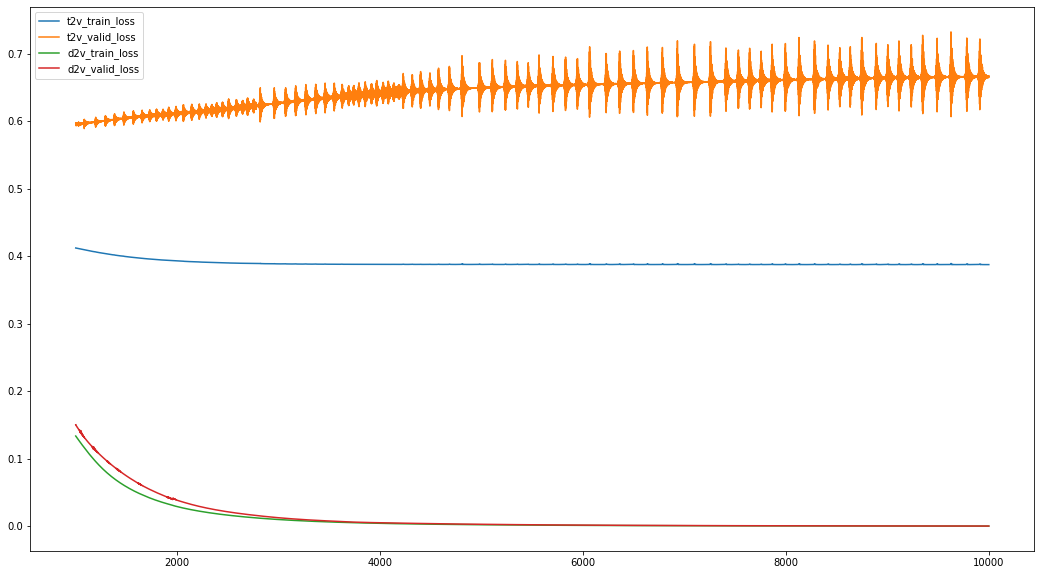

In [23]:
pd.DataFrame(
    [t2v_train_loss, t2v_valid_loss, d2v_train_loss, d2v_valid_loss], 
    index=['t2v_train_loss', 't2v_valid_loss', 'd2v_train_loss', 'd2v_valid_loss'],
).T.iloc[1000:].plot(figsize=(18, 10))

# Classic Model with date features

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [25]:
train_x, train_y, test_x, test_y = split_dataset(
    feature=['year', 'dayofyear', 'month', 'dayofmonth','week', 'dayofweek'], split_loc=800)

In [26]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='entropy')
clf.fit(train_x, train_y)
clf.predict(test_x)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0])

In [27]:
clf = LogisticRegression(max_iter=1000)
clf.fit(train_x, train_y)
clf.predict(test_x)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0])